# Setup PyTorch and Ray Tune



In [2]:
!pip install torch torchvision
!pip install ray

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
import torchvision
from torchvision import datasets, transforms
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
import torchvision.models as models
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

# Helper code

## Data loader

In [4]:
def data_loader(batch_size=4):
  normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225])

  cifar10_training_data = torchvision.datasets.CIFAR10("/content", 
                                              train=True,
                                              transform = transforms.Compose([
                                                                              transforms.RandomHorizontalFlip(),
                                                                              transforms.RandomCrop(32, 4), # size 32x32, padding 4
                                                                              transforms.ToTensor(),
                                                                              normalize,]), 
                                              download=True)
  
  cifar10_val_data = torchvision.datasets.CIFAR10("/content", 
                                              train=True,
                                              transform = transforms.Compose([transforms.ToTensor(),
                                                                              normalize,]), 
                                              download=True)

  cifar10_testing_data = torchvision.datasets.CIFAR10("/content", 
                                              train=False,
                                              transform = transforms.Compose([transforms.ToTensor(),
                                                                              normalize,]), 
                                              download=True)
  # data = [torch.Size([10, 3, 32, 32]), torch.Size([10])]
  num_train = len(cifar10_training_data)
  indices = list(range(num_train))
  split = 5000 #45k/5k train/val split
  train_idx, valid_idx = indices[split:], indices[:split]
  train_sampler = SubsetRandomSampler(train_idx)
  valid_sampler = SubsetRandomSampler(valid_idx)
  cifar10_training_data_loader = torch.utils.data.DataLoader(cifar10_training_data, batch_size, sampler=train_sampler, shuffle=False)
  cifar10_val_data_loader = torch.utils.data.DataLoader(cifar10_val_data, batch_size, sampler=valid_sampler, shuffle=False)
  cifar10_testing_data_loader = torch.utils.data.DataLoader(cifar10_testing_data, batch_size, shuffle=True)
  return cifar10_training_data_loader, cifar10_val_data_loader, cifar10_testing_data_loader

  # for data in cifar10_training_data_loader:
  #   # print("data: ", data)
  #   images, labels = data[0], data[1]
  #   print("images.shape: {}, labels.shape: {}".format(images.shape, labels.shape))
  #   break

In [5]:
_, _, _ = data_loader()

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /content/cifar-10-python.tar.gz to /content
Files already downloaded and verified
Files already downloaded and verified


## Model

In [6]:
# A 2-conv-layer block of ResNet 
class block(nn.Module):
  def __init__(self, num_filters, enable_subsample):
    super().__init__()
    if enable_subsample:
      self.conv1 = nn.Conv2d(num_filters // 2, num_filters, kernel_size=3, stride=2, padding=1, bias=False)
    else:
      self.conv1 = nn.Conv2d(num_filters, num_filters, kernel_size=3, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(num_filters)
    self.relu1 = nn.ReLU()

    self.conv2 = nn.Conv2d(num_filters, num_filters, kernel_size=3, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(num_filters)
    self.relu2 = nn.ReLU()

    # Weight initialization as in https://github.com/a-martyn/resnet/blob/master/resnet.py
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
          nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
      elif isinstance(m, (nn.BatchNorm2d)):
          nn.init.constant_(m.weight,1)
          nn.init.constant_(m.bias, 0) 

  def forward(self, x, enable_skip_connections=False):
    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu1(out)
    out = self.conv2(out)
    out = self.bn2(out)
    if enable_skip_connections:
      # print(out.shape, x.shape)
      if out.shape != x.shape:
        W_s = nn.Conv2d(x.shape[1], out.shape[1], kernel_size=1, stride=2).to(device='cuda')
        x = W_s(x)
        # print("after", out.shape, x.shape)
      else:
        out = x + out
    out = self.relu2(out)
    return out

# ResNet for CIFAR-10 as in paper
class ResNet(nn.Module):
  def __init__(self, n, width, enable_skip_connections=False):
    super().__init__()
    self.skip_connection = enable_skip_connections

    self.num_layer1_filters = int(16 * width)
    self.num_layer2_filters = int(32 * width)
    self.num_layer3_filters = int(64 * width)

    self.layer0 = nn.Sequential(
        nn.Conv2d(3, self.num_layer1_filters, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(self.num_layer1_filters),
        nn.ReLU()
    )
    
    self.layer1 = nn.ModuleList([block(self.num_layer1_filters, enable_subsample=False) for i in range(n)])
    self.layer2_subsample = block(self.num_layer2_filters, enable_subsample=True)
    self.layer2 = nn.ModuleList([block(self.num_layer2_filters, enable_subsample=False) for i in range(n-1)])
    self.layer3_subsample = block(self.num_layer3_filters, enable_subsample=True)
    self.layer3 = nn.ModuleList([block(self.num_layer3_filters, enable_subsample=False) for i in range(n-1)])

    self.avgpooling = nn.AdaptiveAvgPool2d(1)
    self.fc_layer = nn.Linear(self.num_layer3_filters, 10)
    self.softmax = nn.Softmax(dim=1)    
  
  def forward(self, x):
    out = self.layer0(x)
    for block in self.layer1:
      out = block(out, self.skip_connection)
    out = self.layer2_subsample(out, self.skip_connection)
    for block in self.layer2:
      out = block(out, self.skip_connection)
    out = self.layer3_subsample(out, self.skip_connection)
    for block in self.layer3:
      out = block(out, self.skip_connection)
    out = self.avgpooling(out)
    out = out.reshape((-1, self.num_layer3_filters))
    out = self.fc_layer(out)
    out = self.softmax(out)

    return out

# curr_model = block(32, enable_subsample=False)
# print(curr_model)

# resnet20_plain = ResNet(3)
# resnet20 = ResNet(3, enable_skip_connections=True)

# resnet18 = models.resnet18()
# print(resnet18)
# print(sum(p.numel() for p in resnet20_plain.parameters()))
# print(sum(p.numel() for p in resnet20.parameters()))

## Test Training

In [ ]:
def resnet_training():

  batch_size = 128
  net = ResNet(1, True)
  #net = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

  trainloader, valloader, testloader = data_loader(batch_size)
  print(len(trainloader), len(valloader), len(testloader))
  classes = ('plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  device = "cpu"
  if torch.cuda.is_available():
      device = "cuda:0"
      if torch.cuda.device_count() > 1:
          net = nn.DataParallel(net)
  net = net.to(device)
  # https://discuss.pytorch.org/t/how-to-increase-the-learning-rate-without-using-cyclical-learning-rates/140208/4
  def _lr_lambda(current_step):
        """
        _lr_lambda returns a multiplicative factor given an interger parameter epochs.
        """
        if current_step < 400:
            _lr =.1
        elif current_step < 32000:
            _lr = 1
        elif current_step < 48000:
            _lr = .1
        else:
            _lr = .01

        return _lr

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
  scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, _lr_lambda, last_epoch=-1, verbose=False)
  for epoch in range(182):  # loop over the dataset multiple times
      running_loss = 0.0
      for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 10 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 10:.3f}')
            running_loss = 0.0
      
      val_loss = 0.0
      val_steps = 0
      total = 0
      correct = 0
      for i, data in enumerate(valloader, 0):
          with torch.no_grad():
              inputs, labels = data
              inputs, labels = inputs.to(device), labels.to(device)

              outputs = net(inputs)
              _, predicted = torch.max(outputs.data, 1)
              total += labels.size(0)
              correct += (predicted == labels).sum().item()

              loss = criterion(outputs, labels)
              val_loss += loss.cpu().numpy()
              val_steps += 1
      print("epoch {} val_loss {} val_steps {} val_acc {}".format(epoch, val_loss, val_steps, correct / total))
  print('Finished Training')
resnet_training()

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /content/cifar-10-python.tar.gz to /content
Files already downloaded and verified
Files already downloaded and verified
352 40 79
[1,    10] loss: 2.302
[1,    20] loss: 2.302
[1,    30] loss: 2.303
[1,    40] loss: 2.302
[1,    50] loss: 2.302
[1,    60] loss: 2.301
[1,    70] loss: 2.301
[1,    80] loss: 2.300
[1,    90] loss: 2.299
[1,   100] loss: 2.299
[1,   110] loss: 2.298
[1,   120] loss: 2.296
[1,   130] loss: 2.295
[1,   140] loss: 2.296
[1,   150] loss: 2.287
[1,   160] loss: 2.288
[1,   170] loss: 2.277
[1,   180] loss: 2.283
[1,   190] loss: 2.279
[1,   200] loss: 2.278
[1,   210] loss: 2.271
[1,   220] loss: 2.277
[1,   230] loss: 2.267
[1,   240] loss: 2.270
[1,   250] loss: 2.273
[1,   260] loss: 2.273
[1,   270] loss: 2.268
[1,   280] loss: 2.263
[1,   290] loss: 2.264
[1,   300] loss: 2.263
[1,   310] loss: 2.263
[1,   320] loss: 2.261
[1,   330] loss: 2.260
[1,   340] loss: 2.261
[1,   350] loss: 2.248
epoch 0 val_loss 90.11727619171143 val_steps 40 val_ac

TypeError: ignored

## Test accuracy


In [ ]:
def test_accuracy(net, device="cpu"):
    trainset, testset = load_data1()

    testloader = torch.utils.data.DataLoader(
        testset, batch_size=4, shuffle=False, num_workers=2)

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

# ...


## DenseNet

Model

In [ ]:
import math

class Bottleneck(nn.Module):
    def __init__(self, in_planes, growth_rate):
        super(Bottleneck, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, 4*growth_rate, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(4*growth_rate)
        self.conv2 = nn.Conv2d(4*growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        out = self.conv1(F.relu(self.bn1(x)))
        out = self.conv2(F.relu(self.bn2(out)))
        out = torch.cat([out,x], 1)
        return out


class Transition(nn.Module):
    def __init__(self, in_planes, out_planes):
        super(Transition, self).__init__()
        self.bn = nn.BatchNorm2d(in_planes)
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=1, bias=False)

    def forward(self, x):
        out = self.conv(F.relu(self.bn(x)))
        out = F.avg_pool2d(out, 2)
        return out


class DenseNet(nn.Module):
    def __init__(self, block, nblocks, growth_rate=12, reduction=0.5, num_classes=10):
        super(DenseNet, self).__init__()
        self.growth_rate = growth_rate

        num_planes = 2*growth_rate
        self.conv1 = nn.Conv2d(3, num_planes, kernel_size=3, padding=1, bias=False)

        self.dense1 = self._make_dense_layers(block, num_planes, nblocks[0])
        num_planes += nblocks[0]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans1 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense2 = self._make_dense_layers(block, num_planes, nblocks[1])
        num_planes += nblocks[1]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans2 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense3 = self._make_dense_layers(block, num_planes, nblocks[2])
        num_planes += nblocks[2]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans3 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense4 = self._make_dense_layers(block, num_planes, nblocks[3])
        num_planes += nblocks[3]*growth_rate

        self.bn = nn.BatchNorm2d(num_planes)
        self.linear = nn.Linear(num_planes, num_classes)

    def _make_dense_layers(self, block, in_planes, nblock):
        layers = []
        for i in range(nblock):
            layers.append(block(in_planes, self.growth_rate))
            in_planes += self.growth_rate
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.trans1(self.dense1(out))
        out = self.trans2(self.dense2(out))
        out = self.trans3(self.dense3(out))
        out = self.dense4(out)
        out = F.avg_pool2d(F.relu(self.bn(out)), 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def DenseNet121():
    return DenseNet(Bottleneck, [6,12,24,16], growth_rate=12)

Train


batch size 64 for 300 and 40 epochs
init lr 0.1 divided by 10 at 50% and 75%
weight decay 10^-4
momentum 0.9
dropout 0.2

In [ ]:
def train_dense(weight_decay=0.0001, momentum=0.9, batch_size=128):
  net = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=False)
  
  trainloader, valloader, testloader = data_loader(batch_size)
  classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')
  
  device = "cpu"
  if torch.cuda.is_available():
      device = "cuda:0"
      if torch.cuda.device_count() > 1:
          net = nn.DataParallel(net)
  net.to(device)

  def _lr_lambda(current_step):
      """
      _lr_lambda returns a multiplicative factor given an interger parameter epochs.
      """
      if current_step < 25000:
          _lr = 1
      elif current_step < 37500:
          _lr = .1
      else:
          _lr = .01
      return _lr

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=0.1,
                        momentum, weight_decay)
  scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, _lr_lambda, last_epoch=-1, verbose=True)

  for epoch in range(10):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_steps += 1
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,
                                                running_loss / epoch_steps))
                running_loss = 0.0
        

        # Validation loss
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, data in enumerate(valloader, 0):
            with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1
        print("epoch {} val_loss {} val_steps {} val_acc {}".format(epoch, val_loss, val_steps, correct / total))
  print("Finished Training")


In [ ]:
train_dense()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
epoch 0 val_loss 35.10935813188553 val_steps 40 val_acc 0.7032
epoch 1 val_loss 29.122162997722626 val_steps 40 val_acc 0.7608
epoch 2 val_loss 25.626320630311966 val_steps 40 val_acc 0.7912


KeyboardInterrupt: ignored

Config the Search space for Ray Tune

In [ ]:
# import torch.optim as optim
# from ray import tune
# from ray.tune.examples.mnist_pytorch import get_data_loaders, ConvNet, train, test


# def train_mnist(config):
#     train_loader, test_loader = get_data_loaders()
#     model = ConvNet()
#     optimizer = optim.SGD(model.parameters(), lr=config["lr"])

#     device = "cpu"
#     if torch.cuda.is_available():
#         device = "cuda:0"
#         if torch.cuda.device_count() > 1:
#             net = nn.DataParallel(net)
#     net.to(device)

#     for i in range(10):
#         train(model, optimizer, train_loader)
#         acc = test(model, test_loader)
#         tune.report(mean_accuracy=acc)


# analysis = tune.run(
#     train_mnist, config={"lr": tune.grid_search([0.001, 0.01, 0.1])})

# print("Best config: ", analysis.get_best_config(metric="mean_accuracy"))

# # Get a dataframe for analyzing trial results.
# df = analysis.dataframe()

In [7]:
import numpy as np
import os
from functools import partial
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from filelock import FileLock
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
import psutil
import ray
ray._private.utils.get_system_memory = lambda: psutil.virtual_memory().total
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

In [ ]:
# def load_data1(data_dir="./data"):
#     transform = transforms.Compose([
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                               std=[0.229, 0.224, 0.225])
#     ])

#     trainset = torchvision.datasets.CIFAR10(
#         root=data_dir, train=True, download=True, transform=transform)

#     testset = torchvision.datasets.CIFAR10(
#         root=data_dir, train=False, download=True, transform=transform)

#     return trainset, testset

In [ ]:
# class Net(nn.Module):
#     def __init__(self, l1=120, l2=84):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(3, 6, 5)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(6, 16, 5)
#         self.fc1 = nn.Linear(16 * 5 * 5, 32)
#         self.fc2 = nn.Linear(32, 16)
#         self.fc3 = nn.Linear(16, 10)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = x.view(-1, 16 * 5 * 5)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

In [ ]:
# def train_cifar(config, checkpoint_dir=None, data_dir=None):
#     net = ResNet(3, enable_skip_connections=True) # resnet20
#     if torch.cuda.is_available():
#       net.cuda()

#     device = "cpu"
#     if torch.cuda.is_available():
#         device = "cuda:0"
#         if torch.cuda.device_count() > 1:
#             net = nn.DataParallel(net)
#     net.to(device)

#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.SGD(net.parameters(), lr=config["lr"], momentum=0.9)

#     if checkpoint_dir:
#         model_state, optimizer_state = torch.load(
#             os.path.join(checkpoint_dir, "checkpoint"))
#         net.load_state_dict(model_state)
#         optimizer.load_state_dict(optimizer_state)

#     trainset, testset = load_data1(data_dir)

#     test_abs = int(len(trainset) * 0.8)
#     train_subset, val_subset = random_split(
#         trainset, [test_abs, len(trainset) - test_abs])
    
#     trainloader, valloader, testloader = data_loader()

#     trainloader = torch.utils.data.DataLoader(
#         train_subset,
#         batch_size=int(config["batch_size"]),
#         shuffle=True,
#         num_workers=8)
#     valloader = torch.utils.data.DataLoader(
#         val_subset,
#         batch_size=int(config["batch_size"]),
#         shuffle=True,
#         num_workers=8)

#     for epoch in range(10):  # loop over the dataset multiple times
#         running_loss = 0.0
#         epoch_steps = 0
    #     for i, data in enumerate(trainloader, 0):
    #         # get the inputs; data is a list of [inputs, labels]
    #         inputs, labels = data
    #         inputs, labels = inputs.to(device), labels.to(device)
    #         #print("device:", device)
    #         # zero the parameter gradients
    #         optimizer.zero_grad()

    #         # forward + backward + optimize
    #         outputs = net(inputs)
    #         loss = criterion(outputs, labels)
    #         loss.backward()
    #         optimizer.step()

    #         # print statistics
    #         running_loss += loss.item()
    #         epoch_steps += 1
    #         if i % 2000 == 1999:  # print every 2000 mini-batches
    #             print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,
    #                                             running_loss / epoch_steps))
    #             running_loss = 0.0

    #     # Validation loss
    #     val_loss = 0.0
    #     val_steps = 0
    #     total = 0
    #     correct = 0
    #     for i, data in enumerate(valloader, 0):
    #         with torch.no_grad():
    #             inputs, labels = data
    #             inputs, labels = inputs.to(device), labels.to(device)

    #             outputs = net(inputs)
    #             _, predicted = torch.max(outputs.data, 1)
    #             total += labels.size(0)
    #             correct += (predicted == labels).sum().item()

    #             loss = criterion(outputs, labels)
    #             val_loss += loss.cpu().numpy()
    #             val_steps += 1

    #     with tune.checkpoint_dir(epoch) as checkpoint_dir:
    #         path = os.path.join(checkpoint_dir, "checkpoint")
    #         torch.save((net.state_dict(), optimizer.state_dict()), path)

    #     tune.report(loss=(val_loss / val_steps), accuracy=correct / total)
    # print("Finished Training")

(func pid=684) device: cuda:0
(func pid=684) device: cuda:0
(func pid=684) device: cuda:0
(func pid=684) device: cuda:0
(func pid=684) device: cuda:0
(func pid=684) device: cuda:0
(func pid=684) device: cuda:0
(func pid=684) device: cuda:0
(func pid=684) device: cuda:0
(func pid=684) device: cuda:0
(func pid=684) device: cuda:0
(func pid=684) device: cuda:0
(func pid=684) device: cuda:0
(func pid=684) device: cuda:0
(func pid=684) device: cuda:0
(func pid=684) device: cuda:0
(func pid=684) device: cuda:0
(func pid=684) device: cuda:0


In [ ]:
# def test_accuracy(net, device="cpu"):
#     trainset, testset = load_data1()

#     device = "cpu"
#     if torch.cuda.is_available():
#         device = "cuda:0"
#         net.cuda()

#     testloader = torch.utils.data.DataLoader(
#         testset, batch_size=4, shuffle=False, num_workers=2)

#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for data in testloader:
#             images, labels = data
#             images, labels = images.to(device), labels.to(device)
#             outputs = net(images)
#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()

#     return correct / total

In Original paper
(Hyper) SGD wiht mini-batch size 128  
(Hyper) learning rate starts from 0.1, divide it by 10 at 32K and 48K iterations,   
terminate at 64k iterations  
45k/5k train/val split
(Done) Image agumentation: 4 pixels are padded on each side, and a 32x32 crop is randomly sampled from the padded image or its horizontal flip. for testing, only evaluate the single view of the original 32x32 image.  
(Hyper) weight decay : 0.0001  
(Hyper) momentum : 0.9  


In [ ]:
# def main(num_samples=10, max_num_epochs=10, gpus_per_trial=2):
#     data_dir = os.path.abspath("./data")
#     load_data1(data_dir)
#     config = {
#         "lr": tune.loguniform(1e-4, 1e-1),
#         "batch_size": tune.choice([2, 4, 8, 16])
#     }
#     scheduler = ASHAScheduler(
#         metric="loss",
#         mode="min",
#         max_t=max_num_epochs,
#         grace_period=1,
#         reduction_factor=2)
#     reporter = CLIReporter(
#         # parameter_columns=["l1", "l2", "lr", "batch_size"],
#         metric_columns=["loss", "accuracy", "training_iteration"])
#     result = tune.run(
#         partial(train_cifar, data_dir=data_dir),
#         resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
#         config=config,
#         num_samples=num_samples,
#         scheduler=scheduler,
#         progress_reporter=reporter)

#     best_trial = result.get_best_trial("loss", "min", "last")
#     print("Best trial config: {}".format(best_trial.config))
#     print("Best trial final validation loss: {}".format(
#         best_trial.last_result["loss"]))
#     print("Best trial final validation accuracy: {}".format(
#         best_trial.last_result["accuracy"]))

#     best_trained_model = ResNet(3, enable_skip_connections=True)
#     # best_trained_model = Net(best_trial.config["l1"], best_trial.config["l2"])
#     device = "cpu"
#     if torch.cuda.is_available():
#         device = "cuda:0"
#         if gpus_per_trial > 1:
#             best_trained_model = nn.DataParallel(best_trained_model)
#     best_trained_model.to(device)
#     best_trained_model.cuda()

#     best_checkpoint_dir = best_trial.checkpoint.value
#     model_state, optimizer_state = torch.load(os.path.join(
#         best_checkpoint_dir, "checkpoint"))
#     best_trained_model.load_state_dict(model_state)

#     test_acc = test_accuracy(best_trained_model, device)
#     print("Best trial test set accuracy: {}".format(test_acc))

# main(num_samples=5, max_num_epochs=10, gpus_per_trial=1)

Files already downloaded and verified


KeyboardInterrupt: ignored

# ResNet Experiments

In [8]:
def simple_data_loader(batch_size=128):
  normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225])

  cifar10_training_data = torchvision.datasets.CIFAR10("/content", 
                                              train=True,
                                              transform = transforms.Compose([
                                                                              transforms.RandomHorizontalFlip(),
                                                                              transforms.RandomCrop(32, 4), # size 32x32, padding 4
                                                                              transforms.ToTensor(),
                                                                              normalize,]), 
                                              download=True)
  
  cifar10_testing_data = torchvision.datasets.CIFAR10("/content", 
                                              train=False,
                                              transform = transforms.Compose([transforms.ToTensor(),
                                                                              normalize,]), 
                                              download=True)
  # data = [torch.Size([10, 3, 32, 32]), torch.Size([10])]
  cifar10_training_data_loader = torch.utils.data.DataLoader(cifar10_training_data, batch_size, shuffle=True)
  cifar10_testing_data_loader = torch.utils.data.DataLoader(cifar10_testing_data, batch_size, shuffle=True)
  return cifar10_training_data_loader, cifar10_testing_data_loader

In [9]:
def train(net, optimizer, trainloader, epoch, device):
  batch_size = 128
  #net = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

  # https://discuss.pytorch.org/t/how-to-increase-the-learning-rate-without-using-cyclical-learning-rates/140208/4
  def _lr_lambda(current_step):
        """
        _lr_lambda returns a multiplicative factor given an interger parameter epochs.
        """
        if current_step < 400:
            _lr =.1
        elif current_step < 32000:
            _lr = 1
        elif current_step < 48000:
            _lr = .1
        else:
            _lr = .01

        return _lr

  criterion = nn.CrossEntropyLoss()
  scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, _lr_lambda, last_epoch=-1, verbose=False)
      
  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    scheduler.step()
    # print statistics
    # running_loss += loss.item()
    # if i % 10 == 9:    # print every 10 mini-batches
    #     print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 10:.3f}')
    #     running_loss = 0.0
      
  print('Finished Training epoch {}'.format(epoch))


def test(net, testloader, device, epoch):
    global best_acc
    net.eval()
    test_loss=0
    correct=0
    total=0
    criterion=nn.CrossEntropyLoss()
    test_steps=0
    with torch.no_grad():
        for batch_idx,(inputs,targets)in enumerate(testloader):
            inputs,targets=inputs.to(device),targets.to(device)
            outputs=net(inputs)
            loss=criterion(outputs,targets)

            test_loss+=loss.item()
            _,predicted=outputs.max(1)
            total+=targets.size(0)
            correct+=predicted.eq(targets).sum().item()
            test_steps+=1
    print("epoch {} test_loss {} test_steps {} test_acc {}".format(epoch,test_loss,test_steps,correct/total))
    return correct / total

In [10]:
def train_cifar(config):
    
    trainloader, testloader = simple_data_loader(batch_size=128)

    model = ResNet(config["n"], config["width"], enable_skip_connections=True)
    device = "cpu"
    if torch.cuda.is_available():
      device = "cuda:0"
      if torch.cuda.device_count() > 1:
          net = nn.DataParallel(model)
    else:
      print("There")
    model = model.to(device)
    
    optimizer = optim.SGD(model.parameters(), lr=config["lr"], momentum=config["momentum"], weight_decay=config["weight_decay"])
    for epoch in range(15): # loop over the dataset multiple times
        train(model, optimizer, trainloader, epoch, device)
        acc = test(model, testloader, device, 1)

        # Send the current training result back to Tune
        tune.report(mean_accuracy=acc)

        if epoch % 5 == 0:
            # This saves the model to the trial directory
            torch.save(model.state_dict(), "./model.pth")

In [ ]:
# Config for ResNet hyperparameter sensitivity analysis for lr
config = {
    "lr": tune.grid_search([0.05, 0.075, 0.1, 0.125, 0.15]),
    "momentum": tune.grid_search([0.9]),
    "weight_decay": tune.grid_search([0.0001]),
    "n": tune.grid_search([3]),
    "width": tune.grid_search([1])
}

datasets.CIFAR10("~/data", train=True, download=True)

analysis = tune.run(train_cifar, config=config, resources_per_trial={"cpu": 1, "gpu": 1})

Files already downloaded and verified


2022-04-20 21:19:56,675	WARNING callback.py:126 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`
2022-04-20 21:19:56,806	INFO trial_runner.py:803 -- starting train_cifar_a0a87_00000


(train_cifar pid=6186) Files already downloaded and verified
(train_cifar pid=6186) Files already downloaded and verified


(train_cifar pid=6186) Finished Training epoch 0
Result for train_cifar_a0a87_00000:
  date: 2022-04-20_21-20-27
  done: false
  experiment_id: 3ad68a05b78c406982f266f2195da9d7
  hostname: cd7cf695d4cb
  iterations_since_restore: 1
  mean_accuracy: 0.2442
  node_ip: 172.28.0.2
  pid: 6186
  time_since_restore: 28.709822177886963
  time_this_iter_s: 28.709822177886963
  time_total_s: 28.709822177886963
  timestamp: 1650489627
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: a0a87_00000
  warmup_time: 0.0040552616119384766
  
(train_cifar pid=6186) epoch 1 test_loss 175.28594708442688 test_steps 79 test_acc 0.2442


(train_cifar pid=6186) Finished Training epoch 1
Result for train_cifar_a0a87_00000:
  date: 2022-04-20_21-20-50
  done: false
  experiment_id: 3ad68a05b78c406982f266f2195da9d7
  hostname: cd7cf695d4cb
  iterations_since_restore: 2
  mean_accuracy: 0.3356
  node_ip: 172.28.0.2
  pid: 6186
  time_since_restore: 51.19477868080139
  time_this_iter_s: 22.48495650291443
  time_total_s: 51.19477868080139
  timestamp: 1650489650
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: a0a87_00000
  warmup_time: 0.0040552616119384766
  
(train_cifar pid=6186) epoch 1 test_loss 167.1641764640808 test_steps 79 test_acc 0.3356


(train_cifar pid=6186) Finished Training epoch 2


Result for train_cifar_a0a87_00000:
  date: 2022-04-20_21-21-12
  done: false
  experiment_id: 3ad68a05b78c406982f266f2195da9d7
  hostname: cd7cf695d4cb
  iterations_since_restore: 3
  mean_accuracy: 0.3682
  node_ip: 172.28.0.2
  pid: 6186
  time_since_restore: 73.42376565933228
  time_this_iter_s: 22.228986978530884
  time_total_s: 73.42376565933228
  timestamp: 1650489672
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: a0a87_00000
  warmup_time: 0.0040552616119384766
  
(train_cifar pid=6186) epoch 1 test_loss 164.45821011066437 test_steps 79 test_acc 0.3682


(train_cifar pid=6186) Finished Training epoch 3


Result for train_cifar_a0a87_00000:
  date: 2022-04-20_21-21-34
  done: false
  experiment_id: 3ad68a05b78c406982f266f2195da9d7
  hostname: cd7cf695d4cb
  iterations_since_restore: 4
  mean_accuracy: 0.3891
  node_ip: 172.28.0.2
  pid: 6186
  time_since_restore: 95.75364851951599
  time_this_iter_s: 22.329882860183716
  time_total_s: 95.75364851951599
  timestamp: 1650489694
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: a0a87_00000
  warmup_time: 0.0040552616119384766
  
(train_cifar pid=6186) epoch 1 test_loss 162.96733832359314 test_steps 79 test_acc 0.3891


(train_cifar pid=6186) Finished Training epoch 4


Result for train_cifar_a0a87_00000:
  date: 2022-04-20_21-21-57
  done: false
  experiment_id: 3ad68a05b78c406982f266f2195da9d7
  hostname: cd7cf695d4cb
  iterations_since_restore: 5
  mean_accuracy: 0.3716
  node_ip: 172.28.0.2
  pid: 6186
  time_since_restore: 117.91394138336182
  time_this_iter_s: 22.160292863845825
  time_total_s: 117.91394138336182
  timestamp: 1650489717
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: a0a87_00000
  warmup_time: 0.0040552616119384766
  
(train_cifar pid=6186) epoch 1 test_loss 164.51048028469086 test_steps 79 test_acc 0.3716


(train_cifar pid=6186) Finished Training epoch 5


Result for train_cifar_a0a87_00000:
  date: 2022-04-20_21-22-19
  done: false
  experiment_id: 3ad68a05b78c406982f266f2195da9d7
  hostname: cd7cf695d4cb
  iterations_since_restore: 6
  mean_accuracy: 0.3864
  node_ip: 172.28.0.2
  pid: 6186
  time_since_restore: 140.06749153137207
  time_this_iter_s: 22.153550148010254
  time_total_s: 140.06749153137207
  timestamp: 1650489739
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: a0a87_00000
  warmup_time: 0.0040552616119384766
  
(train_cifar pid=6186) epoch 1 test_loss 163.11753129959106 test_steps 79 test_acc 0.3864


(train_cifar pid=6186) Finished Training epoch 6
Result for train_cifar_a0a87_00000:
  date: 2022-04-20_21-22-42
  done: false
  experiment_id: 3ad68a05b78c406982f266f2195da9d7
  hostname: cd7cf695d4cb
  iterations_since_restore: 7
  mean_accuracy: 0.4249
  node_ip: 172.28.0.2
  pid: 6186
  time_since_restore: 163.0212140083313
  time_this_iter_s: 22.95372247695923
  time_total_s: 163.0212140083313
  timestamp: 1650489762
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: a0a87_00000
  warmup_time: 0.0040552616119384766
  
(train_cifar pid=6186) epoch 1 test_loss 160.75247192382812 test_steps 79 test_acc 0.4249


(train_cifar pid=6186) Finished Training epoch 7
Result for train_cifar_a0a87_00000:
  date: 2022-04-20_21-23-05
  done: false
  experiment_id: 3ad68a05b78c406982f266f2195da9d7
  hostname: cd7cf695d4cb
  iterations_since_restore: 8
  mean_accuracy: 0.4188
  node_ip: 172.28.0.2
  pid: 6186
  time_since_restore: 186.81422877311707
  time_this_iter_s: 23.793014764785767
  time_total_s: 186.81422877311707
  timestamp: 1650489785
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: a0a87_00000
  warmup_time: 0.0040552616119384766
  
(train_cifar pid=6186) epoch 1 test_loss 161.02085304260254 test_steps 79 test_acc 0.4188


(train_cifar pid=6186) Finished Training epoch 8
Result for train_cifar_a0a87_00000:
  date: 2022-04-20_21-23-28
  done: false
  experiment_id: 3ad68a05b78c406982f266f2195da9d7
  hostname: cd7cf695d4cb
  iterations_since_restore: 9
  mean_accuracy: 0.4418
  node_ip: 172.28.0.2
  pid: 6186
  time_since_restore: 209.2750015258789
  time_this_iter_s: 22.46077275276184
  time_total_s: 209.2750015258789
  timestamp: 1650489808
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: a0a87_00000
  warmup_time: 0.0040552616119384766
  
(train_cifar pid=6186) epoch 1 test_loss 159.2585324048996 test_steps 79 test_acc 0.4418


(train_cifar pid=6186) Finished Training epoch 9
Result for train_cifar_a0a87_00000:
  date: 2022-04-20_21-23-51
  done: false
  experiment_id: 3ad68a05b78c406982f266f2195da9d7
  hostname: cd7cf695d4cb
  iterations_since_restore: 10
  mean_accuracy: 0.4596
  node_ip: 172.28.0.2
  pid: 6186
  time_since_restore: 232.2384307384491
  time_this_iter_s: 22.96342921257019
  time_total_s: 232.2384307384491
  timestamp: 1650489831
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: a0a87_00000
  warmup_time: 0.0040552616119384766
  
(train_cifar pid=6186) epoch 1 test_loss 157.9264668226242 test_steps 79 test_acc 0.4596


(train_cifar pid=6186) Finished Training epoch 10
Result for train_cifar_a0a87_00000:
  date: 2022-04-20_21-24-13
  done: false
  experiment_id: 3ad68a05b78c406982f266f2195da9d7
  hostname: cd7cf695d4cb
  iterations_since_restore: 11
  mean_accuracy: 0.4543
  node_ip: 172.28.0.2
  pid: 6186
  time_since_restore: 254.66845965385437
  time_this_iter_s: 22.430028915405273
  time_total_s: 254.66845965385437
  timestamp: 1650489853
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: a0a87_00000
  warmup_time: 0.0040552616119384766
  
(train_cifar pid=6186) epoch 1 test_loss 158.3268597126007 test_steps 79 test_acc 0.4543


(train_cifar pid=6186) Finished Training epoch 11


Result for train_cifar_a0a87_00000:
  date: 2022-04-20_21-24-36
  done: false
  experiment_id: 3ad68a05b78c406982f266f2195da9d7
  hostname: cd7cf695d4cb
  iterations_since_restore: 12
  mean_accuracy: 0.4756
  node_ip: 172.28.0.2
  pid: 6186
  time_since_restore: 277.08414673805237
  time_this_iter_s: 22.415687084197998
  time_total_s: 277.08414673805237
  timestamp: 1650489876
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: a0a87_00000
  warmup_time: 0.0040552616119384766
  
(train_cifar pid=6186) epoch 1 test_loss 156.54697239398956 test_steps 79 test_acc 0.4756


(train_cifar pid=6186) Finished Training epoch 12


Result for train_cifar_a0a87_00000:
  date: 2022-04-20_21-24-58
  done: false
  experiment_id: 3ad68a05b78c406982f266f2195da9d7
  hostname: cd7cf695d4cb
  iterations_since_restore: 13
  mean_accuracy: 0.5035
  node_ip: 172.28.0.2
  pid: 6186
  time_since_restore: 299.2438325881958
  time_this_iter_s: 22.159685850143433
  time_total_s: 299.2438325881958
  timestamp: 1650489898
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: a0a87_00000
  warmup_time: 0.0040552616119384766
  
(train_cifar pid=6186) epoch 1 test_loss 154.28403913974762 test_steps 79 test_acc 0.5035


(train_cifar pid=6186) Finished Training epoch 13
Result for train_cifar_a0a87_00000:
  date: 2022-04-20_21-25-20
  done: false
  experiment_id: 3ad68a05b78c406982f266f2195da9d7
  hostname: cd7cf695d4cb
  iterations_since_restore: 14
  mean_accuracy: 0.4991
  node_ip: 172.28.0.2
  pid: 6186
  time_since_restore: 321.7748670578003
  time_this_iter_s: 22.531034469604492
  time_total_s: 321.7748670578003
  timestamp: 1650489920
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: a0a87_00000
  warmup_time: 0.0040552616119384766
  
(train_cifar pid=6186) epoch 1 test_loss 154.71543622016907 test_steps 79 test_acc 0.4991


(train_cifar pid=6186) Finished Training epoch 14
Result for train_cifar_a0a87_00000:
  date: 2022-04-20_21-25-43
  done: false
  experiment_id: 3ad68a05b78c406982f266f2195da9d7
  hostname: cd7cf695d4cb
  iterations_since_restore: 15
  mean_accuracy: 0.5033
  node_ip: 172.28.0.2
  pid: 6186
  time_since_restore: 344.5576591491699
  time_this_iter_s: 22.78279209136963
  time_total_s: 344.5576591491699
  timestamp: 1650489943
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: a0a87_00000
  warmup_time: 0.0040552616119384766
  
Result for train_cifar_a0a87_00000:
  date: 2022-04-20_21-25-43
  done: true
  experiment_id: 3ad68a05b78c406982f266f2195da9d7
  experiment_tag: 0_lr=0.05,momentum=0.9,n=3,weight_decay=0.0001,width=1
  hostname: cd7cf695d4cb
  iterations_since_restore: 15
  mean_accuracy: 0.5033
  node_ip: 172.28.0.2
  pid: 6186
  time_since_restore: 344.5576591491699
  time_this_iter_s: 22.78279209136963
  time_total_s: 344.5576591491699
  timestamp: 1650489943
  ti

2022-04-20 21:25:44,107	INFO trial_runner.py:803 -- starting train_cifar_a0a87_00001


(train_cifar pid=6368) Files already downloaded and verified
(train_cifar pid=6368) Files already downloaded and verified


(train_cifar pid=6368) Finished Training epoch 0


Result for train_cifar_a0a87_00001:
  date: 2022-04-20_21-26-14
  done: false
  experiment_id: 4fc23c528c02445989a5a0c71210f94d
  hostname: cd7cf695d4cb
  iterations_since_restore: 1
  mean_accuracy: 0.249
  node_ip: 172.28.0.2
  pid: 6368
  time_since_restore: 28.511667251586914
  time_this_iter_s: 28.511667251586914
  time_total_s: 28.511667251586914
  timestamp: 1650489974
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: a0a87_00001
  warmup_time: 0.003879547119140625
  
(train_cifar pid=6368) epoch 1 test_loss 173.07036018371582 test_steps 79 test_acc 0.249


(train_cifar pid=6368) Finished Training epoch 1
Result for train_cifar_a0a87_00001:
  date: 2022-04-20_21-26-37
  done: false
  experiment_id: 4fc23c528c02445989a5a0c71210f94d
  hostname: cd7cf695d4cb
  iterations_since_restore: 2
  mean_accuracy: 0.333
  node_ip: 172.28.0.2
  pid: 6368
  time_since_restore: 51.06542205810547
  time_this_iter_s: 22.553754806518555
  time_total_s: 51.06542205810547
  timestamp: 1650489997
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: a0a87_00001
  warmup_time: 0.003879547119140625
  
(train_cifar pid=6368) epoch 1 test_loss 167.19186806678772 test_steps 79 test_acc 0.333


(train_cifar pid=6368) Finished Training epoch 2


Result for train_cifar_a0a87_00001:
  date: 2022-04-20_21-26-59
  done: false
  experiment_id: 4fc23c528c02445989a5a0c71210f94d
  hostname: cd7cf695d4cb
  iterations_since_restore: 3
  mean_accuracy: 0.3968
  node_ip: 172.28.0.2
  pid: 6368
  time_since_restore: 73.35004258155823
  time_this_iter_s: 22.28462052345276
  time_total_s: 73.35004258155823
  timestamp: 1650490019
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: a0a87_00001
  warmup_time: 0.003879547119140625
  
(train_cifar pid=6368) epoch 1 test_loss 162.47708976268768 test_steps 79 test_acc 0.3968


(train_cifar pid=6368) Finished Training epoch 3


Result for train_cifar_a0a87_00001:
  date: 2022-04-20_21-27-22
  done: false
  experiment_id: 4fc23c528c02445989a5a0c71210f94d
  hostname: cd7cf695d4cb
  iterations_since_restore: 4
  mean_accuracy: 0.3865
  node_ip: 172.28.0.2
  pid: 6368
  time_since_restore: 95.77567148208618
  time_this_iter_s: 22.425628900527954
  time_total_s: 95.77567148208618
  timestamp: 1650490042
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: a0a87_00001
  warmup_time: 0.003879547119140625
  
(train_cifar pid=6368) epoch 1 test_loss 163.40126359462738 test_steps 79 test_acc 0.3865


(train_cifar pid=6368) Finished Training epoch 4


Result for train_cifar_a0a87_00001:
  date: 2022-04-20_21-27-44
  done: false
  experiment_id: 4fc23c528c02445989a5a0c71210f94d
  hostname: cd7cf695d4cb
  iterations_since_restore: 5
  mean_accuracy: 0.421
  node_ip: 172.28.0.2
  pid: 6368
  time_since_restore: 117.97621822357178
  time_this_iter_s: 22.200546741485596
  time_total_s: 117.97621822357178
  timestamp: 1650490064
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: a0a87_00001
  warmup_time: 0.003879547119140625
  
(train_cifar pid=6368) epoch 1 test_loss 160.9165437221527 test_steps 79 test_acc 0.421


(train_cifar pid=6368) Finished Training epoch 5


Result for train_cifar_a0a87_00001:
  date: 2022-04-20_21-28-06
  done: false
  experiment_id: 4fc23c528c02445989a5a0c71210f94d
  hostname: cd7cf695d4cb
  iterations_since_restore: 6
  mean_accuracy: 0.4141
  node_ip: 172.28.0.2
  pid: 6368
  time_since_restore: 140.17122721672058
  time_this_iter_s: 22.195008993148804
  time_total_s: 140.17122721672058
  timestamp: 1650490086
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: a0a87_00001
  warmup_time: 0.003879547119140625
  
(train_cifar pid=6368) epoch 1 test_loss 161.49198853969574 test_steps 79 test_acc 0.4141


(train_cifar pid=6368) Finished Training epoch 6
Result for train_cifar_a0a87_00001:
  date: 2022-04-20_21-28-28
  done: false
  experiment_id: 4fc23c528c02445989a5a0c71210f94d
  hostname: cd7cf695d4cb
  iterations_since_restore: 7
  mean_accuracy: 0.4526
  node_ip: 172.28.0.2
  pid: 6368
  time_since_restore: 162.522216796875
  time_this_iter_s: 22.35098958015442
  time_total_s: 162.522216796875
  timestamp: 1650490108
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: a0a87_00001
  warmup_time: 0.003879547119140625
  
(train_cifar pid=6368) epoch 1 test_loss 158.17642295360565 test_steps 79 test_acc 0.4526


(train_cifar pid=6368) Finished Training epoch 7


Result for train_cifar_a0a87_00001:
  date: 2022-04-20_21-28-51
  done: false
  experiment_id: 4fc23c528c02445989a5a0c71210f94d
  hostname: cd7cf695d4cb
  iterations_since_restore: 8
  mean_accuracy: 0.4515
  node_ip: 172.28.0.2
  pid: 6368
  time_since_restore: 184.75093507766724
  time_this_iter_s: 22.228718280792236
  time_total_s: 184.75093507766724
  timestamp: 1650490131
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: a0a87_00001
  warmup_time: 0.003879547119140625
  
(train_cifar pid=6368) epoch 1 test_loss 158.4276865720749 test_steps 79 test_acc 0.4515


(train_cifar pid=6368) Finished Training epoch 8


Result for train_cifar_a0a87_00001:
  date: 2022-04-20_21-29-13
  done: false
  experiment_id: 4fc23c528c02445989a5a0c71210f94d
  hostname: cd7cf695d4cb
  iterations_since_restore: 9
  mean_accuracy: 0.4285
  node_ip: 172.28.0.2
  pid: 6368
  time_since_restore: 207.05897164344788
  time_this_iter_s: 22.30803656578064
  time_total_s: 207.05897164344788
  timestamp: 1650490153
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: a0a87_00001
  warmup_time: 0.003879547119140625
  
(train_cifar pid=6368) epoch 1 test_loss 160.09679412841797 test_steps 79 test_acc 0.4285


(train_cifar pid=6368) Finished Training epoch 9
Result for train_cifar_a0a87_00001:
  date: 2022-04-20_21-29-35
  done: false
  experiment_id: 4fc23c528c02445989a5a0c71210f94d
  hostname: cd7cf695d4cb
  iterations_since_restore: 10
  mean_accuracy: 0.4812
  node_ip: 172.28.0.2
  pid: 6368
  time_since_restore: 229.5406358242035
  time_this_iter_s: 22.481664180755615
  time_total_s: 229.5406358242035
  timestamp: 1650490175
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: a0a87_00001
  warmup_time: 0.003879547119140625
  
(train_cifar pid=6368) epoch 1 test_loss 155.87668013572693 test_steps 79 test_acc 0.4812


(train_cifar pid=6368) Finished Training epoch 10


Result for train_cifar_a0a87_00001:
  date: 2022-04-20_21-29-58
  done: false
  experiment_id: 4fc23c528c02445989a5a0c71210f94d
  hostname: cd7cf695d4cb
  iterations_since_restore: 11
  mean_accuracy: 0.5176
  node_ip: 172.28.0.2
  pid: 6368
  time_since_restore: 251.7326419353485
  time_this_iter_s: 22.19200611114502
  time_total_s: 251.7326419353485
  timestamp: 1650490198
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: a0a87_00001
  warmup_time: 0.003879547119140625
  
(train_cifar pid=6368) epoch 1 test_loss 153.38519823551178 test_steps 79 test_acc 0.5176


(train_cifar pid=6368) Finished Training epoch 11


Result for train_cifar_a0a87_00001:
  date: 2022-04-20_21-30-20
  done: false
  experiment_id: 4fc23c528c02445989a5a0c71210f94d
  hostname: cd7cf695d4cb
  iterations_since_restore: 12
  mean_accuracy: 0.5214
  node_ip: 172.28.0.2
  pid: 6368
  time_since_restore: 274.18875312805176
  time_this_iter_s: 22.456111192703247
  time_total_s: 274.18875312805176
  timestamp: 1650490220
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: a0a87_00001
  warmup_time: 0.003879547119140625
  
(train_cifar pid=6368) epoch 1 test_loss 152.83214342594147 test_steps 79 test_acc 0.5214


(train_cifar pid=6368) Finished Training epoch 12
Result for train_cifar_a0a87_00001:
  date: 2022-04-20_21-30-43
  done: false
  experiment_id: 4fc23c528c02445989a5a0c71210f94d
  hostname: cd7cf695d4cb
  iterations_since_restore: 13
  mean_accuracy: 0.5274
  node_ip: 172.28.0.2
  pid: 6368
  time_since_restore: 296.65129256248474
  time_this_iter_s: 22.462539434432983
  time_total_s: 296.65129256248474
  timestamp: 1650490243
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: a0a87_00001
  warmup_time: 0.003879547119140625
  
(train_cifar pid=6368) epoch 1 test_loss 152.36775708198547 test_steps 79 test_acc 0.5274


(train_cifar pid=6368) Finished Training epoch 13


Result for train_cifar_a0a87_00001:
  date: 2022-04-20_21-31-05
  done: false
  experiment_id: 4fc23c528c02445989a5a0c71210f94d
  hostname: cd7cf695d4cb
  iterations_since_restore: 14
  mean_accuracy: 0.5013
  node_ip: 172.28.0.2
  pid: 6368
  time_since_restore: 319.0899713039398
  time_this_iter_s: 22.438678741455078
  time_total_s: 319.0899713039398
  timestamp: 1650490265
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: a0a87_00001
  warmup_time: 0.003879547119140625
  
(train_cifar pid=6368) epoch 1 test_loss 154.70476055145264 test_steps 79 test_acc 0.5013


(train_cifar pid=6368) Finished Training epoch 14
Result for train_cifar_a0a87_00001:
  date: 2022-04-20_21-31-27
  done: false
  experiment_id: 4fc23c528c02445989a5a0c71210f94d
  hostname: cd7cf695d4cb
  iterations_since_restore: 15
  mean_accuracy: 0.5445
  node_ip: 172.28.0.2
  pid: 6368
  time_since_restore: 341.48034620285034
  time_this_iter_s: 22.390374898910522
  time_total_s: 341.48034620285034
  timestamp: 1650490287
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: a0a87_00001
  warmup_time: 0.003879547119140625
  
Result for train_cifar_a0a87_00001:
  date: 2022-04-20_21-31-27
  done: true
  experiment_id: 4fc23c528c02445989a5a0c71210f94d
  experiment_tag: 1_lr=0.075,momentum=0.9,n=3,weight_decay=0.0001,width=1
  hostname: cd7cf695d4cb
  iterations_since_restore: 15
  mean_accuracy: 0.5445
  node_ip: 172.28.0.2
  pid: 6368
  time_since_restore: 341.48034620285034
  time_this_iter_s: 22.390374898910522
  time_total_s: 341.48034620285034
  timestamp: 165049028

2022-04-20 21:31:28,179	INFO trial_runner.py:803 -- starting train_cifar_a0a87_00002


(train_cifar pid=6541) Files already downloaded and verified
(train_cifar pid=6541) Files already downloaded and verified


(train_cifar pid=6541) Finished Training epoch 0


Result for train_cifar_a0a87_00002:
  date: 2022-04-20_21-31-58
  done: false
  experiment_id: 0e558a85e8d04144ac8bbc9d467d61ff
  hostname: cd7cf695d4cb
  iterations_since_restore: 1
  mean_accuracy: 0.2483
  node_ip: 172.28.0.2
  pid: 6541
  time_since_restore: 28.306193590164185
  time_this_iter_s: 28.306193590164185
  time_total_s: 28.306193590164185
  timestamp: 1650490318
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: a0a87_00002
  warmup_time: 0.003443002700805664
  
(train_cifar pid=6541) epoch 1 test_loss 172.36454510688782 test_steps 79 test_acc 0.2483


(train_cifar pid=6541) Finished Training epoch 1


Result for train_cifar_a0a87_00002:
  date: 2022-04-20_21-32-20
  done: false
  experiment_id: 0e558a85e8d04144ac8bbc9d467d61ff
  hostname: cd7cf695d4cb
  iterations_since_restore: 2
  mean_accuracy: 0.3307
  node_ip: 172.28.0.2
  pid: 6541
  time_since_restore: 50.00325345993042
  time_this_iter_s: 21.697059869766235
  time_total_s: 50.00325345993042
  timestamp: 1650490340
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: a0a87_00002
  warmup_time: 0.003443002700805664
  
(train_cifar pid=6541) epoch 1 test_loss 167.74332094192505 test_steps 79 test_acc 0.3307


(train_cifar pid=6541) Finished Training epoch 2


Result for train_cifar_a0a87_00002:
  date: 2022-04-20_21-32-41
  done: false
  experiment_id: 0e558a85e8d04144ac8bbc9d467d61ff
  hostname: cd7cf695d4cb
  iterations_since_restore: 3
  mean_accuracy: 0.3594
  node_ip: 172.28.0.2
  pid: 6541
  time_since_restore: 71.47936749458313
  time_this_iter_s: 21.47611403465271
  time_total_s: 71.47936749458313
  timestamp: 1650490361
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: a0a87_00002
  warmup_time: 0.003443002700805664
  
(train_cifar pid=6541) epoch 1 test_loss 165.22395837306976 test_steps 79 test_acc 0.3594


(train_cifar pid=6541) Finished Training epoch 3


Result for train_cifar_a0a87_00002:
  date: 2022-04-20_21-33-03
  done: false
  experiment_id: 0e558a85e8d04144ac8bbc9d467d61ff
  hostname: cd7cf695d4cb
  iterations_since_restore: 4
  mean_accuracy: 0.3581
  node_ip: 172.28.0.2
  pid: 6541
  time_since_restore: 92.7185332775116
  time_this_iter_s: 21.239165782928467
  time_total_s: 92.7185332775116
  timestamp: 1650490383
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: a0a87_00002
  warmup_time: 0.003443002700805664
  
(train_cifar pid=6541) epoch 1 test_loss 165.24704349040985 test_steps 79 test_acc 0.3581


(train_cifar pid=6541) Finished Training epoch 4


Result for train_cifar_a0a87_00002:
  date: 2022-04-20_21-33-24
  done: false
  experiment_id: 0e558a85e8d04144ac8bbc9d467d61ff
  hostname: cd7cf695d4cb
  iterations_since_restore: 5
  mean_accuracy: 0.4143
  node_ip: 172.28.0.2
  pid: 6541
  time_since_restore: 114.31927633285522
  time_this_iter_s: 21.600743055343628
  time_total_s: 114.31927633285522
  timestamp: 1650490404
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: a0a87_00002
  warmup_time: 0.003443002700805664
  
(train_cifar pid=6541) epoch 1 test_loss 161.3798769712448 test_steps 79 test_acc 0.4143


(train_cifar pid=6541) Finished Training epoch 5


Result for train_cifar_a0a87_00002:
  date: 2022-04-20_21-33-46
  done: false
  experiment_id: 0e558a85e8d04144ac8bbc9d467d61ff
  hostname: cd7cf695d4cb
  iterations_since_restore: 6
  mean_accuracy: 0.4446
  node_ip: 172.28.0.2
  pid: 6541
  time_since_restore: 135.83192038536072
  time_this_iter_s: 21.512644052505493
  time_total_s: 135.83192038536072
  timestamp: 1650490426
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: a0a87_00002
  warmup_time: 0.003443002700805664
  
(train_cifar pid=6541) epoch 1 test_loss 159.0739334821701 test_steps 79 test_acc 0.4446


(train_cifar pid=6541) Finished Training epoch 6


Result for train_cifar_a0a87_00002:
  date: 2022-04-20_21-34-07
  done: false
  experiment_id: 0e558a85e8d04144ac8bbc9d467d61ff
  hostname: cd7cf695d4cb
  iterations_since_restore: 7
  mean_accuracy: 0.4561
  node_ip: 172.28.0.2
  pid: 6541
  time_since_restore: 157.5222623348236
  time_this_iter_s: 21.69034194946289
  time_total_s: 157.5222623348236
  timestamp: 1650490447
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: a0a87_00002
  warmup_time: 0.003443002700805664
  
(train_cifar pid=6541) epoch 1 test_loss 157.96080255508423 test_steps 79 test_acc 0.4561


(train_cifar pid=6541) Finished Training epoch 7


Result for train_cifar_a0a87_00002:
  date: 2022-04-20_21-34-29
  done: false
  experiment_id: 0e558a85e8d04144ac8bbc9d467d61ff
  hostname: cd7cf695d4cb
  iterations_since_restore: 8
  mean_accuracy: 0.4643
  node_ip: 172.28.0.2
  pid: 6541
  time_since_restore: 179.01757788658142
  time_this_iter_s: 21.495315551757812
  time_total_s: 179.01757788658142
  timestamp: 1650490469
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: a0a87_00002
  warmup_time: 0.003443002700805664
  
(train_cifar pid=6541) epoch 1 test_loss 157.60668754577637 test_steps 79 test_acc 0.4643


(train_cifar pid=6541) Finished Training epoch 8


Result for train_cifar_a0a87_00002:
  date: 2022-04-20_21-34-51
  done: false
  experiment_id: 0e558a85e8d04144ac8bbc9d467d61ff
  hostname: cd7cf695d4cb
  iterations_since_restore: 9
  mean_accuracy: 0.4569
  node_ip: 172.28.0.2
  pid: 6541
  time_since_restore: 200.66055750846863
  time_this_iter_s: 21.642979621887207
  time_total_s: 200.66055750846863
  timestamp: 1650490491
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: a0a87_00002
  warmup_time: 0.003443002700805664
  
(train_cifar pid=6541) epoch 1 test_loss 157.91091406345367 test_steps 79 test_acc 0.4569


(train_cifar pid=6541) Finished Training epoch 9


Result for train_cifar_a0a87_00002:
  date: 2022-04-20_21-35-13
  done: false
  experiment_id: 0e558a85e8d04144ac8bbc9d467d61ff
  hostname: cd7cf695d4cb
  iterations_since_restore: 10
  mean_accuracy: 0.5021
  node_ip: 172.28.0.2
  pid: 6541
  time_since_restore: 222.5633454322815
  time_this_iter_s: 21.902787923812866
  time_total_s: 222.5633454322815
  timestamp: 1650490513
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: a0a87_00002
  warmup_time: 0.003443002700805664
  
(train_cifar pid=6541) epoch 1 test_loss 154.403702378273 test_steps 79 test_acc 0.5021


(train_cifar pid=6541) Finished Training epoch 10


Result for train_cifar_a0a87_00002:
  date: 2022-04-20_21-35-34
  done: false
  experiment_id: 0e558a85e8d04144ac8bbc9d467d61ff
  hostname: cd7cf695d4cb
  iterations_since_restore: 11
  mean_accuracy: 0.4438
  node_ip: 172.28.0.2
  pid: 6541
  time_since_restore: 244.05536007881165
  time_this_iter_s: 21.49201464653015
  time_total_s: 244.05536007881165
  timestamp: 1650490534
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: a0a87_00002
  warmup_time: 0.003443002700805664
  
(train_cifar pid=6541) epoch 1 test_loss 158.90298533439636 test_steps 79 test_acc 0.4438


(train_cifar pid=6541) Finished Training epoch 11


Result for train_cifar_a0a87_00002:
  date: 2022-04-20_21-35-56
  done: false
  experiment_id: 0e558a85e8d04144ac8bbc9d467d61ff
  hostname: cd7cf695d4cb
  iterations_since_restore: 12
  mean_accuracy: 0.4842
  node_ip: 172.28.0.2
  pid: 6541
  time_since_restore: 265.7494397163391
  time_this_iter_s: 21.694079637527466
  time_total_s: 265.7494397163391
  timestamp: 1650490556
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: a0a87_00002
  warmup_time: 0.003443002700805664
  
(train_cifar pid=6541) epoch 1 test_loss 155.8175095319748 test_steps 79 test_acc 0.4842


(train_cifar pid=6541) Finished Training epoch 12


Result for train_cifar_a0a87_00002:
  date: 2022-04-20_21-36-17
  done: false
  experiment_id: 0e558a85e8d04144ac8bbc9d467d61ff
  hostname: cd7cf695d4cb
  iterations_since_restore: 13
  mean_accuracy: 0.5177
  node_ip: 172.28.0.2
  pid: 6541
  time_since_restore: 287.2274429798126
  time_this_iter_s: 21.47800326347351
  time_total_s: 287.2274429798126
  timestamp: 1650490577
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: a0a87_00002
  warmup_time: 0.003443002700805664
  
(train_cifar pid=6541) epoch 1 test_loss 153.0579297542572 test_steps 79 test_acc 0.5177


(train_cifar pid=6541) Finished Training epoch 13


Result for train_cifar_a0a87_00002:
  date: 2022-04-20_21-36-39
  done: false
  experiment_id: 0e558a85e8d04144ac8bbc9d467d61ff
  hostname: cd7cf695d4cb
  iterations_since_restore: 14
  mean_accuracy: 0.4345
  node_ip: 172.28.0.2
  pid: 6541
  time_since_restore: 308.93624544143677
  time_this_iter_s: 21.708802461624146
  time_total_s: 308.93624544143677
  timestamp: 1650490599
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: a0a87_00002
  warmup_time: 0.003443002700805664
  
(train_cifar pid=6541) epoch 1 test_loss 159.75515377521515 test_steps 79 test_acc 0.4345


(train_cifar pid=6541) Finished Training epoch 14


2022-04-20 21:37:01,232	INFO trial_runner.py:803 -- starting train_cifar_a0a87_00003


Result for train_cifar_a0a87_00002:
  date: 2022-04-20_21-37-01
  done: false
  experiment_id: 0e558a85e8d04144ac8bbc9d467d61ff
  hostname: cd7cf695d4cb
  iterations_since_restore: 15
  mean_accuracy: 0.5277
  node_ip: 172.28.0.2
  pid: 6541
  time_since_restore: 330.683806180954
  time_this_iter_s: 21.747560739517212
  time_total_s: 330.683806180954
  timestamp: 1650490621
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: a0a87_00002
  warmup_time: 0.003443002700805664
  
Result for train_cifar_a0a87_00002:
  date: 2022-04-20_21-37-01
  done: true
  experiment_id: 0e558a85e8d04144ac8bbc9d467d61ff
  experiment_tag: 2_lr=0.1,momentum=0.9,n=3,weight_decay=0.0001,width=1
  hostname: cd7cf695d4cb
  iterations_since_restore: 15
  mean_accuracy: 0.5277
  node_ip: 172.28.0.2
  pid: 6541
  time_since_restore: 330.683806180954
  time_this_iter_s: 21.747560739517212
  time_total_s: 330.683806180954
  timestamp: 1650490621
  timesteps_since_restore: 0
  training_iteration: 15
  tr

(train_cifar pid=6744) Finished Training epoch 0


Result for train_cifar_a0a87_00003:
  date: 2022-04-20_21-37-31
  done: false
  experiment_id: e1ec3223fa6b4188852aa3d6a38f9311
  hostname: cd7cf695d4cb
  iterations_since_restore: 1
  mean_accuracy: 0.2601
  node_ip: 172.28.0.2
  pid: 6744
  time_since_restore: 27.86967158317566
  time_this_iter_s: 27.86967158317566
  time_total_s: 27.86967158317566
  timestamp: 1650490651
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: a0a87_00003
  warmup_time: 0.0033092498779296875
  
(train_cifar pid=6744) epoch 1 test_loss 172.58929681777954 test_steps 79 test_acc 0.2601


(train_cifar pid=6744) Finished Training epoch 1


Result for train_cifar_a0a87_00003:
  date: 2022-04-20_21-37-53
  done: false
  experiment_id: e1ec3223fa6b4188852aa3d6a38f9311
  hostname: cd7cf695d4cb
  iterations_since_restore: 2
  mean_accuracy: 0.2934
  node_ip: 172.28.0.2
  pid: 6744
  time_since_restore: 49.66296982765198
  time_this_iter_s: 21.79329824447632
  time_total_s: 49.66296982765198
  timestamp: 1650490673
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: a0a87_00003
  warmup_time: 0.0033092498779296875
  
(train_cifar pid=6744) epoch 1 test_loss 170.57058811187744 test_steps 79 test_acc 0.2934


(train_cifar pid=6744) Finished Training epoch 2


Result for train_cifar_a0a87_00003:
  date: 2022-04-20_21-38-14
  done: false
  experiment_id: e1ec3223fa6b4188852aa3d6a38f9311
  hostname: cd7cf695d4cb
  iterations_since_restore: 3
  mean_accuracy: 0.3427
  node_ip: 172.28.0.2
  pid: 6744
  time_since_restore: 71.20312666893005
  time_this_iter_s: 21.540156841278076
  time_total_s: 71.20312666893005
  timestamp: 1650490694
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: a0a87_00003
  warmup_time: 0.0033092498779296875
  
(train_cifar pid=6744) epoch 1 test_loss 166.47987508773804 test_steps 79 test_acc 0.3427


(train_cifar pid=6744) Finished Training epoch 3


Result for train_cifar_a0a87_00003:
  date: 2022-04-20_21-38-36
  done: false
  experiment_id: e1ec3223fa6b4188852aa3d6a38f9311
  hostname: cd7cf695d4cb
  iterations_since_restore: 4
  mean_accuracy: 0.3776
  node_ip: 172.28.0.2
  pid: 6744
  time_since_restore: 93.03373432159424
  time_this_iter_s: 21.830607652664185
  time_total_s: 93.03373432159424
  timestamp: 1650490716
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: a0a87_00003
  warmup_time: 0.0033092498779296875
  
(train_cifar pid=6744) epoch 1 test_loss 164.03187382221222 test_steps 79 test_acc 0.3776


(train_cifar pid=6744) Finished Training epoch 4


Result for train_cifar_a0a87_00003:
  date: 2022-04-20_21-38-58
  done: false
  experiment_id: e1ec3223fa6b4188852aa3d6a38f9311
  hostname: cd7cf695d4cb
  iterations_since_restore: 5
  mean_accuracy: 0.3857
  node_ip: 172.28.0.2
  pid: 6744
  time_since_restore: 114.94500374794006
  time_this_iter_s: 21.911269426345825
  time_total_s: 114.94500374794006
  timestamp: 1650490738
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: a0a87_00003
  warmup_time: 0.0033092498779296875
  
(train_cifar pid=6744) epoch 1 test_loss 163.436953663826 test_steps 79 test_acc 0.3857


(train_cifar pid=6744) Finished Training epoch 5


Result for train_cifar_a0a87_00003:
  date: 2022-04-20_21-39-20
  done: false
  experiment_id: e1ec3223fa6b4188852aa3d6a38f9311
  hostname: cd7cf695d4cb
  iterations_since_restore: 6
  mean_accuracy: 0.4272
  node_ip: 172.28.0.2
  pid: 6744
  time_since_restore: 136.93002700805664
  time_this_iter_s: 21.985023260116577
  time_total_s: 136.93002700805664
  timestamp: 1650490760
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: a0a87_00003
  warmup_time: 0.0033092498779296875
  
(train_cifar pid=6744) epoch 1 test_loss 160.01977944374084 test_steps 79 test_acc 0.4272


(train_cifar pid=6744) Finished Training epoch 6


Result for train_cifar_a0a87_00003:
  date: 2022-04-20_21-39-42
  done: false
  experiment_id: e1ec3223fa6b4188852aa3d6a38f9311
  hostname: cd7cf695d4cb
  iterations_since_restore: 7
  mean_accuracy: 0.4489
  node_ip: 172.28.0.2
  pid: 6744
  time_since_restore: 158.56173276901245
  time_this_iter_s: 21.63170576095581
  time_total_s: 158.56173276901245
  timestamp: 1650490782
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: a0a87_00003
  warmup_time: 0.0033092498779296875
  
(train_cifar pid=6744) epoch 1 test_loss 158.48394417762756 test_steps 79 test_acc 0.4489


(train_cifar pid=6744) Finished Training epoch 7


Result for train_cifar_a0a87_00003:
  date: 2022-04-20_21-40-03
  done: false
  experiment_id: e1ec3223fa6b4188852aa3d6a38f9311
  hostname: cd7cf695d4cb
  iterations_since_restore: 8
  mean_accuracy: 0.4371
  node_ip: 172.28.0.2
  pid: 6744
  time_since_restore: 180.21814584732056
  time_this_iter_s: 21.656413078308105
  time_total_s: 180.21814584732056
  timestamp: 1650490803
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: a0a87_00003
  warmup_time: 0.0033092498779296875
  
(train_cifar pid=6744) epoch 1 test_loss 159.4546160697937 test_steps 79 test_acc 0.4371


(train_cifar pid=6744) Finished Training epoch 8


Result for train_cifar_a0a87_00003:
  date: 2022-04-20_21-40-25
  done: false
  experiment_id: e1ec3223fa6b4188852aa3d6a38f9311
  hostname: cd7cf695d4cb
  iterations_since_restore: 9
  mean_accuracy: 0.4694
  node_ip: 172.28.0.2
  pid: 6744
  time_since_restore: 201.91951966285706
  time_this_iter_s: 21.7013738155365
  time_total_s: 201.91951966285706
  timestamp: 1650490825
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: a0a87_00003
  warmup_time: 0.0033092498779296875
  
(train_cifar pid=6744) epoch 1 test_loss 156.8535795211792 test_steps 79 test_acc 0.4694


(train_cifar pid=6744) Finished Training epoch 9


Result for train_cifar_a0a87_00003:
  date: 2022-04-20_21-40-47
  done: false
  experiment_id: e1ec3223fa6b4188852aa3d6a38f9311
  hostname: cd7cf695d4cb
  iterations_since_restore: 10
  mean_accuracy: 0.4911
  node_ip: 172.28.0.2
  pid: 6744
  time_since_restore: 223.6168441772461
  time_this_iter_s: 21.697324514389038
  time_total_s: 223.6168441772461
  timestamp: 1650490847
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: a0a87_00003
  warmup_time: 0.0033092498779296875
  
(train_cifar pid=6744) epoch 1 test_loss 155.29094862937927 test_steps 79 test_acc 0.4911


(train_cifar pid=6744) Finished Training epoch 10


Result for train_cifar_a0a87_00003:
  date: 2022-04-20_21-41-08
  done: false
  experiment_id: e1ec3223fa6b4188852aa3d6a38f9311
  hostname: cd7cf695d4cb
  iterations_since_restore: 11
  mean_accuracy: 0.4572
  node_ip: 172.28.0.2
  pid: 6744
  time_since_restore: 245.11018657684326
  time_this_iter_s: 21.493342399597168
  time_total_s: 245.11018657684326
  timestamp: 1650490868
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: a0a87_00003
  warmup_time: 0.0033092498779296875
  
(train_cifar pid=6744) epoch 1 test_loss 157.69211387634277 test_steps 79 test_acc 0.4572


(train_cifar pid=6744) Finished Training epoch 11


Result for train_cifar_a0a87_00003:
  date: 2022-04-20_21-41-30
  done: false
  experiment_id: e1ec3223fa6b4188852aa3d6a38f9311
  hostname: cd7cf695d4cb
  iterations_since_restore: 12
  mean_accuracy: 0.5147
  node_ip: 172.28.0.2
  pid: 6744
  time_since_restore: 266.79566979408264
  time_this_iter_s: 21.68548321723938
  time_total_s: 266.79566979408264
  timestamp: 1650490890
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: a0a87_00003
  warmup_time: 0.0033092498779296875
  
(train_cifar pid=6744) epoch 1 test_loss 153.2811999320984 test_steps 79 test_acc 0.5147


(train_cifar pid=6744) Finished Training epoch 12


Result for train_cifar_a0a87_00003:
  date: 2022-04-20_21-41-52
  done: false
  experiment_id: e1ec3223fa6b4188852aa3d6a38f9311
  hostname: cd7cf695d4cb
  iterations_since_restore: 13
  mean_accuracy: 0.4508
  node_ip: 172.28.0.2
  pid: 6744
  time_since_restore: 288.76077246665955
  time_this_iter_s: 21.965102672576904
  time_total_s: 288.76077246665955
  timestamp: 1650490912
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: a0a87_00003
  warmup_time: 0.0033092498779296875
  
(train_cifar pid=6744) epoch 1 test_loss 158.29436838626862 test_steps 79 test_acc 0.4508


(train_cifar pid=6744) Finished Training epoch 13


Result for train_cifar_a0a87_00003:
  date: 2022-04-20_21-42-14
  done: false
  experiment_id: e1ec3223fa6b4188852aa3d6a38f9311
  hostname: cd7cf695d4cb
  iterations_since_restore: 14
  mean_accuracy: 0.4835
  node_ip: 172.28.0.2
  pid: 6744
  time_since_restore: 310.62773537635803
  time_this_iter_s: 21.866962909698486
  time_total_s: 310.62773537635803
  timestamp: 1650490934
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: a0a87_00003
  warmup_time: 0.0033092498779296875
  
(train_cifar pid=6744) epoch 1 test_loss 155.71914660930634 test_steps 79 test_acc 0.4835


(train_cifar pid=6744) Finished Training epoch 14


Result for train_cifar_a0a87_00003:
  date: 2022-04-20_21-42-35
  done: false
  experiment_id: e1ec3223fa6b4188852aa3d6a38f9311
  hostname: cd7cf695d4cb
  iterations_since_restore: 15
  mean_accuracy: 0.551
  node_ip: 172.28.0.2
  pid: 6744
  time_since_restore: 332.1572196483612
  time_this_iter_s: 21.529484272003174
  time_total_s: 332.1572196483612
  timestamp: 1650490955
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: a0a87_00003
  warmup_time: 0.0033092498779296875
  
Result for train_cifar_a0a87_00003:
  date: 2022-04-20_21-42-35
  done: true
  experiment_id: e1ec3223fa6b4188852aa3d6a38f9311
  experiment_tag: 3_lr=0.125,momentum=0.9,n=3,weight_decay=0.0001,width=1
  hostname: cd7cf695d4cb
  iterations_since_restore: 15
  mean_accuracy: 0.551
  node_ip: 172.28.0.2
  pid: 6744
  time_since_restore: 332.1572196483612
  time_this_iter_s: 21.529484272003174
  time_total_s: 332.1572196483612
  timestamp: 1650490955
  timesteps_since_restore: 0
  training_iteration: 15

2022-04-20 21:42:36,271	INFO trial_runner.py:803 -- starting train_cifar_a0a87_00004


(train_cifar pid=6933) Files already downloaded and verified
(train_cifar pid=6933) Files already downloaded and verified


(train_cifar pid=6933) Finished Training epoch 0
Result for train_cifar_a0a87_00004:
  date: 2022-04-20_21-43-06
  done: false
  experiment_id: 804ab5bbb10e448db8987746a871003d
  hostname: cd7cf695d4cb
  iterations_since_restore: 1
  mean_accuracy: 0.2907
  node_ip: 172.28.0.2
  pid: 6933
  time_since_restore: 27.715460300445557
  time_this_iter_s: 27.715460300445557
  time_total_s: 27.715460300445557
  timestamp: 1650490986
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: a0a87_00004
  warmup_time: 0.003280162811279297
  
(train_cifar pid=6933) epoch 1 test_loss 171.43754625320435 test_steps 79 test_acc 0.2907


(train_cifar pid=6933) Finished Training epoch 1


Result for train_cifar_a0a87_00004:
  date: 2022-04-20_21-43-27
  done: false
  experiment_id: 804ab5bbb10e448db8987746a871003d
  hostname: cd7cf695d4cb
  iterations_since_restore: 2
  mean_accuracy: 0.3081
  node_ip: 172.28.0.2
  pid: 6933
  time_since_restore: 49.06635928153992
  time_this_iter_s: 21.35089898109436
  time_total_s: 49.06635928153992
  timestamp: 1650491007
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: a0a87_00004
  warmup_time: 0.003280162811279297
  
(train_cifar pid=6933) epoch 1 test_loss 169.66115593910217 test_steps 79 test_acc 0.3081


(train_cifar pid=6933) Finished Training epoch 2


Result for train_cifar_a0a87_00004:
  date: 2022-04-20_21-43-48
  done: false
  experiment_id: 804ab5bbb10e448db8987746a871003d
  hostname: cd7cf695d4cb
  iterations_since_restore: 3
  mean_accuracy: 0.3856
  node_ip: 172.28.0.2
  pid: 6933
  time_since_restore: 70.49467039108276
  time_this_iter_s: 21.428311109542847
  time_total_s: 70.49467039108276
  timestamp: 1650491028
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: a0a87_00004
  warmup_time: 0.003280162811279297
  
(train_cifar pid=6933) epoch 1 test_loss 163.38272190093994 test_steps 79 test_acc 0.3856


(train_cifar pid=6933) Finished Training epoch 3


Result for train_cifar_a0a87_00004:
  date: 2022-04-20_21-44-10
  done: false
  experiment_id: 804ab5bbb10e448db8987746a871003d
  hostname: cd7cf695d4cb
  iterations_since_restore: 4
  mean_accuracy: 0.3687
  node_ip: 172.28.0.2
  pid: 6933
  time_since_restore: 91.89124298095703
  time_this_iter_s: 21.396572589874268
  time_total_s: 91.89124298095703
  timestamp: 1650491050
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: a0a87_00004
  warmup_time: 0.003280162811279297
  
(train_cifar pid=6933) epoch 1 test_loss 164.6711676120758 test_steps 79 test_acc 0.3687


(train_cifar pid=6933) Finished Training epoch 4


Result for train_cifar_a0a87_00004:
  date: 2022-04-20_21-44-32
  done: false
  experiment_id: 804ab5bbb10e448db8987746a871003d
  hostname: cd7cf695d4cb
  iterations_since_restore: 5
  mean_accuracy: 0.4082
  node_ip: 172.28.0.2
  pid: 6933
  time_since_restore: 113.71634197235107
  time_this_iter_s: 21.825098991394043
  time_total_s: 113.71634197235107
  timestamp: 1650491072
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: a0a87_00004
  warmup_time: 0.003280162811279297
  
(train_cifar pid=6933) epoch 1 test_loss 161.4178730249405 test_steps 79 test_acc 0.4082


(train_cifar pid=6933) Finished Training epoch 5


Result for train_cifar_a0a87_00004:
  date: 2022-04-20_21-44-53
  done: false
  experiment_id: 804ab5bbb10e448db8987746a871003d
  hostname: cd7cf695d4cb
  iterations_since_restore: 6
  mean_accuracy: 0.4465
  node_ip: 172.28.0.2
  pid: 6933
  time_since_restore: 135.18301010131836
  time_this_iter_s: 21.466668128967285
  time_total_s: 135.18301010131836
  timestamp: 1650491093
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: a0a87_00004
  warmup_time: 0.003280162811279297
  
(train_cifar pid=6933) epoch 1 test_loss 158.62981688976288 test_steps 79 test_acc 0.4465


(train_cifar pid=6933) Finished Training epoch 6


Result for train_cifar_a0a87_00004:
  date: 2022-04-20_21-45-15
  done: false
  experiment_id: 804ab5bbb10e448db8987746a871003d
  hostname: cd7cf695d4cb
  iterations_since_restore: 7
  mean_accuracy: 0.4437
  node_ip: 172.28.0.2
  pid: 6933
  time_since_restore: 156.5929775238037
  time_this_iter_s: 21.40996742248535
  time_total_s: 156.5929775238037
  timestamp: 1650491115
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: a0a87_00004
  warmup_time: 0.003280162811279297
  
(train_cifar pid=6933) epoch 1 test_loss 158.92173564434052 test_steps 79 test_acc 0.4437


(train_cifar pid=6933) Finished Training epoch 7


Result for train_cifar_a0a87_00004:
  date: 2022-04-20_21-45-36
  done: false
  experiment_id: 804ab5bbb10e448db8987746a871003d
  hostname: cd7cf695d4cb
  iterations_since_restore: 8
  mean_accuracy: 0.4429
  node_ip: 172.28.0.2
  pid: 6933
  time_since_restore: 177.951256275177
  time_this_iter_s: 21.35827875137329
  time_total_s: 177.951256275177
  timestamp: 1650491136
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: a0a87_00004
  warmup_time: 0.003280162811279297
  
(train_cifar pid=6933) epoch 1 test_loss 158.8970321416855 test_steps 79 test_acc 0.4429


(train_cifar pid=6933) Finished Training epoch 8


Result for train_cifar_a0a87_00004:
  date: 2022-04-20_21-45-58
  done: false
  experiment_id: 804ab5bbb10e448db8987746a871003d
  hostname: cd7cf695d4cb
  iterations_since_restore: 9
  mean_accuracy: 0.5142
  node_ip: 172.28.0.2
  pid: 6933
  time_since_restore: 199.8267388343811
  time_this_iter_s: 21.8754825592041
  time_total_s: 199.8267388343811
  timestamp: 1650491158
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: a0a87_00004
  warmup_time: 0.003280162811279297
  
(train_cifar pid=6933) epoch 1 test_loss 153.2111783027649 test_steps 79 test_acc 0.5142


(train_cifar pid=6933) Finished Training epoch 9


Result for train_cifar_a0a87_00004:
  date: 2022-04-20_21-46-19
  done: false
  experiment_id: 804ab5bbb10e448db8987746a871003d
  hostname: cd7cf695d4cb
  iterations_since_restore: 10
  mean_accuracy: 0.5008
  node_ip: 172.28.0.2
  pid: 6933
  time_since_restore: 221.3297402858734
  time_this_iter_s: 21.50300145149231
  time_total_s: 221.3297402858734
  timestamp: 1650491179
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: a0a87_00004
  warmup_time: 0.003280162811279297
  
(train_cifar pid=6933) epoch 1 test_loss 154.32602655887604 test_steps 79 test_acc 0.5008


(train_cifar pid=6933) Finished Training epoch 10


Result for train_cifar_a0a87_00004:
  date: 2022-04-20_21-46-41
  done: false
  experiment_id: 804ab5bbb10e448db8987746a871003d
  hostname: cd7cf695d4cb
  iterations_since_restore: 11
  mean_accuracy: 0.5508
  node_ip: 172.28.0.2
  pid: 6933
  time_since_restore: 242.97139978408813
  time_this_iter_s: 21.64165949821472
  time_total_s: 242.97139978408813
  timestamp: 1650491201
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: a0a87_00004
  warmup_time: 0.003280162811279297
  
(train_cifar pid=6933) epoch 1 test_loss 150.42676091194153 test_steps 79 test_acc 0.5508


(train_cifar pid=6933) Finished Training epoch 11


Result for train_cifar_a0a87_00004:
  date: 2022-04-20_21-47-03
  done: false
  experiment_id: 804ab5bbb10e448db8987746a871003d
  hostname: cd7cf695d4cb
  iterations_since_restore: 12
  mean_accuracy: 0.5236
  node_ip: 172.28.0.2
  pid: 6933
  time_since_restore: 264.59218978881836
  time_this_iter_s: 21.620790004730225
  time_total_s: 264.59218978881836
  timestamp: 1650491223
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: a0a87_00004
  warmup_time: 0.003280162811279297
  
(train_cifar pid=6933) epoch 1 test_loss 152.77755069732666 test_steps 79 test_acc 0.5236


(train_cifar pid=6933) Finished Training epoch 12


Result for train_cifar_a0a87_00004:
  date: 2022-04-20_21-47-24
  done: false
  experiment_id: 804ab5bbb10e448db8987746a871003d
  hostname: cd7cf695d4cb
  iterations_since_restore: 13
  mean_accuracy: 0.5434
  node_ip: 172.28.0.2
  pid: 6933
  time_since_restore: 286.215633392334
  time_this_iter_s: 21.623443603515625
  time_total_s: 286.215633392334
  timestamp: 1650491244
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: a0a87_00004
  warmup_time: 0.003280162811279297
  
(train_cifar pid=6933) epoch 1 test_loss 151.27092099189758 test_steps 79 test_acc 0.5434


(train_cifar pid=6933) Finished Training epoch 13


Result for train_cifar_a0a87_00004:
  date: 2022-04-20_21-47-46
  done: false
  experiment_id: 804ab5bbb10e448db8987746a871003d
  hostname: cd7cf695d4cb
  iterations_since_restore: 14
  mean_accuracy: 0.5853
  node_ip: 172.28.0.2
  pid: 6933
  time_since_restore: 307.57168841362
  time_this_iter_s: 21.35605502128601
  time_total_s: 307.57168841362
  timestamp: 1650491266
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: a0a87_00004
  warmup_time: 0.003280162811279297
  
(train_cifar pid=6933) epoch 1 test_loss 147.90159571170807 test_steps 79 test_acc 0.5853


(train_cifar pid=6933) Finished Training epoch 14


Result for train_cifar_a0a87_00004:
  date: 2022-04-20_21-48-07
  done: false
  experiment_id: 804ab5bbb10e448db8987746a871003d
  hostname: cd7cf695d4cb
  iterations_since_restore: 15
  mean_accuracy: 0.5207
  node_ip: 172.28.0.2
  pid: 6933
  time_since_restore: 329.0930073261261
  time_this_iter_s: 21.521318912506104
  time_total_s: 329.0930073261261
  timestamp: 1650491287
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: a0a87_00004
  warmup_time: 0.003280162811279297
  
Result for train_cifar_a0a87_00004:
  date: 2022-04-20_21-48-07
  done: true
  experiment_id: 804ab5bbb10e448db8987746a871003d
  experiment_tag: 4_lr=0.15,momentum=0.9,n=3,weight_decay=0.0001,width=1
  hostname: cd7cf695d4cb
  iterations_since_restore: 15
  mean_accuracy: 0.5207
  node_ip: 172.28.0.2
  pid: 6933
  time_since_restore: 329.0930073261261
  time_this_iter_s: 21.521318912506104
  time_total_s: 329.0930073261261
  timestamp: 1650491287
  timesteps_since_restore: 0
  training_iteration: 15

2022-04-20 21:48:07,738	INFO tune.py:702 -- Total run time: 1691.08 seconds (1690.91 seconds for the tuning loop).


(train_cifar pid=6933) epoch 1 test_loss 152.8431601524353 test_steps 79 test_acc 0.5207


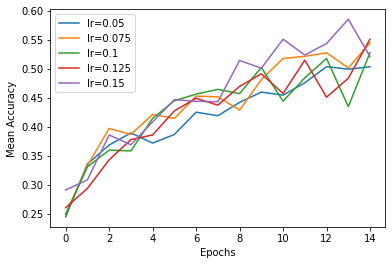

In [ ]:
# dfs = analysis.trial_dataframes
# [d.mean_accuracy.plot(legend=True) for d in dfs.values()]
# for d in dfs.values():
#  print(d.mean_accuracy)
# #print(dfs.values())
# print(analysis.get_all_configs())
ax = None
for d in analysis.trial_dataframes.values():
  ax = d.mean_accuracy.plot(ax=ax)
ax.set_xlabel("Epochs")
ax.set_ylabel("Mean Accuracy")
ax.legend(['lr=0.05', 'lr=0.075', 'lr=0.1', 'lr=0.125', 'lr=0.15'])

In [ ]:
# Config for ResNet hyperparameter sensitivity analysis for lr
config = {
    "lr": tune.grid_search([0.1]),
    "momentum": tune.grid_search([0.5, 0.7, 0.8, 0.9, 0.99]),
    "weight_decay": tune.grid_search([0.0001]),
    "n": tune.grid_search([3]),
    "width": tune.grid_search([1])
}

datasets.CIFAR10("~/data", train=True, download=True)

analysis1 = tune.run(train_cifar, config=config, resources_per_trial={"cpu": 1, "gpu": 1})

Files already downloaded and verified


2022-04-20 22:19:31,995	WARNING callback.py:126 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`
2022-04-20 22:19:32,126	INFO trial_runner.py:803 -- starting train_cifar_f3b6e_00000


(train_cifar pid=7669) Files already downloaded and verified
(train_cifar pid=7669) Files already downloaded and verified


(train_cifar pid=7669) Finished Training epoch 0
Result for train_cifar_f3b6e_00000:
  date: 2022-04-20_22-20-03
  done: false
  experiment_id: 32a206ed474c4056b15e35a04569e623
  hostname: cd7cf695d4cb
  iterations_since_restore: 1
  mean_accuracy: 0.1657
  node_ip: 172.28.0.2
  pid: 7669
  time_since_restore: 29.18149995803833
  time_this_iter_s: 29.18149995803833
  time_total_s: 29.18149995803833
  timestamp: 1650493203
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: f3b6e_00000
  warmup_time: 0.005440235137939453
  
(train_cifar pid=7669) epoch 1 test_loss 179.54332661628723 test_steps 79 test_acc 0.1657


(train_cifar pid=7669) Finished Training epoch 1


Result for train_cifar_f3b6e_00000:
  date: 2022-04-20_22-20-26
  done: false
  experiment_id: 32a206ed474c4056b15e35a04569e623
  hostname: cd7cf695d4cb
  iterations_since_restore: 2
  mean_accuracy: 0.2657
  node_ip: 172.28.0.2
  pid: 7669
  time_since_restore: 51.52564549446106
  time_this_iter_s: 22.34414553642273
  time_total_s: 51.52564549446106
  timestamp: 1650493226
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: f3b6e_00000
  warmup_time: 0.005440235137939453
  
(train_cifar pid=7669) epoch 1 test_loss 173.13435435295105 test_steps 79 test_acc 0.2657


(train_cifar pid=7669) Finished Training epoch 2
Result for train_cifar_f3b6e_00000:
  date: 2022-04-20_22-20-48
  done: false
  experiment_id: 32a206ed474c4056b15e35a04569e623
  hostname: cd7cf695d4cb
  iterations_since_restore: 3
  mean_accuracy: 0.3053
  node_ip: 172.28.0.2
  pid: 7669
  time_since_restore: 74.22799754142761
  time_this_iter_s: 22.702352046966553
  time_total_s: 74.22799754142761
  timestamp: 1650493248
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: f3b6e_00000
  warmup_time: 0.005440235137939453
  
(train_cifar pid=7669) epoch 1 test_loss 169.79440188407898 test_steps 79 test_acc 0.3053


(train_cifar pid=7669) Finished Training epoch 3
Result for train_cifar_f3b6e_00000:
  date: 2022-04-20_22-21-12
  done: false
  experiment_id: 32a206ed474c4056b15e35a04569e623
  hostname: cd7cf695d4cb
  iterations_since_restore: 4
  mean_accuracy: 0.3182
  node_ip: 172.28.0.2
  pid: 7669
  time_since_restore: 97.928386926651
  time_this_iter_s: 23.70038938522339
  time_total_s: 97.928386926651
  timestamp: 1650493272
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: f3b6e_00000
  warmup_time: 0.005440235137939453
  
(train_cifar pid=7669) epoch 1 test_loss 168.72007131576538 test_steps 79 test_acc 0.3182


(train_cifar pid=7669) Finished Training epoch 4
Result for train_cifar_f3b6e_00000:
  date: 2022-04-20_22-21-36
  done: false
  experiment_id: 32a206ed474c4056b15e35a04569e623
  hostname: cd7cf695d4cb
  iterations_since_restore: 5
  mean_accuracy: 0.342
  node_ip: 172.28.0.2
  pid: 7669
  time_since_restore: 121.66377139091492
  time_this_iter_s: 23.735384464263916
  time_total_s: 121.66377139091492
  timestamp: 1650493296
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: f3b6e_00000
  warmup_time: 0.005440235137939453
  
(train_cifar pid=7669) epoch 1 test_loss 166.77202486991882 test_steps 79 test_acc 0.342


(train_cifar pid=7669) Finished Training epoch 5
Result for train_cifar_f3b6e_00000:
  date: 2022-04-20_22-21-59
  done: false
  experiment_id: 32a206ed474c4056b15e35a04569e623
  hostname: cd7cf695d4cb
  iterations_since_restore: 6
  mean_accuracy: 0.3537
  node_ip: 172.28.0.2
  pid: 7669
  time_since_restore: 144.51335096359253
  time_this_iter_s: 22.849579572677612
  time_total_s: 144.51335096359253
  timestamp: 1650493319
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: f3b6e_00000
  warmup_time: 0.005440235137939453
  
(train_cifar pid=7669) epoch 1 test_loss 165.73712491989136 test_steps 79 test_acc 0.3537


(train_cifar pid=7669) Finished Training epoch 6
Result for train_cifar_f3b6e_00000:
  date: 2022-04-20_22-22-22
  done: false
  experiment_id: 32a206ed474c4056b15e35a04569e623
  hostname: cd7cf695d4cb
  iterations_since_restore: 7
  mean_accuracy: 0.3815
  node_ip: 172.28.0.2
  pid: 7669
  time_since_restore: 167.74600958824158
  time_this_iter_s: 23.232658624649048
  time_total_s: 167.74600958824158
  timestamp: 1650493342
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: f3b6e_00000
  warmup_time: 0.005440235137939453
  
(train_cifar pid=7669) epoch 1 test_loss 163.90698981285095 test_steps 79 test_acc 0.3815


(train_cifar pid=7669) Finished Training epoch 7
Result for train_cifar_f3b6e_00000:
  date: 2022-04-20_22-22-45
  done: false
  experiment_id: 32a206ed474c4056b15e35a04569e623
  hostname: cd7cf695d4cb
  iterations_since_restore: 8
  mean_accuracy: 0.3956
  node_ip: 172.28.0.2
  pid: 7669
  time_since_restore: 190.7733895778656
  time_this_iter_s: 23.027379989624023
  time_total_s: 190.7733895778656
  timestamp: 1650493365
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: f3b6e_00000
  warmup_time: 0.005440235137939453
  
(train_cifar pid=7669) epoch 1 test_loss 162.40603685379028 test_steps 79 test_acc 0.3956


(train_cifar pid=7669) Finished Training epoch 8
Result for train_cifar_f3b6e_00000:
  date: 2022-04-20_22-23-07
  done: false
  experiment_id: 32a206ed474c4056b15e35a04569e623
  hostname: cd7cf695d4cb
  iterations_since_restore: 9
  mean_accuracy: 0.4179
  node_ip: 172.28.0.2
  pid: 7669
  time_since_restore: 213.48859119415283
  time_this_iter_s: 22.71520161628723
  time_total_s: 213.48859119415283
  timestamp: 1650493387
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: f3b6e_00000
  warmup_time: 0.005440235137939453
  
(train_cifar pid=7669) epoch 1 test_loss 161.03869998455048 test_steps 79 test_acc 0.4179


(train_cifar pid=7669) Finished Training epoch 9
Result for train_cifar_f3b6e_00000:
  date: 2022-04-20_22-23-30
  done: false
  experiment_id: 32a206ed474c4056b15e35a04569e623
  hostname: cd7cf695d4cb
  iterations_since_restore: 10
  mean_accuracy: 0.4112
  node_ip: 172.28.0.2
  pid: 7669
  time_since_restore: 235.93510580062866
  time_this_iter_s: 22.44651460647583
  time_total_s: 235.93510580062866
  timestamp: 1650493410
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: f3b6e_00000
  warmup_time: 0.005440235137939453
  
(train_cifar pid=7669) epoch 1 test_loss 161.48956537246704 test_steps 79 test_acc 0.4112


(train_cifar pid=7669) Finished Training epoch 10
Result for train_cifar_f3b6e_00000:
  date: 2022-04-20_22-23-52
  done: false
  experiment_id: 32a206ed474c4056b15e35a04569e623
  hostname: cd7cf695d4cb
  iterations_since_restore: 11
  mean_accuracy: 0.3981
  node_ip: 172.28.0.2
  pid: 7669
  time_since_restore: 258.48347902297974
  time_this_iter_s: 22.548373222351074
  time_total_s: 258.48347902297974
  timestamp: 1650493432
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: f3b6e_00000
  warmup_time: 0.005440235137939453
  
(train_cifar pid=7669) epoch 1 test_loss 162.6918157339096 test_steps 79 test_acc 0.3981


(train_cifar pid=7669) Finished Training epoch 11
Result for train_cifar_f3b6e_00000:
  date: 2022-04-20_22-24-15
  done: false
  experiment_id: 32a206ed474c4056b15e35a04569e623
  hostname: cd7cf695d4cb
  iterations_since_restore: 12
  mean_accuracy: 0.4473
  node_ip: 172.28.0.2
  pid: 7669
  time_since_restore: 280.9360067844391
  time_this_iter_s: 22.45252776145935
  time_total_s: 280.9360067844391
  timestamp: 1650493455
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: f3b6e_00000
  warmup_time: 0.005440235137939453
  
(train_cifar pid=7669) epoch 1 test_loss 158.4373322725296 test_steps 79 test_acc 0.4473


(train_cifar pid=7669) Finished Training epoch 12
Result for train_cifar_f3b6e_00000:
  date: 2022-04-20_22-24-37
  done: false
  experiment_id: 32a206ed474c4056b15e35a04569e623
  hostname: cd7cf695d4cb
  iterations_since_restore: 13
  mean_accuracy: 0.4584
  node_ip: 172.28.0.2
  pid: 7669
  time_since_restore: 303.3426003456116
  time_this_iter_s: 22.406593561172485
  time_total_s: 303.3426003456116
  timestamp: 1650493477
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: f3b6e_00000
  warmup_time: 0.005440235137939453
  
(train_cifar pid=7669) epoch 1 test_loss 157.9152113199234 test_steps 79 test_acc 0.4584


(train_cifar pid=7669) Finished Training epoch 13


Result for train_cifar_f3b6e_00000:
  date: 2022-04-20_22-24-59
  done: false
  experiment_id: 32a206ed474c4056b15e35a04569e623
  hostname: cd7cf695d4cb
  iterations_since_restore: 14
  mean_accuracy: 0.4461
  node_ip: 172.28.0.2
  pid: 7669
  time_since_restore: 325.4001157283783
  time_this_iter_s: 22.057515382766724
  time_total_s: 325.4001157283783
  timestamp: 1650493499
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: f3b6e_00000
  warmup_time: 0.005440235137939453
  
(train_cifar pid=7669) epoch 1 test_loss 158.94709861278534 test_steps 79 test_acc 0.4461


(train_cifar pid=7669) Finished Training epoch 14


Result for train_cifar_f3b6e_00000:
  date: 2022-04-20_22-25-21
  done: false
  experiment_id: 32a206ed474c4056b15e35a04569e623
  hostname: cd7cf695d4cb
  iterations_since_restore: 15
  mean_accuracy: 0.4608
  node_ip: 172.28.0.2
  pid: 7669
  time_since_restore: 347.2865717411041
  time_this_iter_s: 21.88645601272583
  time_total_s: 347.2865717411041
  timestamp: 1650493521
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: f3b6e_00000
  warmup_time: 0.005440235137939453
  
Result for train_cifar_f3b6e_00000:
  date: 2022-04-20_22-25-21
  done: true
  experiment_id: 32a206ed474c4056b15e35a04569e623
  experiment_tag: 0_lr=0.1,momentum=0.5,n=3,weight_decay=0.0001,width=1
  hostname: cd7cf695d4cb
  iterations_since_restore: 15
  mean_accuracy: 0.4608
  node_ip: 172.28.0.2
  pid: 7669
  time_since_restore: 347.2865717411041
  time_this_iter_s: 21.88645601272583
  time_total_s: 347.2865717411041
  timestamp: 1650493521
  timesteps_since_restore: 0
  training_iteration: 15
  

2022-04-20 22:25:22,511	INFO trial_runner.py:803 -- starting train_cifar_f3b6e_00001


(train_cifar pid=7814) Files already downloaded and verified
(train_cifar pid=7814) Files already downloaded and verified


(train_cifar pid=7814) Finished Training epoch 0


Result for train_cifar_f3b6e_00001:
  date: 2022-04-20_22-25-52
  done: false
  experiment_id: de4d6a89d8f34f9fbcc698009cb01a0e
  hostname: cd7cf695d4cb
  iterations_since_restore: 1
  mean_accuracy: 0.1731
  node_ip: 172.28.0.2
  pid: 7814
  time_since_restore: 28.052334308624268
  time_this_iter_s: 28.052334308624268
  time_total_s: 28.052334308624268
  timestamp: 1650493552
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: f3b6e_00001
  warmup_time: 0.0032176971435546875
  
(train_cifar pid=7814) epoch 1 test_loss 180.2864499092102 test_steps 79 test_acc 0.1731


(train_cifar pid=7814) Finished Training epoch 1


Result for train_cifar_f3b6e_00001:
  date: 2022-04-20_22-26-14
  done: false
  experiment_id: de4d6a89d8f34f9fbcc698009cb01a0e
  hostname: cd7cf695d4cb
  iterations_since_restore: 2
  mean_accuracy: 0.2682
  node_ip: 172.28.0.2
  pid: 7814
  time_since_restore: 50.02514100074768
  time_this_iter_s: 21.972806692123413
  time_total_s: 50.02514100074768
  timestamp: 1650493574
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: f3b6e_00001
  warmup_time: 0.0032176971435546875
  
(train_cifar pid=7814) epoch 1 test_loss 172.3901424407959 test_steps 79 test_acc 0.2682


(train_cifar pid=7814) Finished Training epoch 2


Result for train_cifar_f3b6e_00001:
  date: 2022-04-20_22-26-36
  done: false
  experiment_id: de4d6a89d8f34f9fbcc698009cb01a0e
  hostname: cd7cf695d4cb
  iterations_since_restore: 3
  mean_accuracy: 0.3211
  node_ip: 172.28.0.2
  pid: 7814
  time_since_restore: 71.95408153533936
  time_this_iter_s: 21.928940534591675
  time_total_s: 71.95408153533936
  timestamp: 1650493596
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: f3b6e_00001
  warmup_time: 0.0032176971435546875
  
(train_cifar pid=7814) epoch 1 test_loss 168.32226061820984 test_steps 79 test_acc 0.3211


(train_cifar pid=7814) Finished Training epoch 3
Result for train_cifar_f3b6e_00001:
  date: 2022-04-20_22-26-59
  done: false
  experiment_id: de4d6a89d8f34f9fbcc698009cb01a0e
  hostname: cd7cf695d4cb
  iterations_since_restore: 4
  mean_accuracy: 0.3679
  node_ip: 172.28.0.2
  pid: 7814
  time_since_restore: 94.68472957611084
  time_this_iter_s: 22.730648040771484
  time_total_s: 94.68472957611084
  timestamp: 1650493619
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: f3b6e_00001
  warmup_time: 0.0032176971435546875
  
(train_cifar pid=7814) epoch 1 test_loss 164.84364140033722 test_steps 79 test_acc 0.3679


(train_cifar pid=7814) Finished Training epoch 4
Result for train_cifar_f3b6e_00001:
  date: 2022-04-20_22-27-22
  done: false
  experiment_id: de4d6a89d8f34f9fbcc698009cb01a0e
  hostname: cd7cf695d4cb
  iterations_since_restore: 5
  mean_accuracy: 0.3679
  node_ip: 172.28.0.2
  pid: 7814
  time_since_restore: 117.53688097000122
  time_this_iter_s: 22.85215139389038
  time_total_s: 117.53688097000122
  timestamp: 1650493642
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: f3b6e_00001
  warmup_time: 0.0032176971435546875
  
(train_cifar pid=7814) epoch 1 test_loss 164.8001652956009 test_steps 79 test_acc 0.3679


(train_cifar pid=7814) Finished Training epoch 5
Result for train_cifar_f3b6e_00001:
  date: 2022-04-20_22-27-44
  done: false
  experiment_id: de4d6a89d8f34f9fbcc698009cb01a0e
  hostname: cd7cf695d4cb
  iterations_since_restore: 6
  mean_accuracy: 0.4042
  node_ip: 172.28.0.2
  pid: 7814
  time_since_restore: 140.10535407066345
  time_this_iter_s: 22.56847310066223
  time_total_s: 140.10535407066345
  timestamp: 1650493664
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: f3b6e_00001
  warmup_time: 0.0032176971435546875
  
(train_cifar pid=7814) epoch 1 test_loss 161.896666765213 test_steps 79 test_acc 0.4042


(train_cifar pid=7814) Finished Training epoch 6
Result for train_cifar_f3b6e_00001:
  date: 2022-04-20_22-28-07
  done: false
  experiment_id: de4d6a89d8f34f9fbcc698009cb01a0e
  hostname: cd7cf695d4cb
  iterations_since_restore: 7
  mean_accuracy: 0.4118
  node_ip: 172.28.0.2
  pid: 7814
  time_since_restore: 163.05093717575073
  time_this_iter_s: 22.94558310508728
  time_total_s: 163.05093717575073
  timestamp: 1650493687
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: f3b6e_00001
  warmup_time: 0.0032176971435546875
  
(train_cifar pid=7814) epoch 1 test_loss 161.50622868537903 test_steps 79 test_acc 0.4118


(train_cifar pid=7814) Finished Training epoch 7
Result for train_cifar_f3b6e_00001:
  date: 2022-04-20_22-28-30
  done: false
  experiment_id: de4d6a89d8f34f9fbcc698009cb01a0e
  hostname: cd7cf695d4cb
  iterations_since_restore: 8
  mean_accuracy: 0.4269
  node_ip: 172.28.0.2
  pid: 7814
  time_since_restore: 185.53192043304443
  time_this_iter_s: 22.4809832572937
  time_total_s: 185.53192043304443
  timestamp: 1650493710
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: f3b6e_00001
  warmup_time: 0.0032176971435546875
  
(train_cifar pid=7814) epoch 1 test_loss 160.36241912841797 test_steps 79 test_acc 0.4269


(train_cifar pid=7814) Finished Training epoch 8


Result for train_cifar_f3b6e_00001:
  date: 2022-04-20_22-28-52
  done: false
  experiment_id: de4d6a89d8f34f9fbcc698009cb01a0e
  hostname: cd7cf695d4cb
  iterations_since_restore: 9
  mean_accuracy: 0.4219
  node_ip: 172.28.0.2
  pid: 7814
  time_since_restore: 207.66912078857422
  time_this_iter_s: 22.137200355529785
  time_total_s: 207.66912078857422
  timestamp: 1650493732
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: f3b6e_00001
  warmup_time: 0.0032176971435546875
  
(train_cifar pid=7814) epoch 1 test_loss 160.81628584861755 test_steps 79 test_acc 0.4219


(train_cifar pid=7814) Finished Training epoch 9


Result for train_cifar_f3b6e_00001:
  date: 2022-04-20_22-29-14
  done: false
  experiment_id: de4d6a89d8f34f9fbcc698009cb01a0e
  hostname: cd7cf695d4cb
  iterations_since_restore: 10
  mean_accuracy: 0.4244
  node_ip: 172.28.0.2
  pid: 7814
  time_since_restore: 229.84871172904968
  time_this_iter_s: 22.179590940475464
  time_total_s: 229.84871172904968
  timestamp: 1650493754
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: f3b6e_00001
  warmup_time: 0.0032176971435546875
  
(train_cifar pid=7814) epoch 1 test_loss 160.14705610275269 test_steps 79 test_acc 0.4244


(train_cifar pid=7814) Finished Training epoch 10


Result for train_cifar_f3b6e_00001:
  date: 2022-04-20_22-29-36
  done: false
  experiment_id: de4d6a89d8f34f9fbcc698009cb01a0e
  hostname: cd7cf695d4cb
  iterations_since_restore: 11
  mean_accuracy: 0.4206
  node_ip: 172.28.0.2
  pid: 7814
  time_since_restore: 252.06416511535645
  time_this_iter_s: 22.215453386306763
  time_total_s: 252.06416511535645
  timestamp: 1650493776
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: f3b6e_00001
  warmup_time: 0.0032176971435546875
  
(train_cifar pid=7814) epoch 1 test_loss 160.85965931415558 test_steps 79 test_acc 0.4206


(train_cifar pid=7814) Finished Training epoch 11
Result for train_cifar_f3b6e_00001:
  date: 2022-04-20_22-29-59
  done: false
  experiment_id: de4d6a89d8f34f9fbcc698009cb01a0e
  hostname: cd7cf695d4cb
  iterations_since_restore: 12
  mean_accuracy: 0.4321
  node_ip: 172.28.0.2
  pid: 7814
  time_since_restore: 274.5869128704071
  time_this_iter_s: 22.52274775505066
  time_total_s: 274.5869128704071
  timestamp: 1650493799
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: f3b6e_00001
  warmup_time: 0.0032176971435546875
  
(train_cifar pid=7814) epoch 1 test_loss 159.8971004486084 test_steps 79 test_acc 0.4321


(train_cifar pid=7814) Finished Training epoch 12


Result for train_cifar_f3b6e_00001:
  date: 2022-04-20_22-30-21
  done: false
  experiment_id: de4d6a89d8f34f9fbcc698009cb01a0e
  hostname: cd7cf695d4cb
  iterations_since_restore: 13
  mean_accuracy: 0.4803
  node_ip: 172.28.0.2
  pid: 7814
  time_since_restore: 296.8633725643158
  time_this_iter_s: 22.27645969390869
  time_total_s: 296.8633725643158
  timestamp: 1650493821
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: f3b6e_00001
  warmup_time: 0.0032176971435546875
  
(train_cifar pid=7814) epoch 1 test_loss 156.09915208816528 test_steps 79 test_acc 0.4803


(train_cifar pid=7814) Finished Training epoch 13


Result for train_cifar_f3b6e_00001:
  date: 2022-04-20_22-30-43
  done: false
  experiment_id: de4d6a89d8f34f9fbcc698009cb01a0e
  hostname: cd7cf695d4cb
  iterations_since_restore: 14
  mean_accuracy: 0.4551
  node_ip: 172.28.0.2
  pid: 7814
  time_since_restore: 319.21214842796326
  time_this_iter_s: 22.34877586364746
  time_total_s: 319.21214842796326
  timestamp: 1650493843
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: f3b6e_00001
  warmup_time: 0.0032176971435546875
  
(train_cifar pid=7814) epoch 1 test_loss 158.29111278057098 test_steps 79 test_acc 0.4551


(train_cifar pid=7814) Finished Training epoch 14


Result for train_cifar_f3b6e_00001:
  date: 2022-04-20_22-31-05
  done: false
  experiment_id: de4d6a89d8f34f9fbcc698009cb01a0e
  hostname: cd7cf695d4cb
  iterations_since_restore: 15
  mean_accuracy: 0.4487
  node_ip: 172.28.0.2
  pid: 7814
  time_since_restore: 340.8393061161041
  time_this_iter_s: 21.62715768814087
  time_total_s: 340.8393061161041
  timestamp: 1650493865
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: f3b6e_00001
  warmup_time: 0.0032176971435546875
  
Result for train_cifar_f3b6e_00001:
  date: 2022-04-20_22-31-05
  done: true
  experiment_id: de4d6a89d8f34f9fbcc698009cb01a0e
  experiment_tag: 1_lr=0.1,momentum=0.7,n=3,weight_decay=0.0001,width=1
  hostname: cd7cf695d4cb
  iterations_since_restore: 15
  mean_accuracy: 0.4487
  node_ip: 172.28.0.2
  pid: 7814
  time_since_restore: 340.8393061161041
  time_this_iter_s: 21.62715768814087
  time_total_s: 340.8393061161041
  timestamp: 1650493865
  timesteps_since_restore: 0
  training_iteration: 15
 

2022-04-20 22:31:06,570	INFO trial_runner.py:803 -- starting train_cifar_f3b6e_00002


(train_cifar pid=7963) Files already downloaded and verified
(train_cifar pid=7963) Files already downloaded and verified


(train_cifar pid=7963) Finished Training epoch 0
Result for train_cifar_f3b6e_00002:
  date: 2022-04-20_22-31-36
  done: false
  experiment_id: 60d15209a9ea45218c1e27780842275c
  hostname: cd7cf695d4cb
  iterations_since_restore: 1
  mean_accuracy: 0.2048
  node_ip: 172.28.0.2
  pid: 7963
  time_since_restore: 27.51023530960083
  time_this_iter_s: 27.51023530960083
  time_total_s: 27.51023530960083
  timestamp: 1650493896
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: f3b6e_00002
  warmup_time: 0.002949953079223633
  
(train_cifar pid=7963) epoch 1 test_loss 179.10313320159912 test_steps 79 test_acc 0.2048


(train_cifar pid=7963) Finished Training epoch 1


Result for train_cifar_f3b6e_00002:
  date: 2022-04-20_22-31-57
  done: false
  experiment_id: 60d15209a9ea45218c1e27780842275c
  hostname: cd7cf695d4cb
  iterations_since_restore: 2
  mean_accuracy: 0.3392
  node_ip: 172.28.0.2
  pid: 7963
  time_since_restore: 49.00649309158325
  time_this_iter_s: 21.496257781982422
  time_total_s: 49.00649309158325
  timestamp: 1650493917
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: f3b6e_00002
  warmup_time: 0.002949953079223633
  
(train_cifar pid=7963) epoch 1 test_loss 167.13850688934326 test_steps 79 test_acc 0.3392


(train_cifar pid=7963) Finished Training epoch 2


Result for train_cifar_f3b6e_00002:
  date: 2022-04-20_22-32-18
  done: false
  experiment_id: 60d15209a9ea45218c1e27780842275c
  hostname: cd7cf695d4cb
  iterations_since_restore: 3
  mean_accuracy: 0.3754
  node_ip: 172.28.0.2
  pid: 7963
  time_since_restore: 70.19114828109741
  time_this_iter_s: 21.18465518951416
  time_total_s: 70.19114828109741
  timestamp: 1650493938
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: f3b6e_00002
  warmup_time: 0.002949953079223633
  
(train_cifar pid=7963) epoch 1 test_loss 164.24006009101868 test_steps 79 test_acc 0.3754


(train_cifar pid=7963) Finished Training epoch 3


Result for train_cifar_f3b6e_00002:
  date: 2022-04-20_22-32-40
  done: false
  experiment_id: 60d15209a9ea45218c1e27780842275c
  hostname: cd7cf695d4cb
  iterations_since_restore: 4
  mean_accuracy: 0.4183
  node_ip: 172.28.0.2
  pid: 7963
  time_since_restore: 91.45355415344238
  time_this_iter_s: 21.26240587234497
  time_total_s: 91.45355415344238
  timestamp: 1650493960
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: f3b6e_00002
  warmup_time: 0.002949953079223633
  
(train_cifar pid=7963) epoch 1 test_loss 160.82301568984985 test_steps 79 test_acc 0.4183


(train_cifar pid=7963) Finished Training epoch 4


Result for train_cifar_f3b6e_00002:
  date: 2022-04-20_22-33-01
  done: false
  experiment_id: 60d15209a9ea45218c1e27780842275c
  hostname: cd7cf695d4cb
  iterations_since_restore: 5
  mean_accuracy: 0.4314
  node_ip: 172.28.0.2
  pid: 7963
  time_since_restore: 112.88275790214539
  time_this_iter_s: 21.429203748703003
  time_total_s: 112.88275790214539
  timestamp: 1650493981
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: f3b6e_00002
  warmup_time: 0.002949953079223633
  
(train_cifar pid=7963) epoch 1 test_loss 160.00373029708862 test_steps 79 test_acc 0.4314


(train_cifar pid=7963) Finished Training epoch 5


Result for train_cifar_f3b6e_00002:
  date: 2022-04-20_22-33-23
  done: false
  experiment_id: 60d15209a9ea45218c1e27780842275c
  hostname: cd7cf695d4cb
  iterations_since_restore: 6
  mean_accuracy: 0.4476
  node_ip: 172.28.0.2
  pid: 7963
  time_since_restore: 134.40231585502625
  time_this_iter_s: 21.51955795288086
  time_total_s: 134.40231585502625
  timestamp: 1650494003
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: f3b6e_00002
  warmup_time: 0.002949953079223633
  
(train_cifar pid=7963) epoch 1 test_loss 158.7804307937622 test_steps 79 test_acc 0.4476


(train_cifar pid=7963) Finished Training epoch 6


Result for train_cifar_f3b6e_00002:
  date: 2022-04-20_22-33-44
  done: false
  experiment_id: 60d15209a9ea45218c1e27780842275c
  hostname: cd7cf695d4cb
  iterations_since_restore: 7
  mean_accuracy: 0.4834
  node_ip: 172.28.0.2
  pid: 7963
  time_since_restore: 155.858069896698
  time_this_iter_s: 21.455754041671753
  time_total_s: 155.858069896698
  timestamp: 1650494024
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: f3b6e_00002
  warmup_time: 0.002949953079223633
  
(train_cifar pid=7963) epoch 1 test_loss 155.94157326221466 test_steps 79 test_acc 0.4834


(train_cifar pid=7963) Finished Training epoch 7


Result for train_cifar_f3b6e_00002:
  date: 2022-04-20_22-34-06
  done: false
  experiment_id: 60d15209a9ea45218c1e27780842275c
  hostname: cd7cf695d4cb
  iterations_since_restore: 8
  mean_accuracy: 0.4792
  node_ip: 172.28.0.2
  pid: 7963
  time_since_restore: 177.21317601203918
  time_this_iter_s: 21.355106115341187
  time_total_s: 177.21317601203918
  timestamp: 1650494046
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: f3b6e_00002
  warmup_time: 0.002949953079223633
  
(train_cifar pid=7963) epoch 1 test_loss 156.1002982854843 test_steps 79 test_acc 0.4792


(train_cifar pid=7963) Finished Training epoch 8


Result for train_cifar_f3b6e_00002:
  date: 2022-04-20_22-34-27
  done: false
  experiment_id: 60d15209a9ea45218c1e27780842275c
  hostname: cd7cf695d4cb
  iterations_since_restore: 9
  mean_accuracy: 0.5104
  node_ip: 172.28.0.2
  pid: 7963
  time_since_restore: 198.7239851951599
  time_this_iter_s: 21.510809183120728
  time_total_s: 198.7239851951599
  timestamp: 1650494067
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: f3b6e_00002
  warmup_time: 0.002949953079223633
  
(train_cifar pid=7963) epoch 1 test_loss 154.03152918815613 test_steps 79 test_acc 0.5104


(train_cifar pid=7963) Finished Training epoch 9


Result for train_cifar_f3b6e_00002:
  date: 2022-04-20_22-34-49
  done: false
  experiment_id: 60d15209a9ea45218c1e27780842275c
  hostname: cd7cf695d4cb
  iterations_since_restore: 10
  mean_accuracy: 0.5343
  node_ip: 172.28.0.2
  pid: 7963
  time_since_restore: 220.2165985107422
  time_this_iter_s: 21.492613315582275
  time_total_s: 220.2165985107422
  timestamp: 1650494089
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: f3b6e_00002
  warmup_time: 0.002949953079223633
  
(train_cifar pid=7963) epoch 1 test_loss 151.7895007133484 test_steps 79 test_acc 0.5343


(train_cifar pid=7963) Finished Training epoch 10


Result for train_cifar_f3b6e_00002:
  date: 2022-04-20_22-35-10
  done: false
  experiment_id: 60d15209a9ea45218c1e27780842275c
  hostname: cd7cf695d4cb
  iterations_since_restore: 11
  mean_accuracy: 0.5387
  node_ip: 172.28.0.2
  pid: 7963
  time_since_restore: 241.75444912910461
  time_this_iter_s: 21.537850618362427
  time_total_s: 241.75444912910461
  timestamp: 1650494110
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: f3b6e_00002
  warmup_time: 0.002949953079223633
  
(train_cifar pid=7963) epoch 1 test_loss 151.58780920505524 test_steps 79 test_acc 0.5387


(train_cifar pid=7963) Finished Training epoch 11


Result for train_cifar_f3b6e_00002:
  date: 2022-04-20_22-35-32
  done: false
  experiment_id: 60d15209a9ea45218c1e27780842275c
  hostname: cd7cf695d4cb
  iterations_since_restore: 12
  mean_accuracy: 0.5372
  node_ip: 172.28.0.2
  pid: 7963
  time_since_restore: 263.21342849731445
  time_this_iter_s: 21.45897936820984
  time_total_s: 263.21342849731445
  timestamp: 1650494132
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: f3b6e_00002
  warmup_time: 0.002949953079223633
  
(train_cifar pid=7963) epoch 1 test_loss 151.56985068321228 test_steps 79 test_acc 0.5372


(train_cifar pid=7963) Finished Training epoch 12


Result for train_cifar_f3b6e_00002:
  date: 2022-04-20_22-35-53
  done: false
  experiment_id: 60d15209a9ea45218c1e27780842275c
  hostname: cd7cf695d4cb
  iterations_since_restore: 13
  mean_accuracy: 0.5364
  node_ip: 172.28.0.2
  pid: 7963
  time_since_restore: 284.79635095596313
  time_this_iter_s: 21.58292245864868
  time_total_s: 284.79635095596313
  timestamp: 1650494153
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: f3b6e_00002
  warmup_time: 0.002949953079223633
  
(train_cifar pid=7963) epoch 1 test_loss 151.9154635667801 test_steps 79 test_acc 0.5364


(train_cifar pid=7963) Finished Training epoch 13


Result for train_cifar_f3b6e_00002:
  date: 2022-04-20_22-36-15
  done: false
  experiment_id: 60d15209a9ea45218c1e27780842275c
  hostname: cd7cf695d4cb
  iterations_since_restore: 14
  mean_accuracy: 0.5314
  node_ip: 172.28.0.2
  pid: 7963
  time_since_restore: 306.5005328655243
  time_this_iter_s: 21.704181909561157
  time_total_s: 306.5005328655243
  timestamp: 1650494175
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: f3b6e_00002
  warmup_time: 0.002949953079223633
  
(train_cifar pid=7963) epoch 1 test_loss 151.8540759086609 test_steps 79 test_acc 0.5314


(train_cifar pid=7963) Finished Training epoch 14


Result for train_cifar_f3b6e_00002:
  date: 2022-04-20_22-36-36
  done: false
  experiment_id: 60d15209a9ea45218c1e27780842275c
  hostname: cd7cf695d4cb
  iterations_since_restore: 15
  mean_accuracy: 0.5609
  node_ip: 172.28.0.2
  pid: 7963
  time_since_restore: 328.1701316833496
  time_this_iter_s: 21.669598817825317
  time_total_s: 328.1701316833496
  timestamp: 1650494196
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: f3b6e_00002
  warmup_time: 0.002949953079223633
  
Result for train_cifar_f3b6e_00002:
  date: 2022-04-20_22-36-36
  done: true
  experiment_id: 60d15209a9ea45218c1e27780842275c
  experiment_tag: 2_lr=0.1,momentum=0.8,n=3,weight_decay=0.0001,width=1
  hostname: cd7cf695d4cb
  iterations_since_restore: 15
  mean_accuracy: 0.5609
  node_ip: 172.28.0.2
  pid: 7963
  time_since_restore: 328.1701316833496
  time_this_iter_s: 21.669598817825317
  time_total_s: 328.1701316833496
  timestamp: 1650494196
  timesteps_since_restore: 0
  training_iteration: 15


2022-04-20 22:36:37,627	INFO trial_runner.py:803 -- starting train_cifar_f3b6e_00003


(train_cifar pid=8101) Files already downloaded and verified
(train_cifar pid=8101) Files already downloaded and verified


(train_cifar pid=8101) Finished Training epoch 0
Result for train_cifar_f3b6e_00003:
  date: 2022-04-20_22-37-07
  done: false
  experiment_id: c166a6568c954b4f8dba090b9de4d79e
  hostname: cd7cf695d4cb
  iterations_since_restore: 1
  mean_accuracy: 0.2445
  node_ip: 172.28.0.2
  pid: 8101
  time_since_restore: 27.39665126800537
  time_this_iter_s: 27.39665126800537
  time_total_s: 27.39665126800537
  timestamp: 1650494227
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: f3b6e_00003
  warmup_time: 0.0033407211303710938
  
(train_cifar pid=8101) epoch 1 test_loss 173.41117548942566 test_steps 79 test_acc 0.2445


(train_cifar pid=8101) Finished Training epoch 1


Result for train_cifar_f3b6e_00003:
  date: 2022-04-20_22-37-28
  done: false
  experiment_id: c166a6568c954b4f8dba090b9de4d79e
  hostname: cd7cf695d4cb
  iterations_since_restore: 2
  mean_accuracy: 0.3174
  node_ip: 172.28.0.2
  pid: 8101
  time_since_restore: 48.87167048454285
  time_this_iter_s: 21.475019216537476
  time_total_s: 48.87167048454285
  timestamp: 1650494248
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: f3b6e_00003
  warmup_time: 0.0033407211303710938
  
(train_cifar pid=8101) epoch 1 test_loss 168.2845697402954 test_steps 79 test_acc 0.3174


(train_cifar pid=8101) Finished Training epoch 2


Result for train_cifar_f3b6e_00003:
  date: 2022-04-20_22-37-50
  done: false
  experiment_id: c166a6568c954b4f8dba090b9de4d79e
  hostname: cd7cf695d4cb
  iterations_since_restore: 3
  mean_accuracy: 0.3586
  node_ip: 172.28.0.2
  pid: 8101
  time_since_restore: 70.33941698074341
  time_this_iter_s: 21.46774649620056
  time_total_s: 70.33941698074341
  timestamp: 1650494270
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: f3b6e_00003
  warmup_time: 0.0033407211303710938
  
(train_cifar pid=8101) epoch 1 test_loss 165.5639524459839 test_steps 79 test_acc 0.3586


(train_cifar pid=8101) Finished Training epoch 3


Result for train_cifar_f3b6e_00003:
  date: 2022-04-20_22-38-11
  done: false
  experiment_id: c166a6568c954b4f8dba090b9de4d79e
  hostname: cd7cf695d4cb
  iterations_since_restore: 4
  mean_accuracy: 0.3977
  node_ip: 172.28.0.2
  pid: 8101
  time_since_restore: 91.73747968673706
  time_this_iter_s: 21.398062705993652
  time_total_s: 91.73747968673706
  timestamp: 1650494291
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: f3b6e_00003
  warmup_time: 0.0033407211303710938
  
(train_cifar pid=8101) epoch 1 test_loss 162.4489792585373 test_steps 79 test_acc 0.3977


(train_cifar pid=8101) Finished Training epoch 4


Result for train_cifar_f3b6e_00003:
  date: 2022-04-20_22-38-33
  done: false
  experiment_id: c166a6568c954b4f8dba090b9de4d79e
  hostname: cd7cf695d4cb
  iterations_since_restore: 5
  mean_accuracy: 0.3598
  node_ip: 172.28.0.2
  pid: 8101
  time_since_restore: 113.31949162483215
  time_this_iter_s: 21.582011938095093
  time_total_s: 113.31949162483215
  timestamp: 1650494313
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: f3b6e_00003
  warmup_time: 0.0033407211303710938
  (train_cifar pid=8101) epoch 1 test_loss 165.30054783821106 test_steps 79 test_acc 0.3598



(train_cifar pid=8101) Finished Training epoch 5


Result for train_cifar_f3b6e_00003:
  date: 2022-04-20_22-38-54
  done: false
  experiment_id: c166a6568c954b4f8dba090b9de4d79e
  hostname: cd7cf695d4cb
  iterations_since_restore: 6
  mean_accuracy: 0.4014
  node_ip: 172.28.0.2
  pid: 8101
  time_since_restore: 134.90697813034058
  time_this_iter_s: 21.587486505508423
  time_total_s: 134.90697813034058
  timestamp: 1650494334
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: f3b6e_00003
  warmup_time: 0.0033407211303710938
  
(train_cifar pid=8101) epoch 1 test_loss 162.38115119934082 test_steps 79 test_acc 0.4014


(train_cifar pid=8101) Finished Training epoch 6


Result for train_cifar_f3b6e_00003:
  date: 2022-04-20_22-39-16
  done: false
  experiment_id: c166a6568c954b4f8dba090b9de4d79e
  hostname: cd7cf695d4cb
  iterations_since_restore: 7
  mean_accuracy: 0.4348
  node_ip: 172.28.0.2
  pid: 8101
  time_since_restore: 156.20961165428162
  time_this_iter_s: 21.30263352394104
  time_total_s: 156.20961165428162
  timestamp: 1650494356
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: f3b6e_00003
  warmup_time: 0.0033407211303710938
  
(train_cifar pid=8101) epoch 1 test_loss 159.5862318277359 test_steps 79 test_acc 0.4348


(train_cifar pid=8101) Finished Training epoch 7


Result for train_cifar_f3b6e_00003:
  date: 2022-04-20_22-39-37
  done: false
  experiment_id: c166a6568c954b4f8dba090b9de4d79e
  hostname: cd7cf695d4cb
  iterations_since_restore: 8
  mean_accuracy: 0.4326
  node_ip: 172.28.0.2
  pid: 8101
  time_since_restore: 177.5063180923462
  time_this_iter_s: 21.296706438064575
  time_total_s: 177.5063180923462
  timestamp: 1650494377
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: f3b6e_00003
  warmup_time: 0.0033407211303710938
  
(train_cifar pid=8101) epoch 1 test_loss 159.78426229953766 test_steps 79 test_acc 0.4326


(train_cifar pid=8101) Finished Training epoch 8


Result for train_cifar_f3b6e_00003:
  date: 2022-04-20_22-39-58
  done: false
  experiment_id: c166a6568c954b4f8dba090b9de4d79e
  hostname: cd7cf695d4cb
  iterations_since_restore: 9
  mean_accuracy: 0.4609
  node_ip: 172.28.0.2
  pid: 8101
  time_since_restore: 198.94805431365967
  time_this_iter_s: 21.441736221313477
  time_total_s: 198.94805431365967
  timestamp: 1650494398
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: f3b6e_00003
  warmup_time: 0.0033407211303710938
  
(train_cifar pid=8101) epoch 1 test_loss 157.7533677816391 test_steps 79 test_acc 0.4609


(train_cifar pid=8101) Finished Training epoch 9


Result for train_cifar_f3b6e_00003:
  date: 2022-04-20_22-40-20
  done: false
  experiment_id: c166a6568c954b4f8dba090b9de4d79e
  hostname: cd7cf695d4cb
  iterations_since_restore: 10
  mean_accuracy: 0.4613
  node_ip: 172.28.0.2
  pid: 8101
  time_since_restore: 220.638174533844
  time_this_iter_s: 21.690120220184326
  time_total_s: 220.638174533844
  timestamp: 1650494420
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: f3b6e_00003
  warmup_time: 0.0033407211303710938
  
(train_cifar pid=8101) epoch 1 test_loss 157.62179553508759 test_steps 79 test_acc 0.4613


(train_cifar pid=8101) Finished Training epoch 10


Result for train_cifar_f3b6e_00003:
  date: 2022-04-20_22-40-42
  done: false
  experiment_id: c166a6568c954b4f8dba090b9de4d79e
  hostname: cd7cf695d4cb
  iterations_since_restore: 11
  mean_accuracy: 0.4925
  node_ip: 172.28.0.2
  pid: 8101
  time_since_restore: 242.39486384391785
  time_this_iter_s: 21.756689310073853
  time_total_s: 242.39486384391785
  timestamp: 1650494442
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: f3b6e_00003
  warmup_time: 0.0033407211303710938
  
(train_cifar pid=8101) epoch 1 test_loss 155.36064553260803 test_steps 79 test_acc 0.4925


(train_cifar pid=8101) Finished Training epoch 11


Result for train_cifar_f3b6e_00003:
  date: 2022-04-20_22-41-03
  done: false
  experiment_id: c166a6568c954b4f8dba090b9de4d79e
  hostname: cd7cf695d4cb
  iterations_since_restore: 12
  mean_accuracy: 0.4875
  node_ip: 172.28.0.2
  pid: 8101
  time_since_restore: 264.033264875412
  time_this_iter_s: 21.63840103149414
  time_total_s: 264.033264875412
  timestamp: 1650494463
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: f3b6e_00003
  warmup_time: 0.0033407211303710938
  
(train_cifar pid=8101) epoch 1 test_loss 155.59026658535004 test_steps 79 test_acc 0.4875


(train_cifar pid=8101) Finished Training epoch 12


Result for train_cifar_f3b6e_00003:
  date: 2022-04-20_22-41-25
  done: false
  experiment_id: c166a6568c954b4f8dba090b9de4d79e
  hostname: cd7cf695d4cb
  iterations_since_restore: 13
  mean_accuracy: 0.4822
  node_ip: 172.28.0.2
  pid: 8101
  time_since_restore: 285.4472665786743
  time_this_iter_s: 21.41400170326233
  time_total_s: 285.4472665786743
  timestamp: 1650494485
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: f3b6e_00003
  warmup_time: 0.0033407211303710938
  
(train_cifar pid=8101) epoch 1 test_loss 155.82578790187836 test_steps 79 test_acc 0.4822


(train_cifar pid=8101) Finished Training epoch 13


Result for train_cifar_f3b6e_00003:
  date: 2022-04-20_22-41-46
  done: false
  experiment_id: c166a6568c954b4f8dba090b9de4d79e
  hostname: cd7cf695d4cb
  iterations_since_restore: 14
  mean_accuracy: 0.5177
  node_ip: 172.28.0.2
  pid: 8101
  time_since_restore: 306.90515780448914
  time_this_iter_s: 21.45789122581482
  time_total_s: 306.90515780448914
  timestamp: 1650494506
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: f3b6e_00003
  warmup_time: 0.0033407211303710938
  
(train_cifar pid=8101) epoch 1 test_loss 153.1027660369873 test_steps 79 test_acc 0.5177


(train_cifar pid=8101) Finished Training epoch 14


Result for train_cifar_f3b6e_00003:
  date: 2022-04-20_22-42-08
  done: false
  experiment_id: c166a6568c954b4f8dba090b9de4d79e
  hostname: cd7cf695d4cb
  iterations_since_restore: 15
  mean_accuracy: 0.4968
  node_ip: 172.28.0.2
  pid: 8101
  time_since_restore: 328.41733741760254
  time_this_iter_s: 21.512179613113403
  time_total_s: 328.41733741760254
  timestamp: 1650494528
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: f3b6e_00003
  warmup_time: 0.0033407211303710938
  
Result for train_cifar_f3b6e_00003:
  date: 2022-04-20_22-42-08
  done: true
  experiment_id: c166a6568c954b4f8dba090b9de4d79e
  experiment_tag: 3_lr=0.1,momentum=0.9,n=3,weight_decay=0.0001,width=1
  hostname: cd7cf695d4cb
  iterations_since_restore: 15
  mean_accuracy: 0.4968
  node_ip: 172.28.0.2
  pid: 8101
  time_since_restore: 328.41733741760254
  time_this_iter_s: 21.512179613113403
  time_total_s: 328.41733741760254
  timestamp: 1650494528
  timesteps_since_restore: 0
  training_iteration

2022-04-20 22:42:08,688	INFO trial_runner.py:803 -- starting train_cifar_f3b6e_00004


(train_cifar pid=8235) Files already downloaded and verified
(train_cifar pid=8235) Files already downloaded and verified


(train_cifar pid=8235) Finished Training epoch 0
Result for train_cifar_f3b6e_00004:
  date: 2022-04-20_22-42-38
  done: false
  experiment_id: 4a8adf1f4a58467787044d40d8342b43
  hostname: cd7cf695d4cb
  iterations_since_restore: 1
  mean_accuracy: 0.3368
  node_ip: 172.28.0.2
  pid: 8235
  time_since_restore: 27.61854577064514
  time_this_iter_s: 27.61854577064514
  time_total_s: 27.61854577064514
  timestamp: 1650494558
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: f3b6e_00004
  warmup_time: 0.003113985061645508
  
(train_cifar pid=8235) epoch 1 test_loss 167.06420874595642 test_steps 79 test_acc 0.3368


(train_cifar pid=8235) Finished Training epoch 1


Result for train_cifar_f3b6e_00004:
  date: 2022-04-20_22-43-00
  done: false
  experiment_id: 4a8adf1f4a58467787044d40d8342b43
  hostname: cd7cf695d4cb
  iterations_since_restore: 2
  mean_accuracy: 0.211
  node_ip: 172.28.0.2
  pid: 8235
  time_since_restore: 49.24160075187683
  time_this_iter_s: 21.62305498123169
  time_total_s: 49.24160075187683
  timestamp: 1650494580
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: f3b6e_00004
  warmup_time: 0.003113985061645508
  
(train_cifar pid=8235) epoch 1 test_loss 176.98787760734558 test_steps 79 test_acc 0.211


(train_cifar pid=8235) Finished Training epoch 2


Result for train_cifar_f3b6e_00004:
  date: 2022-04-20_22-43-21
  done: false
  experiment_id: 4a8adf1f4a58467787044d40d8342b43
  hostname: cd7cf695d4cb
  iterations_since_restore: 3
  mean_accuracy: 0.2984
  node_ip: 172.28.0.2
  pid: 8235
  time_since_restore: 70.7294340133667
  time_this_iter_s: 21.487833261489868
  time_total_s: 70.7294340133667
  timestamp: 1650494601
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: f3b6e_00004
  warmup_time: 0.003113985061645508
  
(train_cifar pid=8235) epoch 1 test_loss 169.73114013671875 test_steps 79 test_acc 0.2984


(train_cifar pid=8235) Finished Training epoch 3


Result for train_cifar_f3b6e_00004:
  date: 2022-04-20_22-43-43
  done: false
  experiment_id: 4a8adf1f4a58467787044d40d8342b43
  hostname: cd7cf695d4cb
  iterations_since_restore: 4
  mean_accuracy: 0.3384
  node_ip: 172.28.0.2
  pid: 8235
  time_since_restore: 92.3668360710144
  time_this_iter_s: 21.637402057647705
  time_total_s: 92.3668360710144
  timestamp: 1650494623
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: f3b6e_00004
  warmup_time: 0.003113985061645508
  
(train_cifar pid=8235) epoch 1 test_loss 167.0273380279541 test_steps 79 test_acc 0.3384


(train_cifar pid=8235) Finished Training epoch 4


Result for train_cifar_f3b6e_00004:
  date: 2022-04-20_22-44-05
  done: false
  experiment_id: 4a8adf1f4a58467787044d40d8342b43
  hostname: cd7cf695d4cb
  iterations_since_restore: 5
  mean_accuracy: 0.31
  node_ip: 172.28.0.2
  pid: 8235
  time_since_restore: 114.0981376171112
  time_this_iter_s: 21.7313015460968
  time_total_s: 114.0981376171112
  timestamp: 1650494645
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: f3b6e_00004
  warmup_time: 0.003113985061645508
  
(train_cifar pid=8235) epoch 1 test_loss 169.3972214460373 test_steps 79 test_acc 0.31


(train_cifar pid=8235) Finished Training epoch 5


Result for train_cifar_f3b6e_00004:
  date: 2022-04-20_22-44-26
  done: false
  experiment_id: 4a8adf1f4a58467787044d40d8342b43
  hostname: cd7cf695d4cb
  iterations_since_restore: 6
  mean_accuracy: 0.3853
  node_ip: 172.28.0.2
  pid: 8235
  time_since_restore: 135.49939966201782
  time_this_iter_s: 21.401262044906616
  time_total_s: 135.49939966201782
  timestamp: 1650494666
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: f3b6e_00004
  warmup_time: 0.003113985061645508
  
(train_cifar pid=8235) epoch 1 test_loss 163.38291561603546 test_steps 79 test_acc 0.3853


(train_cifar pid=8235) Finished Training epoch 6


Result for train_cifar_f3b6e_00004:
  date: 2022-04-20_22-44-47
  done: false
  experiment_id: 4a8adf1f4a58467787044d40d8342b43
  hostname: cd7cf695d4cb
  iterations_since_restore: 7
  mean_accuracy: 0.4061
  node_ip: 172.28.0.2
  pid: 8235
  time_since_restore: 156.94309377670288
  time_this_iter_s: 21.44369411468506
  time_total_s: 156.94309377670288
  timestamp: 1650494687
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: f3b6e_00004
  warmup_time: 0.003113985061645508
  
(train_cifar pid=8235) epoch 1 test_loss 161.92558825016022 test_steps 79 test_acc 0.4061


(train_cifar pid=8235) Finished Training epoch 7


Result for train_cifar_f3b6e_00004:
  date: 2022-04-20_22-45-09
  done: false
  experiment_id: 4a8adf1f4a58467787044d40d8342b43
  hostname: cd7cf695d4cb
  iterations_since_restore: 8
  mean_accuracy: 0.4287
  node_ip: 172.28.0.2
  pid: 8235
  time_since_restore: 178.47104835510254
  time_this_iter_s: 21.527954578399658
  time_total_s: 178.47104835510254
  timestamp: 1650494709
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: f3b6e_00004
  warmup_time: 0.003113985061645508
  
(train_cifar pid=8235) epoch 1 test_loss 160.43565452098846 test_steps 79 test_acc 0.4287


(train_cifar pid=8235) Finished Training epoch 8


Result for train_cifar_f3b6e_00004:
  date: 2022-04-20_22-45-31
  done: false
  experiment_id: 4a8adf1f4a58467787044d40d8342b43
  hostname: cd7cf695d4cb
  iterations_since_restore: 9
  mean_accuracy: 0.4024
  node_ip: 172.28.0.2
  pid: 8235
  time_since_restore: 200.20057320594788
  time_this_iter_s: 21.729524850845337
  time_total_s: 200.20057320594788
  timestamp: 1650494731
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: f3b6e_00004
  warmup_time: 0.003113985061645508
  
(train_cifar pid=8235) epoch 1 test_loss 162.20021319389343 test_steps 79 test_acc 0.4024


(train_cifar pid=8235) Finished Training epoch 9


Result for train_cifar_f3b6e_00004:
  date: 2022-04-20_22-45-52
  done: false
  experiment_id: 4a8adf1f4a58467787044d40d8342b43
  hostname: cd7cf695d4cb
  iterations_since_restore: 10
  mean_accuracy: 0.4502
  node_ip: 172.28.0.2
  pid: 8235
  time_since_restore: 222.02694654464722
  time_this_iter_s: 21.82637333869934
  time_total_s: 222.02694654464722
  timestamp: 1650494752
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: f3b6e_00004
  warmup_time: 0.003113985061645508
  
(train_cifar pid=8235) epoch 1 test_loss 158.38460540771484 test_steps 79 test_acc 0.4502


(train_cifar pid=8235) Finished Training epoch 10


Result for train_cifar_f3b6e_00004:
  date: 2022-04-20_22-46-14
  done: false
  experiment_id: 4a8adf1f4a58467787044d40d8342b43
  hostname: cd7cf695d4cb
  iterations_since_restore: 11
  mean_accuracy: 0.3862
  node_ip: 172.28.0.2
  pid: 8235
  time_since_restore: 243.48189735412598
  time_this_iter_s: 21.45495080947876
  time_total_s: 243.48189735412598
  timestamp: 1650494774
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: f3b6e_00004
  warmup_time: 0.003113985061645508
  
(train_cifar pid=8235) epoch 1 test_loss 163.26312828063965 test_steps 79 test_acc 0.3862


(train_cifar pid=8235) Finished Training epoch 11


Result for train_cifar_f3b6e_00004:
  date: 2022-04-20_22-46-35
  done: false
  experiment_id: 4a8adf1f4a58467787044d40d8342b43
  hostname: cd7cf695d4cb
  iterations_since_restore: 12
  mean_accuracy: 0.4489
  node_ip: 172.28.0.2
  pid: 8235
  time_since_restore: 264.93945503234863
  time_this_iter_s: 21.457557678222656
  time_total_s: 264.93945503234863
  timestamp: 1650494795
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: f3b6e_00004
  warmup_time: 0.003113985061645508
  
(train_cifar pid=8235) epoch 1 test_loss 158.45115041732788 test_steps 79 test_acc 0.4489


(train_cifar pid=8235) Finished Training epoch 12


Result for train_cifar_f3b6e_00004:
  date: 2022-04-20_22-46-57
  done: false
  experiment_id: 4a8adf1f4a58467787044d40d8342b43
  hostname: cd7cf695d4cb
  iterations_since_restore: 13
  mean_accuracy: 0.4818
  node_ip: 172.28.0.2
  pid: 8235
  time_since_restore: 286.380743265152
  time_this_iter_s: 21.441288232803345
  time_total_s: 286.380743265152
  timestamp: 1650494817
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: f3b6e_00004
  warmup_time: 0.003113985061645508
  
(train_cifar pid=8235) epoch 1 test_loss 156.08000874519348 test_steps 79 test_acc 0.4818


(train_cifar pid=8235) Finished Training epoch 13


Result for train_cifar_f3b6e_00004:
  date: 2022-04-20_22-47-18
  done: false
  experiment_id: 4a8adf1f4a58467787044d40d8342b43
  hostname: cd7cf695d4cb
  iterations_since_restore: 14
  mean_accuracy: 0.4733
  node_ip: 172.28.0.2
  pid: 8235
  time_since_restore: 307.95985078811646
  time_this_iter_s: 21.579107522964478
  time_total_s: 307.95985078811646
  timestamp: 1650494838
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: f3b6e_00004
  warmup_time: 0.003113985061645508
  
(train_cifar pid=8235) epoch 1 test_loss 156.68380415439606 test_steps 79 test_acc 0.4733


(train_cifar pid=8235) Finished Training epoch 14


Result for train_cifar_f3b6e_00004:
  date: 2022-04-20_22-47-40
  done: false
  experiment_id: 4a8adf1f4a58467787044d40d8342b43
  hostname: cd7cf695d4cb
  iterations_since_restore: 15
  mean_accuracy: 0.5334
  node_ip: 172.28.0.2
  pid: 8235
  time_since_restore: 329.4963254928589
  time_this_iter_s: 21.53647470474243
  time_total_s: 329.4963254928589
  timestamp: 1650494860
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: f3b6e_00004
  warmup_time: 0.003113985061645508
  
Result for train_cifar_f3b6e_00004:
  date: 2022-04-20_22-47-40
  done: true
  experiment_id: 4a8adf1f4a58467787044d40d8342b43
  experiment_tag: 4_lr=0.1,momentum=0.99,n=3,weight_decay=0.0001,width=1
  hostname: cd7cf695d4cb
  iterations_since_restore: 15
  mean_accuracy: 0.5334
  node_ip: 172.28.0.2
  pid: 8235
  time_since_restore: 329.4963254928589
  time_this_iter_s: 21.53647470474243
  time_total_s: 329.4963254928589
  timestamp: 1650494860
  timesteps_since_restore: 0
  training_iteration: 15
 

2022-04-20 22:47:40,576	INFO tune.py:702 -- Total run time: 1688.60 seconds (1688.44 seconds for the tuning loop).


(train_cifar pid=8235) epoch 1 test_loss 152.34106123447418 test_steps 79 test_acc 0.5334


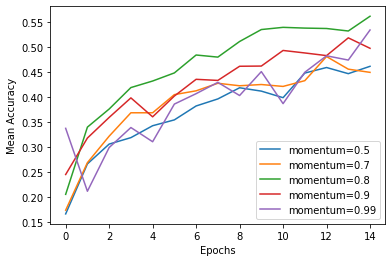

In [ ]:
ax = None
for d in analysis1.trial_dataframes.values():
  ax = d.mean_accuracy.plot(ax=ax)
ax.set_xlabel("Epochs")
ax.set_ylabel("Mean Accuracy")
ax.legend(['momentum=0.5','momentum=0.7','momentum=0.8', 'momentum=0.9', 'momentum=0.99'])

In [ ]:
# Config for ResNet hyperparameter sensitivity analysis for lr
config = {
    "lr": tune.grid_search([0.1]),
    "momentum": tune.grid_search([0.9]),
    "weight_decay": tune.grid_search([0.0001, 0.0005, 0.001, 0.01, 0.1]),
    "n": tune.grid_search([3]),
    "width": tune.grid_search([1])
}

datasets.CIFAR10("~/data", train=True, download=True)

analysis2 = tune.run(train_cifar, config=config, resources_per_trial={"cpu": 1, "gpu": 1})

Files already downloaded and verified


2022-04-20 22:57:47,130	WARNING callback.py:126 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`
2022-04-20 22:57:47,262	INFO trial_runner.py:803 -- starting train_cifar_4bb8d_00000


(train_cifar pid=8599) Files already downloaded and verified
(train_cifar pid=8599) Files already downloaded and verified


(train_cifar pid=8599) Finished Training epoch 0
Result for train_cifar_4bb8d_00000:
  date: 2022-04-20_22-58-18
  done: false
  experiment_id: 6cf8e88014684adda1f122e039c9a06f
  hostname: cd7cf695d4cb
  iterations_since_restore: 1
  mean_accuracy: 0.2522
  node_ip: 172.28.0.2
  pid: 8599
  time_since_restore: 28.69753360748291
  time_this_iter_s: 28.69753360748291
  time_total_s: 28.69753360748291
  timestamp: 1650495498
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 4bb8d_00000
  warmup_time: 0.0045986175537109375
  
(train_cifar pid=8599) epoch 1 test_loss 172.39571118354797 test_steps 79 test_acc 0.2522


(train_cifar pid=8599) Finished Training epoch 1


Result for train_cifar_4bb8d_00000:
  date: 2022-04-20_22-58-40
  done: false
  experiment_id: 6cf8e88014684adda1f122e039c9a06f
  hostname: cd7cf695d4cb
  iterations_since_restore: 2
  mean_accuracy: 0.3166
  node_ip: 172.28.0.2
  pid: 8599
  time_since_restore: 50.740654945373535
  time_this_iter_s: 22.043121337890625
  time_total_s: 50.740654945373535
  timestamp: 1650495520
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 4bb8d_00000
  warmup_time: 0.0045986175537109375
  
(train_cifar pid=8599) epoch 1 test_loss 168.97060370445251 test_steps 79 test_acc 0.3166


(train_cifar pid=8599) Finished Training epoch 2


Result for train_cifar_4bb8d_00000:
  date: 2022-04-20_22-59-02
  done: false
  experiment_id: 6cf8e88014684adda1f122e039c9a06f
  hostname: cd7cf695d4cb
  iterations_since_restore: 3
  mean_accuracy: 0.3707
  node_ip: 172.28.0.2
  pid: 8599
  time_since_restore: 72.88474249839783
  time_this_iter_s: 22.144087553024292
  time_total_s: 72.88474249839783
  timestamp: 1650495542
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 4bb8d_00000
  warmup_time: 0.0045986175537109375
  
(train_cifar pid=8599) epoch 1 test_loss 164.47304713726044 test_steps 79 test_acc 0.3707


(train_cifar pid=8599) Finished Training epoch 3


Result for train_cifar_4bb8d_00000:
  date: 2022-04-20_22-59-24
  done: false
  experiment_id: 6cf8e88014684adda1f122e039c9a06f
  hostname: cd7cf695d4cb
  iterations_since_restore: 4
  mean_accuracy: 0.3746
  node_ip: 172.28.0.2
  pid: 8599
  time_since_restore: 94.70255613327026
  time_this_iter_s: 21.817813634872437
  time_total_s: 94.70255613327026
  timestamp: 1650495564
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 4bb8d_00000
  warmup_time: 0.0045986175537109375
  
(train_cifar pid=8599) epoch 1 test_loss 164.09778428077698 test_steps 79 test_acc 0.3746


(train_cifar pid=8599) Finished Training epoch 4


Result for train_cifar_4bb8d_00000:
  date: 2022-04-20_22-59-46
  done: false
  experiment_id: 6cf8e88014684adda1f122e039c9a06f
  hostname: cd7cf695d4cb
  iterations_since_restore: 5
  mean_accuracy: 0.3929
  node_ip: 172.28.0.2
  pid: 8599
  time_since_restore: 116.68013405799866
  time_this_iter_s: 21.977577924728394
  time_total_s: 116.68013405799866
  timestamp: 1650495586
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 4bb8d_00000
  warmup_time: 0.0045986175537109375
  
(train_cifar pid=8599) epoch 1 test_loss 162.98806881904602 test_steps 79 test_acc 0.3929


(train_cifar pid=8599) Finished Training epoch 5


Result for train_cifar_4bb8d_00000:
  date: 2022-04-20_23-00-08
  done: false
  experiment_id: 6cf8e88014684adda1f122e039c9a06f
  hostname: cd7cf695d4cb
  iterations_since_restore: 6
  mean_accuracy: 0.4126
  node_ip: 172.28.0.2
  pid: 8599
  time_since_restore: 138.31419920921326
  time_this_iter_s: 21.6340651512146
  time_total_s: 138.31419920921326
  timestamp: 1650495608
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 4bb8d_00000
  warmup_time: 0.0045986175537109375
  
(train_cifar pid=8599) epoch 1 test_loss 161.26613533496857 test_steps 79 test_acc 0.4126


(train_cifar pid=8599) Finished Training epoch 6


Result for train_cifar_4bb8d_00000:
  date: 2022-04-20_23-00-29
  done: false
  experiment_id: 6cf8e88014684adda1f122e039c9a06f
  hostname: cd7cf695d4cb
  iterations_since_restore: 7
  mean_accuracy: 0.4227
  node_ip: 172.28.0.2
  pid: 8599
  time_since_restore: 160.10638523101807
  time_this_iter_s: 21.79218602180481
  time_total_s: 160.10638523101807
  timestamp: 1650495629
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 4bb8d_00000
  warmup_time: 0.0045986175537109375
  
(train_cifar pid=8599) epoch 1 test_loss 160.47729766368866 test_steps 79 test_acc 0.4227


(train_cifar pid=8599) Finished Training epoch 7


Result for train_cifar_4bb8d_00000:
  date: 2022-04-20_23-00-51
  done: false
  experiment_id: 6cf8e88014684adda1f122e039c9a06f
  hostname: cd7cf695d4cb
  iterations_since_restore: 8
  mean_accuracy: 0.4586
  node_ip: 172.28.0.2
  pid: 8599
  time_since_restore: 181.89112758636475
  time_this_iter_s: 21.78474235534668
  time_total_s: 181.89112758636475
  timestamp: 1650495651
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 4bb8d_00000
  warmup_time: 0.0045986175537109375
  
(train_cifar pid=8599) epoch 1 test_loss 157.9427947998047 test_steps 79 test_acc 0.4586


(train_cifar pid=8599) Finished Training epoch 8


Result for train_cifar_4bb8d_00000:
  date: 2022-04-20_23-01-13
  done: false
  experiment_id: 6cf8e88014684adda1f122e039c9a06f
  hostname: cd7cf695d4cb
  iterations_since_restore: 9
  mean_accuracy: 0.4121
  node_ip: 172.28.0.2
  pid: 8599
  time_since_restore: 203.59800100326538
  time_this_iter_s: 21.706873416900635
  time_total_s: 203.59800100326538
  timestamp: 1650495673
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 4bb8d_00000
  warmup_time: 0.0045986175537109375
  
(train_cifar pid=8599) epoch 1 test_loss 161.51780951023102 test_steps 79 test_acc 0.4121


(train_cifar pid=8599) Finished Training epoch 9


Result for train_cifar_4bb8d_00000:
  date: 2022-04-20_23-01-35
  done: false
  experiment_id: 6cf8e88014684adda1f122e039c9a06f
  hostname: cd7cf695d4cb
  iterations_since_restore: 10
  mean_accuracy: 0.4672
  node_ip: 172.28.0.2
  pid: 8599
  time_since_restore: 225.57622027397156
  time_this_iter_s: 21.978219270706177
  time_total_s: 225.57622027397156
  timestamp: 1650495695
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 4bb8d_00000
  warmup_time: 0.0045986175537109375
  
(train_cifar pid=8599) epoch 1 test_loss 157.27206778526306 test_steps 79 test_acc 0.4672


(train_cifar pid=8599) Finished Training epoch 10


Result for train_cifar_4bb8d_00000:
  date: 2022-04-20_23-01-57
  done: false
  experiment_id: 6cf8e88014684adda1f122e039c9a06f
  hostname: cd7cf695d4cb
  iterations_since_restore: 11
  mean_accuracy: 0.4784
  node_ip: 172.28.0.2
  pid: 8599
  time_since_restore: 247.4116494655609
  time_this_iter_s: 21.835429191589355
  time_total_s: 247.4116494655609
  timestamp: 1650495717
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 4bb8d_00000
  warmup_time: 0.0045986175537109375
  
(train_cifar pid=8599) epoch 1 test_loss 156.31570148468018 test_steps 79 test_acc 0.4784


(train_cifar pid=8599) Finished Training epoch 11


Result for train_cifar_4bb8d_00000:
  date: 2022-04-20_23-02-19
  done: false
  experiment_id: 6cf8e88014684adda1f122e039c9a06f
  hostname: cd7cf695d4cb
  iterations_since_restore: 12
  mean_accuracy: 0.4645
  node_ip: 172.28.0.2
  pid: 8599
  time_since_restore: 269.2453758716583
  time_this_iter_s: 21.833726406097412
  time_total_s: 269.2453758716583
  timestamp: 1650495739
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: 4bb8d_00000
  warmup_time: 0.0045986175537109375
  
(train_cifar pid=8599) epoch 1 test_loss 157.47309029102325 test_steps 79 test_acc 0.4645


(train_cifar pid=8599) Finished Training epoch 12


Result for train_cifar_4bb8d_00000:
  date: 2022-04-20_23-02-40
  done: false
  experiment_id: 6cf8e88014684adda1f122e039c9a06f
  hostname: cd7cf695d4cb
  iterations_since_restore: 13
  mean_accuracy: 0.5004
  node_ip: 172.28.0.2
  pid: 8599
  time_since_restore: 291.0083701610565
  time_this_iter_s: 21.762994289398193
  time_total_s: 291.0083701610565
  timestamp: 1650495760
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: 4bb8d_00000
  warmup_time: 0.0045986175537109375
  
(train_cifar pid=8599) epoch 1 test_loss 154.66998851299286 test_steps 79 test_acc 0.5004


(train_cifar pid=8599) Finished Training epoch 13


Result for train_cifar_4bb8d_00000:
  date: 2022-04-20_23-03-02
  done: false
  experiment_id: 6cf8e88014684adda1f122e039c9a06f
  hostname: cd7cf695d4cb
  iterations_since_restore: 14
  mean_accuracy: 0.5158
  node_ip: 172.28.0.2
  pid: 8599
  time_since_restore: 312.7811350822449
  time_this_iter_s: 21.772764921188354
  time_total_s: 312.7811350822449
  timestamp: 1650495782
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: 4bb8d_00000
  warmup_time: 0.0045986175537109375
  
(train_cifar pid=8599) epoch 1 test_loss 153.40717995166779 test_steps 79 test_acc 0.5158


(train_cifar pid=8599) Finished Training epoch 14


Result for train_cifar_4bb8d_00000:
  date: 2022-04-20_23-03-24
  done: false
  experiment_id: 6cf8e88014684adda1f122e039c9a06f
  hostname: cd7cf695d4cb
  iterations_since_restore: 15
  mean_accuracy: 0.4997
  node_ip: 172.28.0.2
  pid: 8599
  time_since_restore: 334.7525429725647
  time_this_iter_s: 21.971407890319824
  time_total_s: 334.7525429725647
  timestamp: 1650495804
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: 4bb8d_00000
  warmup_time: 0.0045986175537109375
  
Result for train_cifar_4bb8d_00000:
  date: 2022-04-20_23-03-24
  done: true
  experiment_id: 6cf8e88014684adda1f122e039c9a06f
  experiment_tag: 0_lr=0.1,momentum=0.9,n=3,weight_decay=0.0001,width=1
  hostname: cd7cf695d4cb
  iterations_since_restore: 15
  mean_accuracy: 0.4997
  node_ip: 172.28.0.2
  pid: 8599
  time_since_restore: 334.7525429725647
  time_this_iter_s: 21.971407890319824
  time_total_s: 334.7525429725647
  timestamp: 1650495804
  timesteps_since_restore: 0
  training_iteration: 15

2022-04-20 23:03:24,834	INFO trial_runner.py:803 -- starting train_cifar_4bb8d_00001


(train_cifar pid=8765) Files already downloaded and verified
(train_cifar pid=8765) Files already downloaded and verified


(train_cifar pid=8765) Finished Training epoch 0
Result for train_cifar_4bb8d_00001:
  date: 2022-04-20_23-03-54
  done: false
  experiment_id: a03e335755f44808b3cf71d3d935fa19
  hostname: cd7cf695d4cb
  iterations_since_restore: 1
  mean_accuracy: 0.2307
  node_ip: 172.28.0.2
  pid: 8765
  time_since_restore: 27.793092250823975
  time_this_iter_s: 27.793092250823975
  time_total_s: 27.793092250823975
  timestamp: 1650495834
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 4bb8d_00001
  warmup_time: 0.003657102584838867
  
(train_cifar pid=8765) epoch 1 test_loss 174.07554984092712 test_steps 79 test_acc 0.2307


(train_cifar pid=8765) Finished Training epoch 1


Result for train_cifar_4bb8d_00001:
  date: 2022-04-20_23-04-16
  done: false
  experiment_id: a03e335755f44808b3cf71d3d935fa19
  hostname: cd7cf695d4cb
  iterations_since_restore: 2
  mean_accuracy: 0.2774
  node_ip: 172.28.0.2
  pid: 8765
  time_since_restore: 49.60268568992615
  time_this_iter_s: 21.809593439102173
  time_total_s: 49.60268568992615
  timestamp: 1650495856
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 4bb8d_00001
  warmup_time: 0.003657102584838867
  
(train_cifar pid=8765) epoch 1 test_loss 171.32997965812683 test_steps 79 test_acc 0.2774


(train_cifar pid=8765) Finished Training epoch 2


Result for train_cifar_4bb8d_00001:
  date: 2022-04-20_23-04-38
  done: false
  experiment_id: a03e335755f44808b3cf71d3d935fa19
  hostname: cd7cf695d4cb
  iterations_since_restore: 3
  mean_accuracy: 0.313
  node_ip: 172.28.0.2
  pid: 8765
  time_since_restore: 71.29835939407349
  time_this_iter_s: 21.69567370414734
  time_total_s: 71.29835939407349
  timestamp: 1650495878
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 4bb8d_00001
  warmup_time: 0.003657102584838867
  
(train_cifar pid=8765) epoch 1 test_loss 169.13243055343628 test_steps 79 test_acc 0.313


(train_cifar pid=8765) Finished Training epoch 3


Result for train_cifar_4bb8d_00001:
  date: 2022-04-20_23-04-59
  done: false
  experiment_id: a03e335755f44808b3cf71d3d935fa19
  hostname: cd7cf695d4cb
  iterations_since_restore: 4
  mean_accuracy: 0.3509
  node_ip: 172.28.0.2
  pid: 8765
  time_since_restore: 92.69189500808716
  time_this_iter_s: 21.393535614013672
  time_total_s: 92.69189500808716
  timestamp: 1650495899
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 4bb8d_00001
  warmup_time: 0.003657102584838867
  
(train_cifar pid=8765) epoch 1 test_loss 166.30003190040588 test_steps 79 test_acc 0.3509


(train_cifar pid=8765) Finished Training epoch 4


Result for train_cifar_4bb8d_00001:
  date: 2022-04-20_23-05-21
  done: false
  experiment_id: a03e335755f44808b3cf71d3d935fa19
  hostname: cd7cf695d4cb
  iterations_since_restore: 5
  mean_accuracy: 0.3672
  node_ip: 172.28.0.2
  pid: 8765
  time_since_restore: 114.20392799377441
  time_this_iter_s: 21.512032985687256
  time_total_s: 114.20392799377441
  timestamp: 1650495921
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 4bb8d_00001
  warmup_time: 0.003657102584838867
  
(train_cifar pid=8765) epoch 1 test_loss 164.68003749847412 test_steps 79 test_acc 0.3672


(train_cifar pid=8765) Finished Training epoch 5


Result for train_cifar_4bb8d_00001:
  date: 2022-04-20_23-05-43
  done: false
  experiment_id: a03e335755f44808b3cf71d3d935fa19
  hostname: cd7cf695d4cb
  iterations_since_restore: 6
  mean_accuracy: 0.3607
  node_ip: 172.28.0.2
  pid: 8765
  time_since_restore: 135.93431782722473
  time_this_iter_s: 21.730389833450317
  time_total_s: 135.93431782722473
  timestamp: 1650495943
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 4bb8d_00001
  warmup_time: 0.003657102584838867
  
(train_cifar pid=8765) epoch 1 test_loss 165.52675080299377 test_steps 79 test_acc 0.3607


(train_cifar pid=8765) Finished Training epoch 6


Result for train_cifar_4bb8d_00001:
  date: 2022-04-20_23-06-04
  done: false
  experiment_id: a03e335755f44808b3cf71d3d935fa19
  hostname: cd7cf695d4cb
  iterations_since_restore: 7
  mean_accuracy: 0.4056
  node_ip: 172.28.0.2
  pid: 8765
  time_since_restore: 157.37637734413147
  time_this_iter_s: 21.44205951690674
  time_total_s: 157.37637734413147
  timestamp: 1650495964
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 4bb8d_00001
  warmup_time: 0.003657102584838867
  
(train_cifar pid=8765) epoch 1 test_loss 162.17310976982117 test_steps 79 test_acc 0.4056


(train_cifar pid=8765) Finished Training epoch 7


Result for train_cifar_4bb8d_00001:
  date: 2022-04-20_23-06-26
  done: false
  experiment_id: a03e335755f44808b3cf71d3d935fa19
  hostname: cd7cf695d4cb
  iterations_since_restore: 8
  mean_accuracy: 0.4137
  node_ip: 172.28.0.2
  pid: 8765
  time_since_restore: 178.92566871643066
  time_this_iter_s: 21.549291372299194
  time_total_s: 178.92566871643066
  timestamp: 1650495986
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 4bb8d_00001
  warmup_time: 0.003657102584838867
  
(train_cifar pid=8765) epoch 1 test_loss 161.13647329807281 test_steps 79 test_acc 0.4137


(train_cifar pid=8765) Finished Training epoch 8


Result for train_cifar_4bb8d_00001:
  date: 2022-04-20_23-06-47
  done: false
  experiment_id: a03e335755f44808b3cf71d3d935fa19
  hostname: cd7cf695d4cb
  iterations_since_restore: 9
  mean_accuracy: 0.436
  node_ip: 172.28.0.2
  pid: 8765
  time_since_restore: 200.28919410705566
  time_this_iter_s: 21.363525390625
  time_total_s: 200.28919410705566
  timestamp: 1650496007
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 4bb8d_00001
  warmup_time: 0.003657102584838867
  
(train_cifar pid=8765) epoch 1 test_loss 159.66625261306763 test_steps 79 test_acc 0.436


(train_cifar pid=8765) Finished Training epoch 9


Result for train_cifar_4bb8d_00001:
  date: 2022-04-20_23-07-08
  done: false
  experiment_id: a03e335755f44808b3cf71d3d935fa19
  hostname: cd7cf695d4cb
  iterations_since_restore: 10
  mean_accuracy: 0.4707
  node_ip: 172.28.0.2
  pid: 8765
  time_since_restore: 221.87121868133545
  time_this_iter_s: 21.582024574279785
  time_total_s: 221.87121868133545
  timestamp: 1650496028
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 4bb8d_00001
  warmup_time: 0.003657102584838867
  
(train_cifar pid=8765) epoch 1 test_loss 156.74843871593475 test_steps 79 test_acc 0.4707


(train_cifar pid=8765) Finished Training epoch 10


Result for train_cifar_4bb8d_00001:
  date: 2022-04-20_23-07-30
  done: false
  experiment_id: a03e335755f44808b3cf71d3d935fa19
  hostname: cd7cf695d4cb
  iterations_since_restore: 11
  mean_accuracy: 0.4856
  node_ip: 172.28.0.2
  pid: 8765
  time_since_restore: 243.4862184524536
  time_this_iter_s: 21.614999771118164
  time_total_s: 243.4862184524536
  timestamp: 1650496050
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 4bb8d_00001
  warmup_time: 0.003657102584838867
  
(train_cifar pid=8765) epoch 1 test_loss 155.9562964439392 test_steps 79 test_acc 0.4856


(train_cifar pid=8765) Finished Training epoch 11


Result for train_cifar_4bb8d_00001:
  date: 2022-04-20_23-07-52
  done: false
  experiment_id: a03e335755f44808b3cf71d3d935fa19
  hostname: cd7cf695d4cb
  iterations_since_restore: 12
  mean_accuracy: 0.4816
  node_ip: 172.28.0.2
  pid: 8765
  time_since_restore: 265.08180975914
  time_this_iter_s: 21.5955913066864
  time_total_s: 265.08180975914
  timestamp: 1650496072
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: 4bb8d_00001
  warmup_time: 0.003657102584838867
  
(train_cifar pid=8765) epoch 1 test_loss 155.8247855901718 test_steps 79 test_acc 0.4816


(train_cifar pid=8765) Finished Training epoch 12


Result for train_cifar_4bb8d_00001:
  date: 2022-04-20_23-08-13
  done: false
  experiment_id: a03e335755f44808b3cf71d3d935fa19
  hostname: cd7cf695d4cb
  iterations_since_restore: 13
  mean_accuracy: 0.4802
  node_ip: 172.28.0.2
  pid: 8765
  time_since_restore: 286.710750579834
  time_this_iter_s: 21.62894082069397
  time_total_s: 286.710750579834
  timestamp: 1650496093
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: 4bb8d_00001
  warmup_time: 0.003657102584838867
  
(train_cifar pid=8765) epoch 1 test_loss 156.25120496749878 test_steps 79 test_acc 0.4802


(train_cifar pid=8765) Finished Training epoch 13


Result for train_cifar_4bb8d_00001:
  date: 2022-04-20_23-08-35
  done: false
  experiment_id: a03e335755f44808b3cf71d3d935fa19
  hostname: cd7cf695d4cb
  iterations_since_restore: 14
  mean_accuracy: 0.4888
  node_ip: 172.28.0.2
  pid: 8765
  time_since_restore: 308.2216522693634
  time_this_iter_s: 21.51090168952942
  time_total_s: 308.2216522693634
  timestamp: 1650496115
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: 4bb8d_00001
  warmup_time: 0.003657102584838867
  
(train_cifar pid=8765) epoch 1 test_loss 155.60824978351593 test_steps 79 test_acc 0.4888


(train_cifar pid=8765) Finished Training epoch 14


2022-04-20 23:08:56,890	INFO trial_runner.py:803 -- starting train_cifar_4bb8d_00002


Result for train_cifar_4bb8d_00001:
  date: 2022-04-20_23-08-56
  done: false
  experiment_id: a03e335755f44808b3cf71d3d935fa19
  hostname: cd7cf695d4cb
  iterations_since_restore: 15
  mean_accuracy: 0.5202
  node_ip: 172.28.0.2
  pid: 8765
  time_since_restore: 329.6502068042755
  time_this_iter_s: 21.42855453491211
  time_total_s: 329.6502068042755
  timestamp: 1650496136
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: 4bb8d_00001
  warmup_time: 0.003657102584838867
  (train_cifar pid=8765) epoch 1 test_loss 153.1563127040863 test_steps 79 test_acc 0.5202

Result for train_cifar_4bb8d_00001:
  date: 2022-04-20_23-08-56
  done: true
  experiment_id: a03e335755f44808b3cf71d3d935fa19
  experiment_tag: 1_lr=0.1,momentum=0.9,n=3,weight_decay=0.0005,width=1
  hostname: cd7cf695d4cb
  iterations_since_restore: 15
  mean_accuracy: 0.5202
  node_ip: 172.28.0.2
  pid: 8765
  time_since_restore: 329.6502068042755
  time_this_iter_s: 21.42855453491211
  time_total_s: 329.65020

(train_cifar pid=8902) Finished Training epoch 0


Result for train_cifar_4bb8d_00002:
  date: 2022-04-20_23-09-27
  done: false
  experiment_id: 77411170e0624d818a33811dfad2b45c
  hostname: cd7cf695d4cb
  iterations_since_restore: 1
  mean_accuracy: 0.2654
  node_ip: 172.28.0.2
  pid: 8902
  time_since_restore: 27.841715097427368
  time_this_iter_s: 27.841715097427368
  time_total_s: 27.841715097427368
  timestamp: 1650496167
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 4bb8d_00002
  warmup_time: 0.003087282180786133
  
(train_cifar pid=8902) epoch 1 test_loss 171.70980262756348 test_steps 79 test_acc 0.2654


(train_cifar pid=8902) Finished Training epoch 1


Result for train_cifar_4bb8d_00002:
  date: 2022-04-20_23-09-48
  done: false
  experiment_id: 77411170e0624d818a33811dfad2b45c
  hostname: cd7cf695d4cb
  iterations_since_restore: 2
  mean_accuracy: 0.3206
  node_ip: 172.28.0.2
  pid: 8902
  time_since_restore: 49.57116985321045
  time_this_iter_s: 21.72945475578308
  time_total_s: 49.57116985321045
  timestamp: 1650496188
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 4bb8d_00002
  warmup_time: 0.003087282180786133
  
(train_cifar pid=8902) epoch 1 test_loss 168.43524253368378 test_steps 79 test_acc 0.3206


(train_cifar pid=8902) Finished Training epoch 2


Result for train_cifar_4bb8d_00002:
  date: 2022-04-20_23-10-10
  done: false
  experiment_id: 77411170e0624d818a33811dfad2b45c
  hostname: cd7cf695d4cb
  iterations_since_restore: 3
  mean_accuracy: 0.3626
  node_ip: 172.28.0.2
  pid: 8902
  time_since_restore: 71.43327188491821
  time_this_iter_s: 21.862102031707764
  time_total_s: 71.43327188491821
  timestamp: 1650496210
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 4bb8d_00002
  warmup_time: 0.003087282180786133
  
(train_cifar pid=8902) epoch 1 test_loss 165.42038190364838 test_steps 79 test_acc 0.3626


(train_cifar pid=8902) Finished Training epoch 3


Result for train_cifar_4bb8d_00002:
  date: 2022-04-20_23-10-32
  done: false
  experiment_id: 77411170e0624d818a33811dfad2b45c
  hostname: cd7cf695d4cb
  iterations_since_restore: 4
  mean_accuracy: 0.3527
  node_ip: 172.28.0.2
  pid: 8902
  time_since_restore: 93.2273223400116
  time_this_iter_s: 21.794050455093384
  time_total_s: 93.2273223400116
  timestamp: 1650496232
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 4bb8d_00002
  warmup_time: 0.003087282180786133
  
(train_cifar pid=8902) epoch 1 test_loss 166.21191692352295 test_steps 79 test_acc 0.3527


(train_cifar pid=8902) Finished Training epoch 4


Result for train_cifar_4bb8d_00002:
  date: 2022-04-20_23-10-54
  done: false
  experiment_id: 77411170e0624d818a33811dfad2b45c
  hostname: cd7cf695d4cb
  iterations_since_restore: 5
  mean_accuracy: 0.3803
  node_ip: 172.28.0.2
  pid: 8902
  time_since_restore: 114.88394045829773
  time_this_iter_s: 21.656618118286133
  time_total_s: 114.88394045829773
  timestamp: 1650496254
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 4bb8d_00002
  warmup_time: 0.003087282180786133
  
(train_cifar pid=8902) epoch 1 test_loss 163.71200144290924 test_steps 79 test_acc 0.3803


(train_cifar pid=8902) Finished Training epoch 5


Result for train_cifar_4bb8d_00002:
  date: 2022-04-20_23-11-15
  done: false
  experiment_id: 77411170e0624d818a33811dfad2b45c
  hostname: cd7cf695d4cb
  iterations_since_restore: 6
  mean_accuracy: 0.4242
  node_ip: 172.28.0.2
  pid: 8902
  time_since_restore: 136.61685919761658
  time_this_iter_s: 21.732918739318848
  time_total_s: 136.61685919761658
  timestamp: 1650496275
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 4bb8d_00002
  warmup_time: 0.003087282180786133
  
(train_cifar pid=8902) epoch 1 test_loss 160.61304366588593 test_steps 79 test_acc 0.4242


(train_cifar pid=8902) Finished Training epoch 6


Result for train_cifar_4bb8d_00002:
  date: 2022-04-20_23-11-37
  done: false
  experiment_id: 77411170e0624d818a33811dfad2b45c
  hostname: cd7cf695d4cb
  iterations_since_restore: 7
  mean_accuracy: 0.4516
  node_ip: 172.28.0.2
  pid: 8902
  time_since_restore: 158.43522691726685
  time_this_iter_s: 21.81836771965027
  time_total_s: 158.43522691726685
  timestamp: 1650496297
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 4bb8d_00002
  warmup_time: 0.003087282180786133
  
(train_cifar pid=8902) epoch 1 test_loss 158.352747797966 test_steps 79 test_acc 0.4516


(train_cifar pid=8902) Finished Training epoch 7


Result for train_cifar_4bb8d_00002:
  date: 2022-04-20_23-11-59
  done: false
  experiment_id: 77411170e0624d818a33811dfad2b45c
  hostname: cd7cf695d4cb
  iterations_since_restore: 8
  mean_accuracy: 0.4142
  node_ip: 172.28.0.2
  pid: 8902
  time_since_restore: 180.20096230506897
  time_this_iter_s: 21.765735387802124
  time_total_s: 180.20096230506897
  timestamp: 1650496319
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 4bb8d_00002
  warmup_time: 0.003087282180786133
  
(train_cifar pid=8902) epoch 1 test_loss 161.37805020809174 test_steps 79 test_acc 0.4142


(train_cifar pid=8902) Finished Training epoch 8


Result for train_cifar_4bb8d_00002:
  date: 2022-04-20_23-12-20
  done: false
  experiment_id: 77411170e0624d818a33811dfad2b45c
  hostname: cd7cf695d4cb
  iterations_since_restore: 9
  mean_accuracy: 0.4706
  node_ip: 172.28.0.2
  pid: 8902
  time_since_restore: 201.72526621818542
  time_this_iter_s: 21.524303913116455
  time_total_s: 201.72526621818542
  timestamp: 1650496340
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 4bb8d_00002
  warmup_time: 0.003087282180786133
  
(train_cifar pid=8902) epoch 1 test_loss 156.9905972480774 test_steps 79 test_acc 0.4706


(train_cifar pid=8902) Finished Training epoch 9


Result for train_cifar_4bb8d_00002:
  date: 2022-04-20_23-12-42
  done: false
  experiment_id: 77411170e0624d818a33811dfad2b45c
  hostname: cd7cf695d4cb
  iterations_since_restore: 10
  mean_accuracy: 0.4281
  node_ip: 172.28.0.2
  pid: 8902
  time_since_restore: 223.37251591682434
  time_this_iter_s: 21.647249698638916
  time_total_s: 223.37251591682434
  timestamp: 1650496362
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 4bb8d_00002
  warmup_time: 0.003087282180786133
  
(train_cifar pid=8902) epoch 1 test_loss 159.9742078781128 test_steps 79 test_acc 0.4281


(train_cifar pid=8902) Finished Training epoch 10


Result for train_cifar_4bb8d_00002:
  date: 2022-04-20_23-13-04
  done: false
  experiment_id: 77411170e0624d818a33811dfad2b45c
  hostname: cd7cf695d4cb
  iterations_since_restore: 11
  mean_accuracy: 0.4606
  node_ip: 172.28.0.2
  pid: 8902
  time_since_restore: 244.98648047447205
  time_this_iter_s: 21.613964557647705
  time_total_s: 244.98648047447205
  timestamp: 1650496384
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 4bb8d_00002
  warmup_time: 0.003087282180786133
  
(train_cifar pid=8902) epoch 1 test_loss 157.47804856300354 test_steps 79 test_acc 0.4606


(train_cifar pid=8902) Finished Training epoch 11


Result for train_cifar_4bb8d_00002:
  date: 2022-04-20_23-13-25
  done: false
  experiment_id: 77411170e0624d818a33811dfad2b45c
  hostname: cd7cf695d4cb
  iterations_since_restore: 12
  mean_accuracy: 0.5141
  node_ip: 172.28.0.2
  pid: 8902
  time_since_restore: 266.7322533130646
  time_this_iter_s: 21.74577283859253
  time_total_s: 266.7322533130646
  timestamp: 1650496405
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: 4bb8d_00002
  warmup_time: 0.003087282180786133
  
(train_cifar pid=8902) epoch 1 test_loss 153.7199112176895 test_steps 79 test_acc 0.5141


(train_cifar pid=8902) Finished Training epoch 12


Result for train_cifar_4bb8d_00002:
  date: 2022-04-20_23-13-47
  done: false
  experiment_id: 77411170e0624d818a33811dfad2b45c
  hostname: cd7cf695d4cb
  iterations_since_restore: 13
  mean_accuracy: 0.4787
  node_ip: 172.28.0.2
  pid: 8902
  time_since_restore: 288.4046483039856
  time_this_iter_s: 21.67239499092102
  time_total_s: 288.4046483039856
  timestamp: 1650496427
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: 4bb8d_00002
  warmup_time: 0.003087282180786133
  
(train_cifar pid=8902) epoch 1 test_loss 156.11999344825745 test_steps 79 test_acc 0.4787


(train_cifar pid=8902) Finished Training epoch 13


Result for train_cifar_4bb8d_00002:
  date: 2022-04-20_23-14-09
  done: false
  experiment_id: 77411170e0624d818a33811dfad2b45c
  hostname: cd7cf695d4cb
  iterations_since_restore: 14
  mean_accuracy: 0.503
  node_ip: 172.28.0.2
  pid: 8902
  time_since_restore: 310.1169104576111
  time_this_iter_s: 21.71226215362549
  time_total_s: 310.1169104576111
  timestamp: 1650496449
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: 4bb8d_00002
  warmup_time: 0.003087282180786133
  
(train_cifar pid=8902) epoch 1 test_loss 154.56602132320404 test_steps 79 test_acc 0.503


(train_cifar pid=8902) Finished Training epoch 14


Result for train_cifar_4bb8d_00002:
  date: 2022-04-20_23-14-30
  done: false
  experiment_id: 77411170e0624d818a33811dfad2b45c
  hostname: cd7cf695d4cb
  iterations_since_restore: 15
  mean_accuracy: 0.5329
  node_ip: 172.28.0.2
  pid: 8902
  time_since_restore: 331.7793023586273
  time_this_iter_s: 21.662391901016235
  time_total_s: 331.7793023586273
  timestamp: 1650496470
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: 4bb8d_00002
  warmup_time: 0.003087282180786133
  
Result for train_cifar_4bb8d_00002:
  date: 2022-04-20_23-14-30
  done: true
  experiment_id: 77411170e0624d818a33811dfad2b45c
  experiment_tag: 2_lr=0.1,momentum=0.9,n=3,weight_decay=0.001,width=1
  hostname: cd7cf695d4cb
  iterations_since_restore: 15
  mean_accuracy: 0.5329
  node_ip: 172.28.0.2
  pid: 8902
  time_since_restore: 331.7793023586273
  time_this_iter_s: 21.662391901016235
  time_total_s: 331.7793023586273
  timestamp: 1650496470
  timesteps_since_restore: 0
  training_iteration: 15
 

2022-04-20 23:14:31,928	INFO trial_runner.py:803 -- starting train_cifar_4bb8d_00003


(train_cifar pid=9037) Files already downloaded and verified
(train_cifar pid=9037) Files already downloaded and verified


(train_cifar pid=9037) Finished Training epoch 0
Result for train_cifar_4bb8d_00003:
  date: 2022-04-20_23-15-01
  done: false
  experiment_id: 2e8e693229d8464bba6ee7ab965df266
  hostname: cd7cf695d4cb
  iterations_since_restore: 1
  mean_accuracy: 0.2505
  node_ip: 172.28.0.2
  pid: 9037
  time_since_restore: 27.466093063354492
  time_this_iter_s: 27.466093063354492
  time_total_s: 27.466093063354492
  timestamp: 1650496501
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 4bb8d_00003
  warmup_time: 0.0032753944396972656
  
(train_cifar pid=9037) epoch 1 test_loss 173.31202864646912 test_steps 79 test_acc 0.2505


(train_cifar pid=9037) Finished Training epoch 1


Result for train_cifar_4bb8d_00003:
  date: 2022-04-20_23-15-23
  done: false
  experiment_id: 2e8e693229d8464bba6ee7ab965df266
  hostname: cd7cf695d4cb
  iterations_since_restore: 2
  mean_accuracy: 0.2677
  node_ip: 172.28.0.2
  pid: 9037
  time_since_restore: 49.00412845611572
  time_this_iter_s: 21.53803539276123
  time_total_s: 49.00412845611572
  timestamp: 1650496523
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 4bb8d_00003
  warmup_time: 0.0032753944396972656
  
(train_cifar pid=9037) epoch 1 test_loss 171.4480335712433 test_steps 79 test_acc 0.2677


(train_cifar pid=9037) Finished Training epoch 2


Result for train_cifar_4bb8d_00003:
  date: 2022-04-20_23-15-44
  done: false
  experiment_id: 2e8e693229d8464bba6ee7ab965df266
  hostname: cd7cf695d4cb
  iterations_since_restore: 3
  mean_accuracy: 0.3145
  node_ip: 172.28.0.2
  pid: 9037
  time_since_restore: 70.51835417747498
  time_this_iter_s: 21.514225721359253
  time_total_s: 70.51835417747498
  timestamp: 1650496544
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 4bb8d_00003
  warmup_time: 0.0032753944396972656
  
(train_cifar pid=9037) epoch 1 test_loss 169.56690073013306 test_steps 79 test_acc 0.3145


(train_cifar pid=9037) Finished Training epoch 3


Result for train_cifar_4bb8d_00003:
  date: 2022-04-20_23-16-06
  done: false
  experiment_id: 2e8e693229d8464bba6ee7ab965df266
  hostname: cd7cf695d4cb
  iterations_since_restore: 4
  mean_accuracy: 0.3139
  node_ip: 172.28.0.2
  pid: 9037
  time_since_restore: 92.00881218910217
  time_this_iter_s: 21.490458011627197
  time_total_s: 92.00881218910217
  timestamp: 1650496566
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 4bb8d_00003
  warmup_time: 0.0032753944396972656
  
(train_cifar pid=9037) epoch 1 test_loss 169.19489860534668 test_steps 79 test_acc 0.3139


(train_cifar pid=9037) Finished Training epoch 4


Result for train_cifar_4bb8d_00003:
  date: 2022-04-20_23-16-27
  done: false
  experiment_id: 2e8e693229d8464bba6ee7ab965df266
  hostname: cd7cf695d4cb
  iterations_since_restore: 5
  mean_accuracy: 0.3096
  node_ip: 172.28.0.2
  pid: 9037
  time_since_restore: 113.55387830734253
  time_this_iter_s: 21.545066118240356
  time_total_s: 113.55387830734253
  timestamp: 1650496587
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 4bb8d_00003
  warmup_time: 0.0032753944396972656
  
(train_cifar pid=9037) epoch 1 test_loss 169.44305658340454 test_steps 79 test_acc 0.3096


(train_cifar pid=9037) Finished Training epoch 5


Result for train_cifar_4bb8d_00003:
  date: 2022-04-20_23-16-49
  done: false
  experiment_id: 2e8e693229d8464bba6ee7ab965df266
  hostname: cd7cf695d4cb
  iterations_since_restore: 6
  mean_accuracy: 0.3447
  node_ip: 172.28.0.2
  pid: 9037
  time_since_restore: 134.96587705612183
  time_this_iter_s: 21.411998748779297
  time_total_s: 134.96587705612183
  timestamp: 1650496609
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 4bb8d_00003
  warmup_time: 0.0032753944396972656
  
(train_cifar pid=9037) epoch 1 test_loss 167.3069131374359 test_steps 79 test_acc 0.3447


(train_cifar pid=9037) Finished Training epoch 6


Result for train_cifar_4bb8d_00003:
  date: 2022-04-20_23-17-10
  done: false
  experiment_id: 2e8e693229d8464bba6ee7ab965df266
  hostname: cd7cf695d4cb
  iterations_since_restore: 7
  mean_accuracy: 0.2894
  node_ip: 172.28.0.2
  pid: 9037
  time_since_restore: 156.3764204978943
  time_this_iter_s: 21.41054344177246
  time_total_s: 156.3764204978943
  timestamp: 1650496630
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 4bb8d_00003
  warmup_time: 0.0032753944396972656
  
(train_cifar pid=9037) epoch 1 test_loss 170.1305629014969 test_steps 79 test_acc 0.2894


(train_cifar pid=9037) Finished Training epoch 7


Result for train_cifar_4bb8d_00003:
  date: 2022-04-20_23-17-32
  done: false
  experiment_id: 2e8e693229d8464bba6ee7ab965df266
  hostname: cd7cf695d4cb
  iterations_since_restore: 8
  mean_accuracy: 0.3288
  node_ip: 172.28.0.2
  pid: 9037
  time_since_restore: 177.88246750831604
  time_this_iter_s: 21.506047010421753
  time_total_s: 177.88246750831604
  timestamp: 1650496652
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 4bb8d_00003
  warmup_time: 0.0032753944396972656
  
(train_cifar pid=9037) epoch 1 test_loss 168.31952166557312 test_steps 79 test_acc 0.3288


(train_cifar pid=9037) Finished Training epoch 8


Result for train_cifar_4bb8d_00003:
  date: 2022-04-20_23-17-53
  done: false
  experiment_id: 2e8e693229d8464bba6ee7ab965df266
  hostname: cd7cf695d4cb
  iterations_since_restore: 9
  mean_accuracy: 0.3368
  node_ip: 172.28.0.2
  pid: 9037
  time_since_restore: 199.3576934337616
  time_this_iter_s: 21.475225925445557
  time_total_s: 199.3576934337616
  timestamp: 1650496673
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 4bb8d_00003
  warmup_time: 0.0032753944396972656
  
(train_cifar pid=9037) epoch 1 test_loss 167.3899917602539 test_steps 79 test_acc 0.3368


(train_cifar pid=9037) Finished Training epoch 9


Result for train_cifar_4bb8d_00003:
  date: 2022-04-20_23-18-14
  done: false
  experiment_id: 2e8e693229d8464bba6ee7ab965df266
  hostname: cd7cf695d4cb
  iterations_since_restore: 10
  mean_accuracy: 0.3142
  node_ip: 172.28.0.2
  pid: 9037
  time_since_restore: 220.7090346813202
  time_this_iter_s: 21.351341247558594
  time_total_s: 220.7090346813202
  timestamp: 1650496694
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 4bb8d_00003
  warmup_time: 0.0032753944396972656
  
(train_cifar pid=9037) epoch 1 test_loss 168.70882272720337 test_steps 79 test_acc 0.3142


(train_cifar pid=9037) Finished Training epoch 10


Result for train_cifar_4bb8d_00003:
  date: 2022-04-20_23-18-36
  done: false
  experiment_id: 2e8e693229d8464bba6ee7ab965df266
  hostname: cd7cf695d4cb
  iterations_since_restore: 11
  mean_accuracy: 0.3397
  node_ip: 172.28.0.2
  pid: 9037
  time_since_restore: 242.22549772262573
  time_this_iter_s: 21.516463041305542
  time_total_s: 242.22549772262573
  timestamp: 1650496716
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 4bb8d_00003
  warmup_time: 0.0032753944396972656
  
(train_cifar pid=9037) epoch 1 test_loss 167.13079500198364 test_steps 79 test_acc 0.3397


(train_cifar pid=9037) Finished Training epoch 11


Result for train_cifar_4bb8d_00003:
  date: 2022-04-20_23-18-57
  done: false
  experiment_id: 2e8e693229d8464bba6ee7ab965df266
  hostname: cd7cf695d4cb
  iterations_since_restore: 12
  mean_accuracy: 0.3065
  node_ip: 172.28.0.2
  pid: 9037
  time_since_restore: 263.76393842697144
  time_this_iter_s: 21.538440704345703
  time_total_s: 263.76393842697144
  timestamp: 1650496737
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: 4bb8d_00003
  warmup_time: 0.0032753944396972656
  
(train_cifar pid=9037) epoch 1 test_loss 169.53870224952698 test_steps 79 test_acc 0.3065


(train_cifar pid=9037) Finished Training epoch 12


Result for train_cifar_4bb8d_00003:
  date: 2022-04-20_23-19-19
  done: false
  experiment_id: 2e8e693229d8464bba6ee7ab965df266
  hostname: cd7cf695d4cb
  iterations_since_restore: 13
  mean_accuracy: 0.3042
  node_ip: 172.28.0.2
  pid: 9037
  time_since_restore: 285.1115357875824
  time_this_iter_s: 21.347597360610962
  time_total_s: 285.1115357875824
  timestamp: 1650496759
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: 4bb8d_00003
  warmup_time: 0.0032753944396972656
  
(train_cifar pid=9037) epoch 1 test_loss 168.99149870872498 test_steps 79 test_acc 0.3042


(train_cifar pid=9037) Finished Training epoch 13


Result for train_cifar_4bb8d_00003:
  date: 2022-04-20_23-19-40
  done: false
  experiment_id: 2e8e693229d8464bba6ee7ab965df266
  hostname: cd7cf695d4cb
  iterations_since_restore: 14
  mean_accuracy: 0.3464
  node_ip: 172.28.0.2
  pid: 9037
  time_since_restore: 306.6696090698242
  time_this_iter_s: 21.55807328224182
  time_total_s: 306.6696090698242
  timestamp: 1650496780
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: 4bb8d_00003
  warmup_time: 0.0032753944396972656
  
(train_cifar pid=9037) epoch 1 test_loss 166.70236563682556 test_steps 79 test_acc 0.3464


(train_cifar pid=9037) Finished Training epoch 14


Result for train_cifar_4bb8d_00003:
  date: 2022-04-20_23-20-02
  done: false
  experiment_id: 2e8e693229d8464bba6ee7ab965df266
  hostname: cd7cf695d4cb
  iterations_since_restore: 15
  mean_accuracy: 0.3424
  node_ip: 172.28.0.2
  pid: 9037
  time_since_restore: 328.1537094116211
  time_this_iter_s: 21.484100341796875
  time_total_s: 328.1537094116211
  timestamp: 1650496802
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: 4bb8d_00003
  warmup_time: 0.0032753944396972656
  
Result for train_cifar_4bb8d_00003:
  date: 2022-04-20_23-20-02
  done: true
  experiment_id: 2e8e693229d8464bba6ee7ab965df266
  experiment_tag: 3_lr=0.1,momentum=0.9,n=3,weight_decay=0.01,width=1
  hostname: cd7cf695d4cb
  iterations_since_restore: 15
  mean_accuracy: 0.3424
  node_ip: 172.28.0.2
  pid: 9037
  time_since_restore: 328.1537094116211
  time_this_iter_s: 21.484100341796875
  time_total_s: 328.1537094116211
  timestamp: 1650496802
  timesteps_since_restore: 0
  training_iteration: 15
 

2022-04-20 23:20:02,981	INFO trial_runner.py:803 -- starting train_cifar_4bb8d_00004


(train_cifar pid=9204) Files already downloaded and verified
(train_cifar pid=9204) Files already downloaded and verified


(train_cifar pid=9204) Finished Training epoch 0
Result for train_cifar_4bb8d_00004:
  date: 2022-04-20_23-20-32
  done: false
  experiment_id: d7e08d7d7d564e149026ce3cc1de79dd
  hostname: cd7cf695d4cb
  iterations_since_restore: 1
  mean_accuracy: 0.1
  node_ip: 172.28.0.2
  pid: 9204
  time_since_restore: 27.329012870788574
  time_this_iter_s: 27.329012870788574
  time_total_s: 27.329012870788574
  timestamp: 1650496832
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 4bb8d_00004
  warmup_time: 0.0031926631927490234
  
(train_cifar pid=9204) epoch 1 test_loss 181.90427327156067 test_steps 79 test_acc 0.1


(train_cifar pid=9204) Finished Training epoch 1


Result for train_cifar_4bb8d_00004:
  date: 2022-04-20_23-20-54
  done: false
  experiment_id: d7e08d7d7d564e149026ce3cc1de79dd
  hostname: cd7cf695d4cb
  iterations_since_restore: 2
  mean_accuracy: 0.1
  node_ip: 172.28.0.2
  pid: 9204
  time_since_restore: 48.750115633010864
  time_this_iter_s: 21.42110276222229
  time_total_s: 48.750115633010864
  timestamp: 1650496854
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 4bb8d_00004
  warmup_time: 0.0031926631927490234
  
(train_cifar pid=9204) epoch 1 test_loss 181.9042477607727 test_steps 79 test_acc 0.1


(train_cifar pid=9204) Finished Training epoch 2


Result for train_cifar_4bb8d_00004:
  date: 2022-04-20_23-21-15
  done: false
  experiment_id: d7e08d7d7d564e149026ce3cc1de79dd
  hostname: cd7cf695d4cb
  iterations_since_restore: 3
  mean_accuracy: 0.1
  node_ip: 172.28.0.2
  pid: 9204
  time_since_restore: 70.40831685066223
  time_this_iter_s: 21.658201217651367
  time_total_s: 70.40831685066223
  timestamp: 1650496875
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 4bb8d_00004
  warmup_time: 0.0031926631927490234
  
(train_cifar pid=9204) epoch 1 test_loss 181.90422987937927 test_steps 79 test_acc 0.1


(train_cifar pid=9204) Finished Training epoch 3


Result for train_cifar_4bb8d_00004:
  date: 2022-04-20_23-21-37
  done: false
  experiment_id: d7e08d7d7d564e149026ce3cc1de79dd
  hostname: cd7cf695d4cb
  iterations_since_restore: 4
  mean_accuracy: 0.1
  node_ip: 172.28.0.2
  pid: 9204
  time_since_restore: 91.92021059989929
  time_this_iter_s: 21.51189374923706
  time_total_s: 91.92021059989929
  timestamp: 1650496897
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 4bb8d_00004
  warmup_time: 0.0031926631927490234
  
(train_cifar pid=9204) epoch 1 test_loss 181.90420603752136 test_steps 79 test_acc 0.1


(train_cifar pid=9204) Finished Training epoch 4


Result for train_cifar_4bb8d_00004:
  date: 2022-04-20_23-21-58
  done: false
  experiment_id: d7e08d7d7d564e149026ce3cc1de79dd
  hostname: cd7cf695d4cb
  iterations_since_restore: 5
  mean_accuracy: 0.1
  node_ip: 172.28.0.2
  pid: 9204
  time_since_restore: 113.3286383152008
  time_this_iter_s: 21.408427715301514
  time_total_s: 113.3286383152008
  timestamp: 1650496918
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 4bb8d_00004
  warmup_time: 0.0031926631927490234
  
(train_cifar pid=9204) epoch 1 test_loss 181.90422677993774 test_steps 79 test_acc 0.1


(train_cifar pid=9204) Finished Training epoch 5


Result for train_cifar_4bb8d_00004:
  date: 2022-04-20_23-22-20
  done: false
  experiment_id: d7e08d7d7d564e149026ce3cc1de79dd
  hostname: cd7cf695d4cb
  iterations_since_restore: 6
  mean_accuracy: 0.1
  node_ip: 172.28.0.2
  pid: 9204
  time_since_restore: 134.82848119735718
  time_this_iter_s: 21.499842882156372
  time_total_s: 134.82848119735718
  timestamp: 1650496940
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 4bb8d_00004
  warmup_time: 0.0031926631927490234
  
(train_cifar pid=9204) epoch 1 test_loss 181.90423440933228 test_steps 79 test_acc 0.1


(train_cifar pid=9204) Finished Training epoch 6


Result for train_cifar_4bb8d_00004:
  date: 2022-04-20_23-22-41
  done: false
  experiment_id: d7e08d7d7d564e149026ce3cc1de79dd
  hostname: cd7cf695d4cb
  iterations_since_restore: 7
  mean_accuracy: 0.1
  node_ip: 172.28.0.2
  pid: 9204
  time_since_restore: 156.42533564567566
  time_this_iter_s: 21.59685444831848
  time_total_s: 156.42533564567566
  timestamp: 1650496961
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 4bb8d_00004
  warmup_time: 0.0031926631927490234
  
(train_cifar pid=9204) epoch 1 test_loss 181.90418672561646 test_steps 79 test_acc 0.1


(train_cifar pid=9204) Finished Training epoch 7


Result for train_cifar_4bb8d_00004:
  date: 2022-04-20_23-23-03
  done: false
  experiment_id: d7e08d7d7d564e149026ce3cc1de79dd
  hostname: cd7cf695d4cb
  iterations_since_restore: 8
  mean_accuracy: 0.1
  node_ip: 172.28.0.2
  pid: 9204
  time_since_restore: 177.8821303844452
  time_this_iter_s: 21.45679473876953
  time_total_s: 177.8821303844452
  timestamp: 1650496983
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 4bb8d_00004
  warmup_time: 0.0031926631927490234
  
(train_cifar pid=9204) epoch 1 test_loss 181.90425372123718 test_steps 79 test_acc 0.1


(train_cifar pid=9204) Finished Training epoch 8


Result for train_cifar_4bb8d_00004:
  date: 2022-04-20_23-23-24
  done: false
  experiment_id: d7e08d7d7d564e149026ce3cc1de79dd
  hostname: cd7cf695d4cb
  iterations_since_restore: 9
  mean_accuracy: 0.1
  node_ip: 172.28.0.2
  pid: 9204
  time_since_restore: 199.12911343574524
  time_this_iter_s: 21.24698305130005
  time_total_s: 199.12911343574524
  timestamp: 1650497004
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 4bb8d_00004
  warmup_time: 0.0031926631927490234
  
(train_cifar pid=9204) epoch 1 test_loss 181.90423321723938 test_steps 79 test_acc 0.1


(train_cifar pid=9204) Finished Training epoch 9


Result for train_cifar_4bb8d_00004:
  date: 2022-04-20_23-23-45
  done: false
  experiment_id: d7e08d7d7d564e149026ce3cc1de79dd
  hostname: cd7cf695d4cb
  iterations_since_restore: 10
  mean_accuracy: 0.1
  node_ip: 172.28.0.2
  pid: 9204
  time_since_restore: 220.44830298423767
  time_this_iter_s: 21.31918954849243
  time_total_s: 220.44830298423767
  timestamp: 1650497025
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 4bb8d_00004
  warmup_time: 0.0031926631927490234
  
(train_cifar pid=9204) epoch 1 test_loss 181.9042432308197 test_steps 79 test_acc 0.1


(train_cifar pid=9204) Finished Training epoch 10


Result for train_cifar_4bb8d_00004:
  date: 2022-04-20_23-24-07
  done: false
  experiment_id: d7e08d7d7d564e149026ce3cc1de79dd
  hostname: cd7cf695d4cb
  iterations_since_restore: 11
  mean_accuracy: 0.1
  node_ip: 172.28.0.2
  pid: 9204
  time_since_restore: 241.9765977859497
  time_this_iter_s: 21.528294801712036
  time_total_s: 241.9765977859497
  timestamp: 1650497047
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 4bb8d_00004
  warmup_time: 0.0031926631927490234
  
(train_cifar pid=9204) epoch 1 test_loss 181.90429973602295 test_steps 79 test_acc 0.1


(train_cifar pid=9204) Finished Training epoch 11


Result for train_cifar_4bb8d_00004:
  date: 2022-04-20_23-24-28
  done: false
  experiment_id: d7e08d7d7d564e149026ce3cc1de79dd
  hostname: cd7cf695d4cb
  iterations_since_restore: 12
  mean_accuracy: 0.1
  node_ip: 172.28.0.2
  pid: 9204
  time_since_restore: 263.27929401397705
  time_this_iter_s: 21.302696228027344
  time_total_s: 263.27929401397705
  timestamp: 1650497068
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: 4bb8d_00004
  warmup_time: 0.0031926631927490234
  
(train_cifar pid=9204) epoch 1 test_loss 181.90421319007874 test_steps 79 test_acc 0.1


(train_cifar pid=9204) Finished Training epoch 12


Result for train_cifar_4bb8d_00004:
  date: 2022-04-20_23-24-50
  done: false
  experiment_id: d7e08d7d7d564e149026ce3cc1de79dd
  hostname: cd7cf695d4cb
  iterations_since_restore: 13
  mean_accuracy: 0.1
  node_ip: 172.28.0.2
  pid: 9204
  time_since_restore: 284.73994994163513
  time_this_iter_s: 21.46065592765808
  time_total_s: 284.73994994163513
  timestamp: 1650497090
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: 4bb8d_00004
  warmup_time: 0.0031926631927490234
  
(train_cifar pid=9204) epoch 1 test_loss 181.9042022228241 test_steps 79 test_acc 0.1


(train_cifar pid=9204) Finished Training epoch 13


Result for train_cifar_4bb8d_00004:
  date: 2022-04-20_23-25-11
  done: false
  experiment_id: d7e08d7d7d564e149026ce3cc1de79dd
  hostname: cd7cf695d4cb
  iterations_since_restore: 14
  mean_accuracy: 0.1
  node_ip: 172.28.0.2
  pid: 9204
  time_since_restore: 306.43104815483093
  time_this_iter_s: 21.6910982131958
  time_total_s: 306.43104815483093
  timestamp: 1650497111
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: 4bb8d_00004
  warmup_time: 0.0031926631927490234
  
(train_cifar pid=9204) epoch 1 test_loss 181.90421605110168 test_steps 79 test_acc 0.1


(train_cifar pid=9204) Finished Training epoch 14


Result for train_cifar_4bb8d_00004:
  date: 2022-04-20_23-25-33
  done: false
  experiment_id: d7e08d7d7d564e149026ce3cc1de79dd
  hostname: cd7cf695d4cb
  iterations_since_restore: 15
  mean_accuracy: 0.1
  node_ip: 172.28.0.2
  pid: 9204
  time_since_restore: 327.7942190170288
  time_this_iter_s: 21.363170862197876
  time_total_s: 327.7942190170288
  timestamp: 1650497133
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: 4bb8d_00004
  warmup_time: 0.0031926631927490234
  
Result for train_cifar_4bb8d_00004:
  date: 2022-04-20_23-25-33
  done: true
  experiment_id: d7e08d7d7d564e149026ce3cc1de79dd
  experiment_tag: 4_lr=0.1,momentum=0.9,n=3,weight_decay=0.1,width=1
  hostname: cd7cf695d4cb
  iterations_since_restore: 15
  mean_accuracy: 0.1
  node_ip: 172.28.0.2
  pid: 9204
  time_since_restore: 327.7942190170288
  time_this_iter_s: 21.363170862197876
  time_total_s: 327.7942190170288
  timestamp: 1650497133
  timesteps_since_restore: 0
  training_iteration: 15
  trial_

2022-04-20 23:25:33,218	INFO tune.py:702 -- Total run time: 1666.10 seconds (1665.94 seconds for the tuning loop).


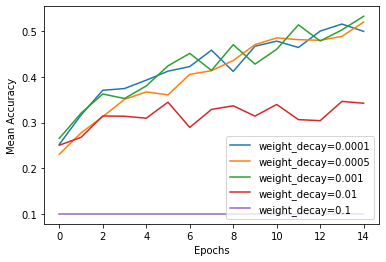

In [ ]:
ax = None
for d in analysis2.trial_dataframes.values():
  ax = d.mean_accuracy.plot(ax=ax)
ax.set_xlabel("Epochs")
ax.set_ylabel("Mean Accuracy")
ax.legend(['weight_decay=0.0001','weight_decay=0.0005','weight_decay=0.001', 'weight_decay=0.01', 'weight_decay=0.1'])

In [11]:
# Config for ResNet hyperparameter sensitivity analysis for lr
config = {
    "lr": tune.grid_search([0.1]),
    "momentum": tune.grid_search([0.9]),
    "weight_decay": tune.grid_search([0.0001]),
    "n": tune.grid_search([1, 2, 3, 4, 5]),
    "width": tune.grid_search([1])
}

datasets.CIFAR10("~/data", train=True, download=True)

analysis3 = tune.run(train_cifar, config=config, resources_per_trial={"cpu": 1, "gpu": 1})

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /root/data/cifar-10-python.tar.gz to /root/data


2022-04-21 00:07:25,646	WARNING function_runner.py:599 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.
2022-04-21 00:07:25,700	INFO logger.py:618 -- pip install "ray[tune]" to see TensorBoard files.
2022-04-21 00:07:25,702	WARNING callback.py:126 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`
2022-04-21 00:07:25,849	INFO trial_runner.py:803 -- starting train_cifar_0657e_00000


(train_cifar pid=435) Files already downloaded and verified
(train_cifar pid=435) Files already downloaded and verified


(train_cifar pid=435) Finished Training epoch 0


Result for train_cifar_0657e_00000:
  date: 2022-04-21_00-07-58
  done: false
  experiment_id: ffacf2e8ac684805a4884a143ad28de3
  hostname: 1255c898887d
  iterations_since_restore: 1
  mean_accuracy: 0.2089
  node_ip: 172.28.0.2
  pid: 435
  time_since_restore: 30.803097009658813
  time_this_iter_s: 30.803097009658813
  time_total_s: 30.803097009658813
  timestamp: 1650499678
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0657e_00000
  warmup_time: 0.0043849945068359375
  
(train_cifar pid=435) epoch 1 test_loss 177.23529529571533 test_steps 79 test_acc 0.2089


(train_cifar pid=435) Finished Training epoch 1
Result for train_cifar_0657e_00000:
  date: 2022-04-21_00-08-17
  done: false
  experiment_id: ffacf2e8ac684805a4884a143ad28de3
  hostname: 1255c898887d
  iterations_since_restore: 2
  mean_accuracy: 0.2674
  node_ip: 172.28.0.2
  pid: 435
  time_since_restore: 49.43851852416992
  time_this_iter_s: 18.63542151451111
  time_total_s: 49.43851852416992
  timestamp: 1650499697
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0657e_00000
  warmup_time: 0.0043849945068359375
  
(train_cifar pid=435) epoch 1 test_loss 172.29363989830017 test_steps 79 test_acc 0.2674


(train_cifar pid=435) Finished Training epoch 2
Result for train_cifar_0657e_00000:
  date: 2022-04-21_00-08-36
  done: false
  experiment_id: ffacf2e8ac684805a4884a143ad28de3
  hostname: 1255c898887d
  iterations_since_restore: 3
  mean_accuracy: 0.3131
  node_ip: 172.28.0.2
  pid: 435
  time_since_restore: 68.28167724609375
  time_this_iter_s: 18.843158721923828
  time_total_s: 68.28167724609375
  timestamp: 1650499716
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0657e_00000
  warmup_time: 0.0043849945068359375
  
(train_cifar pid=435) epoch 1 test_loss 169.2229197025299 test_steps 79 test_acc 0.3131


(train_cifar pid=435) Finished Training epoch 3
Result for train_cifar_0657e_00000:
  date: 2022-04-21_00-08-55
  done: false
  experiment_id: ffacf2e8ac684805a4884a143ad28de3
  hostname: 1255c898887d
  iterations_since_restore: 4
  mean_accuracy: 0.3895
  node_ip: 172.28.0.2
  pid: 435
  time_since_restore: 87.19306135177612
  time_this_iter_s: 18.911384105682373
  time_total_s: 87.19306135177612
  timestamp: 1650499735
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0657e_00000
  warmup_time: 0.0043849945068359375
  
(train_cifar pid=435) epoch 1 test_loss 163.31068193912506 test_steps 79 test_acc 0.3895


(train_cifar pid=435) Finished Training epoch 4
Result for train_cifar_0657e_00000:
  date: 2022-04-21_00-09-14
  done: false
  experiment_id: ffacf2e8ac684805a4884a143ad28de3
  hostname: 1255c898887d
  iterations_since_restore: 5
  mean_accuracy: 0.388
  node_ip: 172.28.0.2
  pid: 435
  time_since_restore: 106.19050979614258
  time_this_iter_s: 18.997448444366455
  time_total_s: 106.19050979614258
  timestamp: 1650499754
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0657e_00000
  warmup_time: 0.0043849945068359375
  
(train_cifar pid=435) epoch 1 test_loss 163.3218253850937 test_steps 79 test_acc 0.388


(train_cifar pid=435) Finished Training epoch 5
Result for train_cifar_0657e_00000:
  date: 2022-04-21_00-09-32
  done: false
  experiment_id: ffacf2e8ac684805a4884a143ad28de3
  hostname: 1255c898887d
  iterations_since_restore: 6
  mean_accuracy: 0.414
  node_ip: 172.28.0.2
  pid: 435
  time_since_restore: 124.66374611854553
  time_this_iter_s: 18.473236322402954
  time_total_s: 124.66374611854553
  timestamp: 1650499772
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0657e_00000
  warmup_time: 0.0043849945068359375
  
(train_cifar pid=435) epoch 1 test_loss 161.2462066411972 test_steps 79 test_acc 0.414


(train_cifar pid=435) Finished Training epoch 6
Result for train_cifar_0657e_00000:
  date: 2022-04-21_00-09-51
  done: false
  experiment_id: ffacf2e8ac684805a4884a143ad28de3
  hostname: 1255c898887d
  iterations_since_restore: 7
  mean_accuracy: 0.3838
  node_ip: 172.28.0.2
  pid: 435
  time_since_restore: 143.36785697937012
  time_this_iter_s: 18.704110860824585
  time_total_s: 143.36785697937012
  timestamp: 1650499791
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0657e_00000
  warmup_time: 0.0043849945068359375
  
(train_cifar pid=435) epoch 1 test_loss 163.56260228157043 test_steps 79 test_acc 0.3838


(train_cifar pid=435) Finished Training epoch 7
Result for train_cifar_0657e_00000:
  date: 2022-04-21_00-10-10
  done: false
  experiment_id: ffacf2e8ac684805a4884a143ad28de3
  hostname: 1255c898887d
  iterations_since_restore: 8
  mean_accuracy: 0.4163
  node_ip: 172.28.0.2
  pid: 435
  time_since_restore: 162.07729077339172
  time_this_iter_s: 18.709433794021606
  time_total_s: 162.07729077339172
  timestamp: 1650499810
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0657e_00000
  warmup_time: 0.0043849945068359375
  
(train_cifar pid=435) epoch 1 test_loss 161.28192341327667 test_steps 79 test_acc 0.4163


(train_cifar pid=435) Finished Training epoch 8
Result for train_cifar_0657e_00000:
  date: 2022-04-21_00-10-28
  done: false
  experiment_id: ffacf2e8ac684805a4884a143ad28de3
  hostname: 1255c898887d
  iterations_since_restore: 9
  mean_accuracy: 0.4321
  node_ip: 172.28.0.2
  pid: 435
  time_since_restore: 180.5338315963745
  time_this_iter_s: 18.456540822982788
  time_total_s: 180.5338315963745
  timestamp: 1650499828
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0657e_00000
  warmup_time: 0.0043849945068359375
  
(train_cifar pid=435) epoch 1 test_loss 159.90398943424225 test_steps 79 test_acc 0.4321


(train_cifar pid=435) Finished Training epoch 9
Result for train_cifar_0657e_00000:
  date: 2022-04-21_00-10-47
  done: false
  experiment_id: ffacf2e8ac684805a4884a143ad28de3
  hostname: 1255c898887d
  iterations_since_restore: 10
  mean_accuracy: 0.4563
  node_ip: 172.28.0.2
  pid: 435
  time_since_restore: 199.19012117385864
  time_this_iter_s: 18.65628957748413
  time_total_s: 199.19012117385864
  timestamp: 1650499847
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0657e_00000
  warmup_time: 0.0043849945068359375
  
(train_cifar pid=435) epoch 1 test_loss 158.02510571479797 test_steps 79 test_acc 0.4563


(train_cifar pid=435) Finished Training epoch 10
Result for train_cifar_0657e_00000:
  date: 2022-04-21_00-11-06
  done: false
  experiment_id: ffacf2e8ac684805a4884a143ad28de3
  hostname: 1255c898887d
  iterations_since_restore: 11
  mean_accuracy: 0.4658
  node_ip: 172.28.0.2
  pid: 435
  time_since_restore: 217.86910438537598
  time_this_iter_s: 18.678983211517334
  time_total_s: 217.86910438537598
  timestamp: 1650499866
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 0657e_00000
  warmup_time: 0.0043849945068359375
  
(train_cifar pid=435) epoch 1 test_loss 157.248677611351 test_steps 79 test_acc 0.4658


(train_cifar pid=435) Finished Training epoch 11
Result for train_cifar_0657e_00000:
  date: 2022-04-21_00-11-24
  done: false
  experiment_id: ffacf2e8ac684805a4884a143ad28de3
  hostname: 1255c898887d
  iterations_since_restore: 12
  mean_accuracy: 0.4898
  node_ip: 172.28.0.2
  pid: 435
  time_since_restore: 236.37782955169678
  time_this_iter_s: 18.5087251663208
  time_total_s: 236.37782955169678
  timestamp: 1650499884
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: 0657e_00000
  warmup_time: 0.0043849945068359375
  
(train_cifar pid=435) epoch 1 test_loss 155.36880695819855 test_steps 79 test_acc 0.4898


(train_cifar pid=435) Finished Training epoch 12
Result for train_cifar_0657e_00000:
  date: 2022-04-21_00-11-43
  done: false
  experiment_id: ffacf2e8ac684805a4884a143ad28de3
  hostname: 1255c898887d
  iterations_since_restore: 13
  mean_accuracy: 0.4913
  node_ip: 172.28.0.2
  pid: 435
  time_since_restore: 255.12994575500488
  time_this_iter_s: 18.752116203308105
  time_total_s: 255.12994575500488
  timestamp: 1650499903
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: 0657e_00000
  warmup_time: 0.0043849945068359375
  
(train_cifar pid=435) epoch 1 test_loss 155.26703453063965 test_steps 79 test_acc 0.4913


(train_cifar pid=435) Finished Training epoch 13
Result for train_cifar_0657e_00000:
  date: 2022-04-21_00-12-02
  done: false
  experiment_id: ffacf2e8ac684805a4884a143ad28de3
  hostname: 1255c898887d
  iterations_since_restore: 14
  mean_accuracy: 0.4979
  node_ip: 172.28.0.2
  pid: 435
  time_since_restore: 273.9041488170624
  time_this_iter_s: 18.774203062057495
  time_total_s: 273.9041488170624
  timestamp: 1650499922
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: 0657e_00000
  warmup_time: 0.0043849945068359375
  
(train_cifar pid=435) epoch 1 test_loss 154.63952481746674 test_steps 79 test_acc 0.4979


(train_cifar pid=435) Finished Training epoch 14
Result for train_cifar_0657e_00000:
  date: 2022-04-21_00-12-20
  done: false
  experiment_id: ffacf2e8ac684805a4884a143ad28de3
  hostname: 1255c898887d
  iterations_since_restore: 15
  mean_accuracy: 0.492
  node_ip: 172.28.0.2
  pid: 435
  time_since_restore: 292.756183385849
  time_this_iter_s: 18.85203456878662
  time_total_s: 292.756183385849
  timestamp: 1650499940
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: 0657e_00000
  warmup_time: 0.0043849945068359375
  
Result for train_cifar_0657e_00000:
  date: 2022-04-21_00-12-20
  done: true
  experiment_id: ffacf2e8ac684805a4884a143ad28de3
  experiment_tag: 0_lr=0.1,momentum=0.9,n=1,weight_decay=0.0001,width=1
  hostname: 1255c898887d
  iterations_since_restore: 15
  mean_accuracy: 0.492
  node_ip: 172.28.0.2
  pid: 435
  time_since_restore: 292.756183385849
  time_this_iter_s: 18.85203456878662
  time_total_s: 292.756183385849
  timestamp: 1650499940
  timesteps_si

2022-04-21 00:12:21,816	INFO trial_runner.py:803 -- starting train_cifar_0657e_00001


(train_cifar pid=593) Files already downloaded and verified
(train_cifar pid=593) Files already downloaded and verified


(train_cifar pid=593) Finished Training epoch 0
Result for train_cifar_0657e_00001:
  date: 2022-04-21_00-12-50
  done: false
  experiment_id: 25f621f85865494fa2d316c7844a2704
  hostname: 1255c898887d
  iterations_since_restore: 1
  mean_accuracy: 0.2711
  node_ip: 172.28.0.2
  pid: 593
  time_since_restore: 26.19561505317688
  time_this_iter_s: 26.19561505317688
  time_total_s: 26.19561505317688
  timestamp: 1650499970
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0657e_00001
  warmup_time: 0.0031719207763671875
  
(train_cifar pid=593) epoch 1 test_loss 171.85379672050476 test_steps 79 test_acc 0.2711


(train_cifar pid=593) Finished Training epoch 1


Result for train_cifar_0657e_00001:
  date: 2022-04-21_00-13-10
  done: false
  experiment_id: 25f621f85865494fa2d316c7844a2704
  hostname: 1255c898887d
  iterations_since_restore: 2
  mean_accuracy: 0.3577
  node_ip: 172.28.0.2
  pid: 593
  time_since_restore: 46.68479800224304
  time_this_iter_s: 20.489182949066162
  time_total_s: 46.68479800224304
  timestamp: 1650499990
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0657e_00001
  warmup_time: 0.0031719207763671875
  
(train_cifar pid=593) epoch 1 test_loss 165.86148953437805 test_steps 79 test_acc 0.3577


(train_cifar pid=593) Finished Training epoch 2
Result for train_cifar_0657e_00001:
  date: 2022-04-21_00-13-30
  done: false
  experiment_id: 25f621f85865494fa2d316c7844a2704
  hostname: 1255c898887d
  iterations_since_restore: 3
  mean_accuracy: 0.3579
  node_ip: 172.28.0.2
  pid: 593
  time_since_restore: 66.64318060874939
  time_this_iter_s: 19.958382606506348
  time_total_s: 66.64318060874939
  timestamp: 1650500010
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0657e_00001
  warmup_time: 0.0031719207763671875
  
(train_cifar pid=593) epoch 1 test_loss 165.51169502735138 test_steps 79 test_acc 0.3579


(train_cifar pid=593) Finished Training epoch 3
Result for train_cifar_0657e_00001:
  date: 2022-04-21_00-13-50
  done: false
  experiment_id: 25f621f85865494fa2d316c7844a2704
  hostname: 1255c898887d
  iterations_since_restore: 4
  mean_accuracy: 0.4002
  node_ip: 172.28.0.2
  pid: 593
  time_since_restore: 86.35179877281189
  time_this_iter_s: 19.7086181640625
  time_total_s: 86.35179877281189
  timestamp: 1650500030
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0657e_00001
  warmup_time: 0.0031719207763671875
  
(train_cifar pid=593) epoch 1 test_loss 162.36961436271667 test_steps 79 test_acc 0.4002


(train_cifar pid=593) Finished Training epoch 4
Result for train_cifar_0657e_00001:
  date: 2022-04-21_00-14-10
  done: false
  experiment_id: 25f621f85865494fa2d316c7844a2704
  hostname: 1255c898887d
  iterations_since_restore: 5
  mean_accuracy: 0.3922
  node_ip: 172.28.0.2
  pid: 593
  time_since_restore: 106.26942849159241
  time_this_iter_s: 19.917629718780518
  time_total_s: 106.26942849159241
  timestamp: 1650500050
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0657e_00001
  warmup_time: 0.0031719207763671875
  
(train_cifar pid=593) epoch 1 test_loss 162.7575365304947 test_steps 79 test_acc 0.3922


(train_cifar pid=593) Finished Training epoch 5
Result for train_cifar_0657e_00001:
  date: 2022-04-21_00-14-30
  done: false
  experiment_id: 25f621f85865494fa2d316c7844a2704
  hostname: 1255c898887d
  iterations_since_restore: 6
  mean_accuracy: 0.4466
  node_ip: 172.28.0.2
  pid: 593
  time_since_restore: 126.14478874206543
  time_this_iter_s: 19.875360250473022
  time_total_s: 126.14478874206543
  timestamp: 1650500070
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0657e_00001
  warmup_time: 0.0031719207763671875
  
(train_cifar pid=593) epoch 1 test_loss 158.83748495578766 test_steps 79 test_acc 0.4466


(train_cifar pid=593) Finished Training epoch 6


Result for train_cifar_0657e_00001:
  date: 2022-04-21_00-14-50
  done: false
  experiment_id: 25f621f85865494fa2d316c7844a2704
  hostname: 1255c898887d
  iterations_since_restore: 7
  mean_accuracy: 0.4352
  node_ip: 172.28.0.2
  pid: 593
  time_since_restore: 146.47180271148682
  time_this_iter_s: 20.327013969421387
  time_total_s: 146.47180271148682
  timestamp: 1650500090
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0657e_00001
  warmup_time: 0.0031719207763671875
  
(train_cifar pid=593) epoch 1 test_loss 159.52066802978516 test_steps 79 test_acc 0.4352


(train_cifar pid=593) Finished Training epoch 7


Result for train_cifar_0657e_00001:
  date: 2022-04-21_00-15-11
  done: false
  experiment_id: 25f621f85865494fa2d316c7844a2704
  hostname: 1255c898887d
  iterations_since_restore: 8
  mean_accuracy: 0.4472
  node_ip: 172.28.0.2
  pid: 593
  time_since_restore: 167.3029179573059
  time_this_iter_s: 20.831115245819092
  time_total_s: 167.3029179573059
  timestamp: 1650500111
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0657e_00001
  warmup_time: 0.0031719207763671875
  
(train_cifar pid=593) epoch 1 test_loss 158.6866396665573 test_steps 79 test_acc 0.4472


(train_cifar pid=593) Finished Training epoch 8


Result for train_cifar_0657e_00001:
  date: 2022-04-21_00-15-32
  done: false
  experiment_id: 25f621f85865494fa2d316c7844a2704
  hostname: 1255c898887d
  iterations_since_restore: 9
  mean_accuracy: 0.4828
  node_ip: 172.28.0.2
  pid: 593
  time_since_restore: 187.92661452293396
  time_this_iter_s: 20.62369656562805
  time_total_s: 187.92661452293396
  timestamp: 1650500132
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0657e_00001
  warmup_time: 0.0031719207763671875
  
(train_cifar pid=593) epoch 1 test_loss 155.83229994773865 test_steps 79 test_acc 0.4828


(train_cifar pid=593) Finished Training epoch 9


Result for train_cifar_0657e_00001:
  date: 2022-04-21_00-15-52
  done: false
  experiment_id: 25f621f85865494fa2d316c7844a2704
  hostname: 1255c898887d
  iterations_since_restore: 10
  mean_accuracy: 0.4795
  node_ip: 172.28.0.2
  pid: 593
  time_since_restore: 208.68677163124084
  time_this_iter_s: 20.760157108306885
  time_total_s: 208.68677163124084
  timestamp: 1650500152
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0657e_00001
  warmup_time: 0.0031719207763671875
  
(train_cifar pid=593) epoch 1 test_loss 156.20072627067566 test_steps 79 test_acc 0.4795


(train_cifar pid=593) Finished Training epoch 10


Result for train_cifar_0657e_00001:
  date: 2022-04-21_00-16-12
  done: false
  experiment_id: 25f621f85865494fa2d316c7844a2704
  hostname: 1255c898887d
  iterations_since_restore: 11
  mean_accuracy: 0.4945
  node_ip: 172.28.0.2
  pid: 593
  time_since_restore: 228.84224677085876
  time_this_iter_s: 20.15547513961792
  time_total_s: 228.84224677085876
  timestamp: 1650500172
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 0657e_00001
  warmup_time: 0.0031719207763671875
  
(train_cifar pid=593) epoch 1 test_loss 154.8730890750885 test_steps 79 test_acc 0.4945


(train_cifar pid=593) Finished Training epoch 11


Result for train_cifar_0657e_00001:
  date: 2022-04-21_00-16-33
  done: false
  experiment_id: 25f621f85865494fa2d316c7844a2704
  hostname: 1255c898887d
  iterations_since_restore: 12
  mean_accuracy: 0.5348
  node_ip: 172.28.0.2
  pid: 593
  time_since_restore: 249.30403685569763
  time_this_iter_s: 20.461790084838867
  time_total_s: 249.30403685569763
  timestamp: 1650500193
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: 0657e_00001
  warmup_time: 0.0031719207763671875
  
(train_cifar pid=593) epoch 1 test_loss 151.87745535373688 test_steps 79 test_acc 0.5348


(train_cifar pid=593) Finished Training epoch 12


Result for train_cifar_0657e_00001:
  date: 2022-04-21_00-16-54
  done: false
  experiment_id: 25f621f85865494fa2d316c7844a2704
  hostname: 1255c898887d
  iterations_since_restore: 13
  mean_accuracy: 0.56
  node_ip: 172.28.0.2
  pid: 593
  time_since_restore: 269.8822326660156
  time_this_iter_s: 20.578195810317993
  time_total_s: 269.8822326660156
  timestamp: 1650500214
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: 0657e_00001
  warmup_time: 0.0031719207763671875
  
(train_cifar pid=593) epoch 1 test_loss 149.87450122833252 test_steps 79 test_acc 0.56


(train_cifar pid=593) Finished Training epoch 13
Result for train_cifar_0657e_00001:
  date: 2022-04-21_00-17-13
  done: false
  experiment_id: 25f621f85865494fa2d316c7844a2704
  hostname: 1255c898887d
  iterations_since_restore: 14
  mean_accuracy: 0.5437
  node_ip: 172.28.0.2
  pid: 593
  time_since_restore: 289.646279335022
  time_this_iter_s: 19.764046669006348
  time_total_s: 289.646279335022
  timestamp: 1650500233
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: 0657e_00001
  warmup_time: 0.0031719207763671875
  
(train_cifar pid=593) epoch 1 test_loss 151.1177898645401 test_steps 79 test_acc 0.5437


(train_cifar pid=593) Finished Training epoch 14
Result for train_cifar_0657e_00001:
  date: 2022-04-21_00-17-33
  done: false
  experiment_id: 25f621f85865494fa2d316c7844a2704
  hostname: 1255c898887d
  iterations_since_restore: 15
  mean_accuracy: 0.5698
  node_ip: 172.28.0.2
  pid: 593
  time_since_restore: 309.48796820640564
  time_this_iter_s: 19.841688871383667
  time_total_s: 309.48796820640564
  timestamp: 1650500253
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: 0657e_00001
  warmup_time: 0.0031719207763671875
  
Result for train_cifar_0657e_00001:
  date: 2022-04-21_00-17-33
  done: true
  experiment_id: 25f621f85865494fa2d316c7844a2704
  experiment_tag: 1_lr=0.1,momentum=0.9,n=2,weight_decay=0.0001,width=1
  hostname: 1255c898887d
  iterations_since_restore: 15
  mean_accuracy: 0.5698
  node_ip: 172.28.0.2
  pid: 593
  time_since_restore: 309.48796820640564
  time_this_iter_s: 19.841688871383667
  time_total_s: 309.48796820640564
  timestamp: 1650500253
  

2022-04-21 00:17:33,867	INFO trial_runner.py:803 -- starting train_cifar_0657e_00002


(train_cifar pid=778) Files already downloaded and verified
(train_cifar pid=778) Files already downloaded and verified


(train_cifar pid=778) Finished Training epoch 0


Result for train_cifar_0657e_00002:
  date: 2022-04-21_00-18-03
  done: false
  experiment_id: 8ff24a31cf0c43e6977c4a38809498b0
  hostname: 1255c898887d
  iterations_since_restore: 1
  mean_accuracy: 0.232
  node_ip: 172.28.0.2
  pid: 778
  time_since_restore: 27.31895899772644
  time_this_iter_s: 27.31895899772644
  time_total_s: 27.31895899772644
  timestamp: 1650500283
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0657e_00002
  warmup_time: 0.0034258365631103516
  
(train_cifar pid=778) epoch 1 test_loss 175.15302205085754 test_steps 79 test_acc 0.232


(train_cifar pid=778) Finished Training epoch 1


Result for train_cifar_0657e_00002:
  date: 2022-04-21_00-18-24
  done: false
  experiment_id: 8ff24a31cf0c43e6977c4a38809498b0
  hostname: 1255c898887d
  iterations_since_restore: 2
  mean_accuracy: 0.3419
  node_ip: 172.28.0.2
  pid: 778
  time_since_restore: 48.83751678466797
  time_this_iter_s: 21.51855778694153
  time_total_s: 48.83751678466797
  timestamp: 1650500304
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0657e_00002
  warmup_time: 0.0034258365631103516
  
(train_cifar pid=778) epoch 1 test_loss 167.35882925987244 test_steps 79 test_acc 0.3419


(train_cifar pid=778) Finished Training epoch 2


Result for train_cifar_0657e_00002:
  date: 2022-04-21_00-18-46
  done: false
  experiment_id: 8ff24a31cf0c43e6977c4a38809498b0
  hostname: 1255c898887d
  iterations_since_restore: 3
  mean_accuracy: 0.3587
  node_ip: 172.28.0.2
  pid: 778
  time_since_restore: 70.33542132377625
  time_this_iter_s: 21.497904539108276
  time_total_s: 70.33542132377625
  timestamp: 1650500326
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0657e_00002
  warmup_time: 0.0034258365631103516
  
(train_cifar pid=778) epoch 1 test_loss 165.474827170372 test_steps 79 test_acc 0.3587


(train_cifar pid=778) Finished Training epoch 3


Result for train_cifar_0657e_00002:
  date: 2022-04-21_00-19-08
  done: false
  experiment_id: 8ff24a31cf0c43e6977c4a38809498b0
  hostname: 1255c898887d
  iterations_since_restore: 4
  mean_accuracy: 0.3527
  node_ip: 172.28.0.2
  pid: 778
  time_since_restore: 92.48208928108215
  time_this_iter_s: 22.146667957305908
  time_total_s: 92.48208928108215
  timestamp: 1650500348
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0657e_00002
  warmup_time: 0.0034258365631103516
  
(train_cifar pid=778) epoch 1 test_loss 166.33021545410156 test_steps 79 test_acc 0.3527


(train_cifar pid=778) Finished Training epoch 4


Result for train_cifar_0657e_00002:
  date: 2022-04-21_00-19-30
  done: false
  experiment_id: 8ff24a31cf0c43e6977c4a38809498b0
  hostname: 1255c898887d
  iterations_since_restore: 5
  mean_accuracy: 0.3495
  node_ip: 172.28.0.2
  pid: 778
  time_since_restore: 114.44205403327942
  time_this_iter_s: 21.959964752197266
  time_total_s: 114.44205403327942
  timestamp: 1650500370
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0657e_00002
  warmup_time: 0.0034258365631103516
  
(train_cifar pid=778) epoch 1 test_loss 166.1170299053192 test_steps 79 test_acc 0.3495


(train_cifar pid=778) Finished Training epoch 5


Result for train_cifar_0657e_00002:
  date: 2022-04-21_00-19-52
  done: false
  experiment_id: 8ff24a31cf0c43e6977c4a38809498b0
  hostname: 1255c898887d
  iterations_since_restore: 6
  mean_accuracy: 0.4133
  node_ip: 172.28.0.2
  pid: 778
  time_since_restore: 136.4555583000183
  time_this_iter_s: 22.01350426673889
  time_total_s: 136.4555583000183
  timestamp: 1650500392
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0657e_00002
  warmup_time: 0.0034258365631103516
  
(train_cifar pid=778) epoch 1 test_loss 161.30795168876648 test_steps 79 test_acc 0.4133


(train_cifar pid=778) Finished Training epoch 6


Result for train_cifar_0657e_00002:
  date: 2022-04-21_00-20-14
  done: false
  experiment_id: 8ff24a31cf0c43e6977c4a38809498b0
  hostname: 1255c898887d
  iterations_since_restore: 7
  mean_accuracy: 0.4158
  node_ip: 172.28.0.2
  pid: 778
  time_since_restore: 158.44918131828308
  time_this_iter_s: 21.99362301826477
  time_total_s: 158.44918131828308
  timestamp: 1650500414
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0657e_00002
  warmup_time: 0.0034258365631103516
  
(train_cifar pid=778) epoch 1 test_loss 160.9672657251358 test_steps 79 test_acc 0.4158


(train_cifar pid=778) Finished Training epoch 7


Result for train_cifar_0657e_00002:
  date: 2022-04-21_00-20-36
  done: false
  experiment_id: 8ff24a31cf0c43e6977c4a38809498b0
  hostname: 1255c898887d
  iterations_since_restore: 8
  mean_accuracy: 0.439
  node_ip: 172.28.0.2
  pid: 778
  time_since_restore: 180.4009268283844
  time_this_iter_s: 21.95174551010132
  time_total_s: 180.4009268283844
  timestamp: 1650500436
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0657e_00002
  warmup_time: 0.0034258365631103516
  
(train_cifar pid=778) epoch 1 test_loss 159.4774296283722 test_steps 79 test_acc 0.439


(train_cifar pid=778) Finished Training epoch 8


Result for train_cifar_0657e_00002:
  date: 2022-04-21_00-20-58
  done: false
  experiment_id: 8ff24a31cf0c43e6977c4a38809498b0
  hostname: 1255c898887d
  iterations_since_restore: 9
  mean_accuracy: 0.4311
  node_ip: 172.28.0.2
  pid: 778
  time_since_restore: 202.37215733528137
  time_this_iter_s: 21.971230506896973
  time_total_s: 202.37215733528137
  timestamp: 1650500458
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0657e_00002
  warmup_time: 0.0034258365631103516
  
(train_cifar pid=778) epoch 1 test_loss 160.10328018665314 test_steps 79 test_acc 0.4311


(train_cifar pid=778) Finished Training epoch 9


Result for train_cifar_0657e_00002:
  date: 2022-04-21_00-21-20
  done: false
  experiment_id: 8ff24a31cf0c43e6977c4a38809498b0
  hostname: 1255c898887d
  iterations_since_restore: 10
  mean_accuracy: 0.4406
  node_ip: 172.28.0.2
  pid: 778
  time_since_restore: 224.86495280265808
  time_this_iter_s: 22.49279546737671
  time_total_s: 224.86495280265808
  timestamp: 1650500480
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0657e_00002
  warmup_time: 0.0034258365631103516
  
(train_cifar pid=778) epoch 1 test_loss 159.32246375083923 test_steps 79 test_acc 0.4406


(train_cifar pid=778) Finished Training epoch 10
Result for train_cifar_0657e_00002:
  date: 2022-04-21_00-21-43
  done: false
  experiment_id: 8ff24a31cf0c43e6977c4a38809498b0
  hostname: 1255c898887d
  iterations_since_restore: 11
  mean_accuracy: 0.4672
  node_ip: 172.28.0.2
  pid: 778
  time_since_restore: 247.26478838920593
  time_this_iter_s: 22.39983558654785
  time_total_s: 247.26478838920593
  timestamp: 1650500503
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 0657e_00002
  warmup_time: 0.0034258365631103516
  
(train_cifar pid=778) epoch 1 test_loss 157.24434959888458 test_steps 79 test_acc 0.4672


(train_cifar pid=778) Finished Training epoch 11


Result for train_cifar_0657e_00002:
  date: 2022-04-21_00-22-05
  done: false
  experiment_id: 8ff24a31cf0c43e6977c4a38809498b0
  hostname: 1255c898887d
  iterations_since_restore: 12
  mean_accuracy: 0.4638
  node_ip: 172.28.0.2
  pid: 778
  time_since_restore: 268.97057342529297
  time_this_iter_s: 21.705785036087036
  time_total_s: 268.97057342529297
  timestamp: 1650500525
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: 0657e_00002
  warmup_time: 0.0034258365631103516
  
(train_cifar pid=778) epoch 1 test_loss 157.37551474571228 test_steps 79 test_acc 0.4638


(train_cifar pid=778) Finished Training epoch 12


Result for train_cifar_0657e_00002:
  date: 2022-04-21_00-22-26
  done: false
  experiment_id: 8ff24a31cf0c43e6977c4a38809498b0
  hostname: 1255c898887d
  iterations_since_restore: 13
  mean_accuracy: 0.4859
  node_ip: 172.28.0.2
  pid: 778
  time_since_restore: 290.79642128944397
  time_this_iter_s: 21.825847864151
  time_total_s: 290.79642128944397
  timestamp: 1650500546
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: 0657e_00002
  warmup_time: 0.0034258365631103516
  
(train_cifar pid=778) epoch 1 test_loss 155.2897115945816 test_steps 79 test_acc 0.4859


(train_cifar pid=778) Finished Training epoch 13
Result for train_cifar_0657e_00002:
  date: 2022-04-21_00-22-49
  done: false
  experiment_id: 8ff24a31cf0c43e6977c4a38809498b0
  hostname: 1255c898887d
  iterations_since_restore: 14
  mean_accuracy: 0.4981
  node_ip: 172.28.0.2
  pid: 778
  time_since_restore: 313.8893492221832
  time_this_iter_s: 23.092927932739258
  time_total_s: 313.8893492221832
  timestamp: 1650500569
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: 0657e_00002
  warmup_time: 0.0034258365631103516
  
(train_cifar pid=778) epoch 1 test_loss 154.82948064804077 test_steps 79 test_acc 0.4981


(train_cifar pid=778) Finished Training epoch 14


Result for train_cifar_0657e_00002:(train_cifar pid=778) epoch 1 test_loss 152.50633239746094 test_steps 79 test_acc 0.5272

  date: 2022-04-21_00-23-11
  done: false
  experiment_id: 8ff24a31cf0c43e6977c4a38809498b0
  hostname: 1255c898887d
  iterations_since_restore: 15
  mean_accuracy: 0.5272
  node_ip: 172.28.0.2
  pid: 778
  time_since_restore: 335.8186490535736
  time_this_iter_s: 21.92929983139038
  time_total_s: 335.8186490535736
  timestamp: 1650500591
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: 0657e_00002
  warmup_time: 0.0034258365631103516
  
Result for train_cifar_0657e_00002:
  date: 2022-04-21_00-23-11
  done: true
  experiment_id: 8ff24a31cf0c43e6977c4a38809498b0
  experiment_tag: 2_lr=0.1,momentum=0.9,n=3,weight_decay=0.0001,width=1
  hostname: 1255c898887d
  iterations_since_restore: 15
  mean_accuracy: 0.5272
  node_ip: 172.28.0.2
  pid: 778
  time_since_restore: 335.8186490535736
  time_this_iter_s: 21.92929983139038
  time_total_s: 335.818649

2022-04-21 00:23:12,908	INFO trial_runner.py:803 -- starting train_cifar_0657e_00003


(train_cifar pid=965) Files already downloaded and verified
(train_cifar pid=965) Files already downloaded and verified


(train_cifar pid=965) Finished Training epoch 0


Result for train_cifar_0657e_00003:(train_cifar pid=965) epoch 1 test_loss 171.01617407798767 test_steps 79 test_acc 0.2949

  date: 2022-04-21_00-23-44
  done: false
  experiment_id: 54d10b59e9364860908a539e34fb3db9
  hostname: 1255c898887d
  iterations_since_restore: 1
  mean_accuracy: 0.2949
  node_ip: 172.28.0.2
  pid: 965
  time_since_restore: 29.35925054550171
  time_this_iter_s: 29.35925054550171
  time_total_s: 29.35925054550171
  timestamp: 1650500624
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0657e_00003
  warmup_time: 0.0031502246856689453
  


(train_cifar pid=965) Finished Training epoch 1
Result for train_cifar_0657e_00003:
  date: 2022-04-21_00-24-08
  done: false
  experiment_id: 54d10b59e9364860908a539e34fb3db9
  hostname: 1255c898887d
  iterations_since_restore: 2
  mean_accuracy: 0.2514
  node_ip: 172.28.0.2
  pid: 965
  time_since_restore: 53.259549617767334
  time_this_iter_s: 23.900299072265625
  time_total_s: 53.259549617767334
  timestamp: 1650500648
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0657e_00003
  warmup_time: 0.0031502246856689453
  
(train_cifar pid=965) epoch 1 test_loss 173.68768453598022 test_steps 79 test_acc 0.2514


(train_cifar pid=965) Finished Training epoch 2
Result for train_cifar_0657e_00003:
  date: 2022-04-21_00-24-31
  done: false
  experiment_id: 54d10b59e9364860908a539e34fb3db9
  hostname: 1255c898887d
  iterations_since_restore: 3
  mean_accuracy: 0.3429
  node_ip: 172.28.0.2
  pid: 965
  time_since_restore: 76.20414519309998
  time_this_iter_s: 22.94459557533264
  time_total_s: 76.20414519309998
  timestamp: 1650500671
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0657e_00003
  warmup_time: 0.0031502246856689453
  
(train_cifar pid=965) epoch 1 test_loss 166.8434386253357 test_steps 79 test_acc 0.3429


(train_cifar pid=965) Finished Training epoch 3
Result for train_cifar_0657e_00003:
  date: 2022-04-21_00-24-54
  done: false
  experiment_id: 54d10b59e9364860908a539e34fb3db9
  hostname: 1255c898887d
  iterations_since_restore: 4
  mean_accuracy: 0.3943
  node_ip: 172.28.0.2
  pid: 965
  time_since_restore: 99.42190480232239
  time_this_iter_s: 23.217759609222412
  time_total_s: 99.42190480232239
  timestamp: 1650500694
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0657e_00003
  warmup_time: 0.0031502246856689453
  
(train_cifar pid=965) epoch 1 test_loss 162.61762249469757 test_steps 79 test_acc 0.3943


(train_cifar pid=965) Finished Training epoch 4
Result for train_cifar_0657e_00003:
  date: 2022-04-21_00-25-18
  done: false
  experiment_id: 54d10b59e9364860908a539e34fb3db9
  hostname: 1255c898887d
  iterations_since_restore: 5
  mean_accuracy: 0.3704
  node_ip: 172.28.0.2
  pid: 965
  time_since_restore: 123.5863208770752
  time_this_iter_s: 24.164416074752808
  time_total_s: 123.5863208770752
  timestamp: 1650500718
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0657e_00003
  warmup_time: 0.0031502246856689453
  
(train_cifar pid=965) epoch 1 test_loss 164.90211474895477 test_steps 79 test_acc 0.3704


(train_cifar pid=965) Finished Training epoch 5
Result for train_cifar_0657e_00003:
  date: 2022-04-21_00-25-42
  done: false
  experiment_id: 54d10b59e9364860908a539e34fb3db9
  hostname: 1255c898887d
  iterations_since_restore: 6
  mean_accuracy: 0.424
  node_ip: 172.28.0.2
  pid: 965
  time_since_restore: 147.00221920013428
  time_this_iter_s: 23.415898323059082
  time_total_s: 147.00221920013428
  timestamp: 1650500742
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0657e_00003
  warmup_time: 0.0031502246856689453
  
(train_cifar pid=965) epoch 1 test_loss 160.41201543807983 test_steps 79 test_acc 0.424


(train_cifar pid=965) Finished Training epoch 6
Result for train_cifar_0657e_00003:
  date: 2022-04-21_00-26-06
  done: false
  experiment_id: 54d10b59e9364860908a539e34fb3db9
  hostname: 1255c898887d
  iterations_since_restore: 7
  mean_accuracy: 0.4351
  node_ip: 172.28.0.2
  pid: 965
  time_since_restore: 171.0169222354889
  time_this_iter_s: 24.014703035354614
  time_total_s: 171.0169222354889
  timestamp: 1650500766
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0657e_00003
  warmup_time: 0.0031502246856689453
  
(train_cifar pid=965) epoch 1 test_loss 159.62779688835144 test_steps 79 test_acc 0.4351


(train_cifar pid=965) Finished Training epoch 7


Result for train_cifar_0657e_00003:
  date: 2022-04-21_00-26-31
  done: false
  experiment_id: 54d10b59e9364860908a539e34fb3db9
  hostname: 1255c898887d
  iterations_since_restore: 8
  mean_accuracy: 0.4408
  node_ip: 172.28.0.2
  pid: 965
  time_since_restore: 196.43832778930664
  time_this_iter_s: 25.42140555381775
  time_total_s: 196.43832778930664
  timestamp: 1650500791
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0657e_00003
  warmup_time: 0.0031502246856689453
  
(train_cifar pid=965) epoch 1 test_loss 159.1018397808075 test_steps 79 test_acc 0.4408


(train_cifar pid=965) Finished Training epoch 8
Result for train_cifar_0657e_00003:
  date: 2022-04-21_00-26-55
  done: false
  experiment_id: 54d10b59e9364860908a539e34fb3db9
  hostname: 1255c898887d
  iterations_since_restore: 9
  mean_accuracy: 0.4166
  node_ip: 172.28.0.2
  pid: 965
  time_since_restore: 219.90161299705505
  time_this_iter_s: 23.463285207748413
  time_total_s: 219.90161299705505
  timestamp: 1650500815
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0657e_00003
  warmup_time: 0.0031502246856689453
  
(train_cifar pid=965) epoch 1 test_loss 160.98716914653778 test_steps 79 test_acc 0.4166


(train_cifar pid=965) Finished Training epoch 9
Result for train_cifar_0657e_00003:
  date: 2022-04-21_00-27-18
  done: false
  experiment_id: 54d10b59e9364860908a539e34fb3db9
  hostname: 1255c898887d
  iterations_since_restore: 10
  mean_accuracy: 0.4507
  node_ip: 172.28.0.2
  pid: 965
  time_since_restore: 243.12253975868225
  time_this_iter_s: 23.220926761627197
  time_total_s: 243.12253975868225
  timestamp: 1650500838
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0657e_00003
  warmup_time: 0.0031502246856689453
  
(train_cifar pid=965) epoch 1 test_loss 158.17455458641052 test_steps 79 test_acc 0.4507


(train_cifar pid=965) Finished Training epoch 10
Result for train_cifar_0657e_00003:
  date: 2022-04-21_00-27-42
  done: false
  experiment_id: 54d10b59e9364860908a539e34fb3db9
  hostname: 1255c898887d
  iterations_since_restore: 11
  mean_accuracy: 0.469
  node_ip: 172.28.0.2
  pid: 965
  time_since_restore: 267.4663622379303
  time_this_iter_s: 24.343822479248047
  time_total_s: 267.4663622379303
  timestamp: 1650500862
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 0657e_00003
  warmup_time: 0.0031502246856689453
  
(train_cifar pid=965) epoch 1 test_loss 157.01338016986847 test_steps 79 test_acc 0.469


(train_cifar pid=965) Finished Training epoch 11
Result for train_cifar_0657e_00003:
  date: 2022-04-21_00-28-05
  done: false
  experiment_id: 54d10b59e9364860908a539e34fb3db9
  hostname: 1255c898887d
  iterations_since_restore: 12
  mean_accuracy: 0.4994
  node_ip: 172.28.0.2
  pid: 965
  time_since_restore: 290.8156635761261
  time_this_iter_s: 23.3493013381958
  time_total_s: 290.8156635761261
  timestamp: 1650500885
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: 0657e_00003
  warmup_time: 0.0031502246856689453
  
(train_cifar pid=965) epoch 1 test_loss 154.73572754859924 test_steps 79 test_acc 0.4994


(train_cifar pid=965) Finished Training epoch 12
Result for train_cifar_0657e_00003:
  date: 2022-04-21_00-28-29
  done: false
  experiment_id: 54d10b59e9364860908a539e34fb3db9
  hostname: 1255c898887d
  iterations_since_restore: 13
  mean_accuracy: 0.5029
  node_ip: 172.28.0.2
  pid: 965
  time_since_restore: 314.10108494758606
  time_this_iter_s: 23.28542137145996
  time_total_s: 314.10108494758606
  timestamp: 1650500909
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: 0657e_00003
  warmup_time: 0.0031502246856689453
  
(train_cifar pid=965) epoch 1 test_loss 154.46072781085968 test_steps 79 test_acc 0.5029


(train_cifar pid=965) Finished Training epoch 13
Result for train_cifar_0657e_00003:
  date: 2022-04-21_00-28-53
  done: false
  experiment_id: 54d10b59e9364860908a539e34fb3db9
  hostname: 1255c898887d
  iterations_since_restore: 14
  mean_accuracy: 0.5482
  node_ip: 172.28.0.2
  pid: 965
  time_since_restore: 338.26232647895813
  time_this_iter_s: 24.16124153137207
  time_total_s: 338.26232647895813
  timestamp: 1650500933
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: 0657e_00003
  warmup_time: 0.0031502246856689453
  
(train_cifar pid=965) epoch 1 test_loss 150.7937160730362 test_steps 79 test_acc 0.5482


(train_cifar pid=965) Finished Training epoch 14


2022-04-21 00:29:16,952	INFO trial_runner.py:803 -- starting train_cifar_0657e_00004


Result for train_cifar_0657e_00003:
  date: 2022-04-21_00-29-16
  done: false
  experiment_id: 54d10b59e9364860908a539e34fb3db9
  hostname: 1255c898887d
  iterations_since_restore: 15
  mean_accuracy: 0.5502
  node_ip: 172.28.0.2
  pid: 965
  time_since_restore: 361.7354278564453
  time_this_iter_s: 23.473101377487183
  time_total_s: 361.7354278564453
  timestamp: 1650500956
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: 0657e_00003
  warmup_time: 0.0031502246856689453
  
Result for train_cifar_0657e_00003:
  date: 2022-04-21_00-29-16
  done: true
  experiment_id: 54d10b59e9364860908a539e34fb3db9
  experiment_tag: 3_lr=0.1,momentum=0.9,n=4,weight_decay=0.0001,width=1
  hostname: 1255c898887d
  iterations_since_restore: 15
  mean_accuracy: 0.5502
  node_ip: 172.28.0.2
  pid: 965
  time_since_restore: 361.7354278564453
  time_this_iter_s: 23.473101377487183
  time_total_s: 361.7354278564453
  timestamp: 1650500956
  timesteps_since_restore: 0
  training_iteration: 15
 

(train_cifar pid=1138) Finished Training epoch 0
Result for train_cifar_0657e_00004:
  date: 2022-04-21_00-29-50
  done: false
  experiment_id: 20f58e1cb59b46da8ad256fdce957a0d
  hostname: 1255c898887d
  iterations_since_restore: 1
  mean_accuracy: 0.2921
  node_ip: 172.28.0.2
  pid: 1138
  time_since_restore: 30.905499696731567
  time_this_iter_s: 30.905499696731567
  time_total_s: 30.905499696731567
  timestamp: 1650500990
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0657e_00004
  warmup_time: 0.003242969512939453
  
(train_cifar pid=1138) epoch 1 test_loss 170.53240060806274 test_steps 79 test_acc 0.2921


(train_cifar pid=1138) Finished Training epoch 1


Result for train_cifar_0657e_00004:
  date: 2022-04-21_00-30-16
  done: false
  experiment_id: 20f58e1cb59b46da8ad256fdce957a0d
  hostname: 1255c898887d
  iterations_since_restore: 2
  mean_accuracy: 0.3143
  node_ip: 172.28.0.2
  pid: 1138
  time_since_restore: 56.903886795043945
  time_this_iter_s: 25.998387098312378
  time_total_s: 56.903886795043945
  timestamp: 1650501016
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0657e_00004
  warmup_time: 0.003242969512939453
  
(train_cifar pid=1138) epoch 1 test_loss 168.63221096992493 test_steps 79 test_acc 0.3143


(train_cifar pid=1138) Finished Training epoch 2
Result for train_cifar_0657e_00004:
  date: 2022-04-21_00-30-40
  done: false
  experiment_id: 20f58e1cb59b46da8ad256fdce957a0d
  hostname: 1255c898887d
  iterations_since_restore: 3
  mean_accuracy: 0.2818
  node_ip: 172.28.0.2
  pid: 1138
  time_since_restore: 81.59201455116272
  time_this_iter_s: 24.688127756118774
  time_total_s: 81.59201455116272
  timestamp: 1650501040
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 0657e_00004
  warmup_time: 0.003242969512939453
  
(train_cifar pid=1138) epoch 1 test_loss 171.42308712005615 test_steps 79 test_acc 0.2818


(train_cifar pid=1138) Finished Training epoch 3
Result for train_cifar_0657e_00004:
  date: 2022-04-21_00-31-05
  done: false
  experiment_id: 20f58e1cb59b46da8ad256fdce957a0d
  hostname: 1255c898887d
  iterations_since_restore: 4
  mean_accuracy: 0.3382
  node_ip: 172.28.0.2
  pid: 1138
  time_since_restore: 106.53946900367737
  time_this_iter_s: 24.94745445251465
  time_total_s: 106.53946900367737
  timestamp: 1650501065
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0657e_00004
  warmup_time: 0.003242969512939453
  
(train_cifar pid=1138) epoch 1 test_loss 166.85232067108154 test_steps 79 test_acc 0.3382


(train_cifar pid=1138) Finished Training epoch 4


Result for train_cifar_0657e_00004:
  date: 2022-04-21_00-31-31
  done: false
  experiment_id: 20f58e1cb59b46da8ad256fdce957a0d
  hostname: 1255c898887d
  iterations_since_restore: 5
  mean_accuracy: 0.3888
  node_ip: 172.28.0.2
  pid: 1138
  time_since_restore: 131.9677963256836
  time_this_iter_s: 25.428327322006226
  time_total_s: 131.9677963256836
  timestamp: 1650501091
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0657e_00004
  warmup_time: 0.003242969512939453
  
(train_cifar pid=1138) epoch 1 test_loss 162.98354542255402 test_steps 79 test_acc 0.3888


(train_cifar pid=1138) Finished Training epoch 5
Result for train_cifar_0657e_00004:
  date: 2022-04-21_00-31-56
  done: false
  experiment_id: 20f58e1cb59b46da8ad256fdce957a0d
  hostname: 1255c898887d
  iterations_since_restore: 6
  mean_accuracy: 0.3346
  node_ip: 172.28.0.2
  pid: 1138
  time_since_restore: 156.7323338985443
  time_this_iter_s: 24.764537572860718
  time_total_s: 156.7323338985443
  timestamp: 1650501116
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0657e_00004
  warmup_time: 0.003242969512939453
  
(train_cifar pid=1138) epoch 1 test_loss 167.5761992931366 test_steps 79 test_acc 0.3346


(train_cifar pid=1138) Finished Training epoch 6
Result for train_cifar_0657e_00004:
  date: 2022-04-21_00-32-20
  done: false
  experiment_id: 20f58e1cb59b46da8ad256fdce957a0d
  hostname: 1255c898887d
  iterations_since_restore: 7
  mean_accuracy: 0.4142
  node_ip: 172.28.0.2
  pid: 1138
  time_since_restore: 181.48233485221863
  time_this_iter_s: 24.750000953674316
  time_total_s: 181.48233485221863
  timestamp: 1650501140
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0657e_00004
  warmup_time: 0.003242969512939453
  
(train_cifar pid=1138) epoch 1 test_loss 161.40655851364136 test_steps 79 test_acc 0.4142


(train_cifar pid=1138) Finished Training epoch 7


Result for train_cifar_0657e_00004:
  date: 2022-04-21_00-32-46
  done: false
  experiment_id: 20f58e1cb59b46da8ad256fdce957a0d
  hostname: 1255c898887d
  iterations_since_restore: 8
  mean_accuracy: 0.4119
  node_ip: 172.28.0.2
  pid: 1138
  time_since_restore: 207.0124795436859
  time_this_iter_s: 25.530144691467285
  time_total_s: 207.0124795436859
  timestamp: 1650501166
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0657e_00004
  warmup_time: 0.003242969512939453
  
(train_cifar pid=1138) epoch 1 test_loss 161.33549213409424 test_steps 79 test_acc 0.4119


(train_cifar pid=1138) Finished Training epoch 8
Result for train_cifar_0657e_00004:
  date: 2022-04-21_00-33-11
  done: false
  experiment_id: 20f58e1cb59b46da8ad256fdce957a0d
  hostname: 1255c898887d
  iterations_since_restore: 9
  mean_accuracy: 0.4331
  node_ip: 172.28.0.2
  pid: 1138
  time_since_restore: 231.8581531047821
  time_this_iter_s: 24.84567356109619
  time_total_s: 231.8581531047821
  timestamp: 1650501191
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 0657e_00004
  warmup_time: 0.003242969512939453
  
(train_cifar pid=1138) epoch 1 test_loss 159.72268450260162 test_steps 79 test_acc 0.4331


(train_cifar pid=1138) Finished Training epoch 9
Result for train_cifar_0657e_00004:
  date: 2022-04-21_00-33-36
  done: false
  experiment_id: 20f58e1cb59b46da8ad256fdce957a0d
  hostname: 1255c898887d
  iterations_since_restore: 10
  mean_accuracy: 0.4331
  node_ip: 172.28.0.2
  pid: 1138
  time_since_restore: 256.7152101993561
  time_this_iter_s: 24.857057094573975
  time_total_s: 256.7152101993561
  timestamp: 1650501216
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0657e_00004
  warmup_time: 0.003242969512939453
  
(train_cifar pid=1138) epoch 1 test_loss 159.8356635570526 test_steps 79 test_acc 0.4331


(train_cifar pid=1138) Finished Training epoch 10


Result for train_cifar_0657e_00004:
  date: 2022-04-21_00-34-01
  done: false
  experiment_id: 20f58e1cb59b46da8ad256fdce957a0d
  hostname: 1255c898887d
  iterations_since_restore: 11
  mean_accuracy: 0.4255
  node_ip: 172.28.0.2
  pid: 1138
  time_since_restore: 282.35527515411377
  time_this_iter_s: 25.64006495475769
  time_total_s: 282.35527515411377
  timestamp: 1650501241
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 0657e_00004
  warmup_time: 0.003242969512939453
  
(train_cifar pid=1138) epoch 1 test_loss 160.26842963695526 test_steps 79 test_acc 0.4255


(train_cifar pid=1138) Finished Training epoch 11
Result for train_cifar_0657e_00004:
  date: 2022-04-21_00-34-26
  done: false
  experiment_id: 20f58e1cb59b46da8ad256fdce957a0d
  hostname: 1255c898887d
  iterations_since_restore: 12
  mean_accuracy: 0.4535
  node_ip: 172.28.0.2
  pid: 1138
  time_since_restore: 307.1845908164978
  time_this_iter_s: 24.829315662384033
  time_total_s: 307.1845908164978
  timestamp: 1650501266
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: 0657e_00004
  warmup_time: 0.003242969512939453
  
(train_cifar pid=1138) epoch 1 test_loss 158.36103212833405 test_steps 79 test_acc 0.4535


(train_cifar pid=1138) Finished Training epoch 12


Result for train_cifar_0657e_00004:
  date: 2022-04-21_00-34-52
  done: false
  experiment_id: 20f58e1cb59b46da8ad256fdce957a0d
  hostname: 1255c898887d
  iterations_since_restore: 13
  mean_accuracy: 0.4688
  node_ip: 172.28.0.2
  pid: 1138
  time_since_restore: 333.0614655017853
  time_this_iter_s: 25.876874685287476
  time_total_s: 333.0614655017853
  timestamp: 1650501292
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: 0657e_00004
  warmup_time: 0.003242969512939453
  
(train_cifar pid=1138) epoch 1 test_loss 157.07707631587982 test_steps 79 test_acc 0.4688


(train_cifar pid=1138) Finished Training epoch 13


Result for train_cifar_0657e_00004:
  date: 2022-04-21_00-35-18
  done: false
  experiment_id: 20f58e1cb59b46da8ad256fdce957a0d
  hostname: 1255c898887d
  iterations_since_restore: 14
  mean_accuracy: 0.4606
  node_ip: 172.28.0.2
  pid: 1138
  time_since_restore: 358.77884340286255
  time_this_iter_s: 25.71737790107727
  time_total_s: 358.77884340286255
  timestamp: 1650501318
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: 0657e_00004
  warmup_time: 0.003242969512939453
  
(train_cifar pid=1138) epoch 1 test_loss 157.6816188097 test_steps 79 test_acc 0.4606


(train_cifar pid=1138) Finished Training epoch 14
Result for train_cifar_0657e_00004:
  date: 2022-04-21_00-35-42
  done: false
  experiment_id: 20f58e1cb59b46da8ad256fdce957a0d
  hostname: 1255c898887d
  iterations_since_restore: 15
  mean_accuracy: 0.4646
  node_ip: 172.28.0.2
  pid: 1138
  time_since_restore: 383.684739112854
  time_this_iter_s: 24.905895709991455
  time_total_s: 383.684739112854
  timestamp: 1650501342
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: 0657e_00004
  warmup_time: 0.003242969512939453
  
Result for train_cifar_0657e_00004:
  date: 2022-04-21_00-35-42
  done: true
  experiment_id: 20f58e1cb59b46da8ad256fdce957a0d
  experiment_tag: 4_lr=0.1,momentum=0.9,n=5,weight_decay=0.0001,width=1
  hostname: 1255c898887d
  iterations_since_restore: 15
  mean_accuracy: 0.4646
  node_ip: 172.28.0.2
  pid: 1138
  time_since_restore: 383.684739112854
  time_this_iter_s: 24.905895709991455
  time_total_s: 383.684739112854
  timestamp: 1650501342
  timest

2022-04-21 00:35:43,119	INFO tune.py:702 -- Total run time: 1697.48 seconds (1697.27 seconds for the tuning loop).


(train_cifar pid=1138) epoch 1 test_loss 157.33360123634338 test_steps 79 test_acc 0.4646


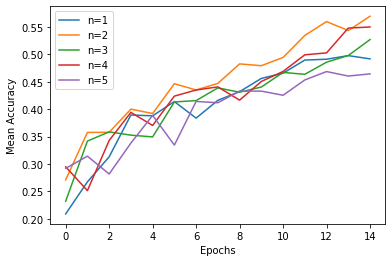

In [12]:
ax = None
for d in analysis3.trial_dataframes.values():
  ax = d.mean_accuracy.plot(ax=ax)
ax.set_xlabel("Epochs")
ax.set_ylabel("Mean Accuracy")
ax.legend(['n=1','n=2','n=3', 'n=4', 'n=5'])

In [13]:
# Config for ResNet hyperparameter sensitivity analysis for lr
config = {
    "lr": tune.grid_search([0.1]),
    "momentum": tune.grid_search([0.9]),
    "weight_decay": tune.grid_search([0.0001]),
    "n": tune.grid_search([3]),
    "width": tune.grid_search([0.25, 0.5, 1, 2, 4])
}

datasets.CIFAR10("~/data", train=True, download=True)

analysis4 = tune.run(train_cifar, config=config, resources_per_trial={"cpu": 1, "gpu": 1})

Files already downloaded and verified


2022-04-21 00:43:47,588	WARNING callback.py:126 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`
2022-04-21 00:43:47,715	INFO trial_runner.py:803 -- starting train_cifar_1ad9b_00000


(train_cifar pid=1542) Files already downloaded and verified
(train_cifar pid=1542) Files already downloaded and verified


(train_cifar pid=1542) Finished Training epoch 0


Result for train_cifar_1ad9b_00000:
  date: 2022-04-21_00-44-16
  done: false
  experiment_id: 2b72db1bfc5148ce9c36b61bb5434285
  hostname: 1255c898887d
  iterations_since_restore: 1
  mean_accuracy: 0.1781
  node_ip: 172.28.0.2
  pid: 1542
  time_since_restore: 25.957906246185303
  time_this_iter_s: 25.957906246185303
  time_total_s: 25.957906246185303
  timestamp: 1650501856
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 1ad9b_00000
  warmup_time: 0.0048351287841796875
  
(train_cifar pid=1542) epoch 1 test_loss 178.82928133010864 test_steps 79 test_acc 0.1781


(train_cifar pid=1542) Finished Training epoch 1


Result for train_cifar_1ad9b_00000:
  date: 2022-04-21_00-44-36
  done: false
  experiment_id: 2b72db1bfc5148ce9c36b61bb5434285
  hostname: 1255c898887d
  iterations_since_restore: 2
  mean_accuracy: 0.2312
  node_ip: 172.28.0.2
  pid: 1542
  time_since_restore: 46.61935353279114
  time_this_iter_s: 20.661447286605835
  time_total_s: 46.61935353279114
  timestamp: 1650501876
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 1ad9b_00000
  warmup_time: 0.0048351287841796875
  
(train_cifar pid=1542) epoch 1 test_loss 174.8720691204071 test_steps 79 test_acc 0.2312


(train_cifar pid=1542) Finished Training epoch 2


Result for train_cifar_1ad9b_00000:
  date: 2022-04-21_00-44-57
  done: false
  experiment_id: 2b72db1bfc5148ce9c36b61bb5434285
  hostname: 1255c898887d
  iterations_since_restore: 3
  mean_accuracy: 0.2439
  node_ip: 172.28.0.2
  pid: 1542
  time_since_restore: 67.84488654136658
  time_this_iter_s: 21.22553300857544
  time_total_s: 67.84488654136658
  timestamp: 1650501897
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 1ad9b_00000
  warmup_time: 0.0048351287841796875
  
(train_cifar pid=1542) epoch 1 test_loss 174.07310819625854 test_steps 79 test_acc 0.2439


(train_cifar pid=1542) Finished Training epoch 3


Result for train_cifar_1ad9b_00000:
  date: 2022-04-21_00-45-18
  done: false
  experiment_id: 2b72db1bfc5148ce9c36b61bb5434285
  hostname: 1255c898887d
  iterations_since_restore: 4
  mean_accuracy: 0.2813
  node_ip: 172.28.0.2
  pid: 1542
  time_since_restore: 88.2209541797638
  time_this_iter_s: 20.376067638397217
  time_total_s: 88.2209541797638
  timestamp: 1650501918
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 1ad9b_00000
  warmup_time: 0.0048351287841796875
  
(train_cifar pid=1542) epoch 1 test_loss 171.033842086792 test_steps 79 test_acc 0.2813


(train_cifar pid=1542) Finished Training epoch 4


Result for train_cifar_1ad9b_00000:
  date: 2022-04-21_00-45-38
  done: false
  experiment_id: 2b72db1bfc5148ce9c36b61bb5434285
  hostname: 1255c898887d
  iterations_since_restore: 5
  mean_accuracy: 0.2871
  node_ip: 172.28.0.2
  pid: 1542
  time_since_restore: 108.28456044197083
  time_this_iter_s: 20.06360626220703
  time_total_s: 108.28456044197083
  timestamp: 1650501938
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 1ad9b_00000
  warmup_time: 0.0048351287841796875
  
(train_cifar pid=1542) epoch 1 test_loss 170.60485982894897 test_steps 79 test_acc 0.2871


(train_cifar pid=1542) Finished Training epoch 5


Result for train_cifar_1ad9b_00000:
  date: 2022-04-21_00-45-58
  done: false
  experiment_id: 2b72db1bfc5148ce9c36b61bb5434285
  hostname: 1255c898887d
  iterations_since_restore: 6
  mean_accuracy: 0.2887
  node_ip: 172.28.0.2
  pid: 1542
  time_since_restore: 128.39603638648987
  time_this_iter_s: 20.111475944519043
  time_total_s: 128.39603638648987
  timestamp: 1650501958
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 1ad9b_00000
  warmup_time: 0.0048351287841796875
  
(train_cifar pid=1542) epoch 1 test_loss 170.74050998687744 test_steps 79 test_acc 0.2887


(train_cifar pid=1542) Finished Training epoch 6


Result for train_cifar_1ad9b_00000:
  date: 2022-04-21_00-46-19
  done: false
  experiment_id: 2b72db1bfc5148ce9c36b61bb5434285
  hostname: 1255c898887d
  iterations_since_restore: 7
  mean_accuracy: 0.328
  node_ip: 172.28.0.2
  pid: 1542
  time_since_restore: 149.66223669052124
  time_this_iter_s: 21.266200304031372
  time_total_s: 149.66223669052124
  timestamp: 1650501979
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 1ad9b_00000
  warmup_time: 0.0048351287841796875
  
(train_cifar pid=1542) epoch 1 test_loss 167.6907925605774 test_steps 79 test_acc 0.328


(train_cifar pid=1542) Finished Training epoch 7


Result for train_cifar_1ad9b_00000:
  date: 2022-04-21_00-46-39
  done: false
  experiment_id: 2b72db1bfc5148ce9c36b61bb5434285
  hostname: 1255c898887d
  iterations_since_restore: 8
  mean_accuracy: 0.3175
  node_ip: 172.28.0.2
  pid: 1542
  time_since_restore: 169.8678915500641
  time_this_iter_s: 20.205654859542847
  time_total_s: 169.8678915500641
  timestamp: 1650501999
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 1ad9b_00000
  warmup_time: 0.0048351287841796875
  
(train_cifar pid=1542) epoch 1 test_loss 168.62844514846802 test_steps 79 test_acc 0.3175


(train_cifar pid=1542) Finished Training epoch 8


Result for train_cifar_1ad9b_00000:
  date: 2022-04-21_00-47-00
  done: false
  experiment_id: 2b72db1bfc5148ce9c36b61bb5434285
  hostname: 1255c898887d
  iterations_since_restore: 9
  mean_accuracy: 0.3315
  node_ip: 172.28.0.2
  pid: 1542
  time_since_restore: 190.0678095817566
  time_this_iter_s: 20.199918031692505
  time_total_s: 190.0678095817566
  timestamp: 1650502020
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 1ad9b_00000
  warmup_time: 0.0048351287841796875
  
(train_cifar pid=1542) epoch 1 test_loss 167.5310287475586 test_steps 79 test_acc 0.3315


(train_cifar pid=1542) Finished Training epoch 9


Result for train_cifar_1ad9b_00000:
  date: 2022-04-21_00-47-20
  done: false
  experiment_id: 2b72db1bfc5148ce9c36b61bb5434285
  hostname: 1255c898887d
  iterations_since_restore: 10
  mean_accuracy: 0.3612
  node_ip: 172.28.0.2
  pid: 1542
  time_since_restore: 210.3831660747528
  time_this_iter_s: 20.315356492996216
  time_total_s: 210.3831660747528
  timestamp: 1650502040
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 1ad9b_00000
  warmup_time: 0.0048351287841796875
  
(train_cifar pid=1542) epoch 1 test_loss 165.30916368961334 test_steps 79 test_acc 0.3612


(train_cifar pid=1542) Finished Training epoch 10


Result for train_cifar_1ad9b_00000:
  date: 2022-04-21_00-47-41
  done: false
  experiment_id: 2b72db1bfc5148ce9c36b61bb5434285
  hostname: 1255c898887d
  iterations_since_restore: 11
  mean_accuracy: 0.389
  node_ip: 172.28.0.2
  pid: 1542
  time_since_restore: 231.43983006477356
  time_this_iter_s: 21.056663990020752
  time_total_s: 231.43983006477356
  timestamp: 1650502061
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 1ad9b_00000
  warmup_time: 0.0048351287841796875
  
(train_cifar pid=1542) epoch 1 test_loss 163.17778205871582 test_steps 79 test_acc 0.389


(train_cifar pid=1542) Finished Training epoch 11
Result for train_cifar_1ad9b_00000:
  date: 2022-04-21_00-48-01
  done: false
  experiment_id: 2b72db1bfc5148ce9c36b61bb5434285
  hostname: 1255c898887d
  iterations_since_restore: 12
  mean_accuracy: 0.3856
  node_ip: 172.28.0.2
  pid: 1542
  time_since_restore: 251.35673356056213
  time_this_iter_s: 19.916903495788574
  time_total_s: 251.35673356056213
  timestamp: 1650502081
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: 1ad9b_00000
  warmup_time: 0.0048351287841796875
  
(train_cifar pid=1542) epoch 1 test_loss 162.97172248363495 test_steps 79 test_acc 0.3856


(train_cifar pid=1542) Finished Training epoch 12
Result for train_cifar_1ad9b_00000:
  date: 2022-04-21_00-48-21
  done: false
  experiment_id: 2b72db1bfc5148ce9c36b61bb5434285
  hostname: 1255c898887d
  iterations_since_restore: 13
  mean_accuracy: 0.395
  node_ip: 172.28.0.2
  pid: 1542
  time_since_restore: 271.16653418540955
  time_this_iter_s: 19.809800624847412
  time_total_s: 271.16653418540955
  timestamp: 1650502101
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: 1ad9b_00000
  warmup_time: 0.0048351287841796875
  
(train_cifar pid=1542) epoch 1 test_loss 162.8620150089264 test_steps 79 test_acc 0.395


(train_cifar pid=1542) Finished Training epoch 13


Result for train_cifar_1ad9b_00000:
  date: 2022-04-21_00-48-42
  done: false
  experiment_id: 2b72db1bfc5148ce9c36b61bb5434285
  hostname: 1255c898887d
  iterations_since_restore: 14
  mean_accuracy: 0.3623
  node_ip: 172.28.0.2
  pid: 1542
  time_since_restore: 292.0490474700928
  time_this_iter_s: 20.882513284683228
  time_total_s: 292.0490474700928
  timestamp: 1650502122
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: 1ad9b_00000
  warmup_time: 0.0048351287841796875
  
(train_cifar pid=1542) epoch 1 test_loss 165.0171253681183 test_steps 79 test_acc 0.3623


(train_cifar pid=1542) Finished Training epoch 14


Result for train_cifar_1ad9b_00000:
  date: 2022-04-21_00-49-02
  done: false
  experiment_id: 2b72db1bfc5148ce9c36b61bb5434285
  hostname: 1255c898887d
  iterations_since_restore: 15
  mean_accuracy: 0.4109
  node_ip: 172.28.0.2
  pid: 1542
  time_since_restore: 312.4241919517517
  time_this_iter_s: 20.375144481658936
  time_total_s: 312.4241919517517
  timestamp: 1650502142
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: 1ad9b_00000
  warmup_time: 0.0048351287841796875
  
Result for train_cifar_1ad9b_00000:
  date: 2022-04-21_00-49-02
  done: true
  experiment_id: 2b72db1bfc5148ce9c36b61bb5434285
  experiment_tag: 0_lr=0.1,momentum=0.9,n=3,weight_decay=0.0001,width=0.25
  hostname: 1255c898887d
  iterations_since_restore: 15
  mean_accuracy: 0.4109
  node_ip: 172.28.0.2
  pid: 1542
  time_since_restore: 312.4241919517517
  time_this_iter_s: 20.375144481658936
  time_total_s: 312.4241919517517
  timestamp: 1650502142
  timesteps_since_restore: 0
  training_iteration:

2022-04-21 00:49:03,074	INFO trial_runner.py:803 -- starting train_cifar_1ad9b_00001


(train_cifar pid=1679) Files already downloaded and verified
(train_cifar pid=1679) Files already downloaded and verified


(train_cifar pid=1679) Finished Training epoch 0
Result for train_cifar_1ad9b_00001:
  date: 2022-04-21_00-49-31
  done: false
  experiment_id: 567b6129f7bb435697b80e3708ab6a83
  hostname: 1255c898887d
  iterations_since_restore: 1
  mean_accuracy: 0.1787
  node_ip: 172.28.0.2
  pid: 1679
  time_since_restore: 26.490305185317993
  time_this_iter_s: 26.490305185317993
  time_total_s: 26.490305185317993
  timestamp: 1650502171
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 1ad9b_00001
  warmup_time: 0.0034112930297851562
  
(train_cifar pid=1679) epoch 1 test_loss 177.57986044883728 test_steps 79 test_acc 0.1787


(train_cifar pid=1679) Finished Training epoch 1


Result for train_cifar_1ad9b_00001:
  date: 2022-04-21_00-49-53
  done: false
  experiment_id: 567b6129f7bb435697b80e3708ab6a83
  hostname: 1255c898887d
  iterations_since_restore: 2
  mean_accuracy: 0.2656
  node_ip: 172.28.0.2
  pid: 1679
  time_since_restore: 47.79319453239441
  time_this_iter_s: 21.302889347076416
  time_total_s: 47.79319453239441
  timestamp: 1650502193
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 1ad9b_00001
  warmup_time: 0.0034112930297851562
  
(train_cifar pid=1679) epoch 1 test_loss 172.4082431793213 test_steps 79 test_acc 0.2656


(train_cifar pid=1679) Finished Training epoch 2


Result for train_cifar_1ad9b_00001:
  date: 2022-04-21_00-50-14
  done: false
  experiment_id: 567b6129f7bb435697b80e3708ab6a83
  hostname: 1255c898887d
  iterations_since_restore: 3
  mean_accuracy: 0.332
  node_ip: 172.28.0.2
  pid: 1679
  time_since_restore: 69.06911706924438
  time_this_iter_s: 21.275922536849976
  time_total_s: 69.06911706924438
  timestamp: 1650502214
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 1ad9b_00001
  warmup_time: 0.0034112930297851562
  
(train_cifar pid=1679) epoch 1 test_loss 167.914231300354 test_steps 79 test_acc 0.332


(train_cifar pid=1679) Finished Training epoch 3


Result for train_cifar_1ad9b_00001:
  date: 2022-04-21_00-50-35
  done: false
  experiment_id: 567b6129f7bb435697b80e3708ab6a83
  hostname: 1255c898887d
  iterations_since_restore: 4
  mean_accuracy: 0.3446
  node_ip: 172.28.0.2
  pid: 1679
  time_since_restore: 89.79259729385376
  time_this_iter_s: 20.723480224609375
  time_total_s: 89.79259729385376
  timestamp: 1650502235
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 1ad9b_00001
  warmup_time: 0.0034112930297851562
  
(train_cifar pid=1679) epoch 1 test_loss 166.77261805534363 test_steps 79 test_acc 0.3446


(train_cifar pid=1679) Finished Training epoch 4


Result for train_cifar_1ad9b_00001:
  date: 2022-04-21_00-50-55
  done: false
  experiment_id: 567b6129f7bb435697b80e3708ab6a83
  hostname: 1255c898887d
  iterations_since_restore: 5
  mean_accuracy: 0.3217
  node_ip: 172.28.0.2
  pid: 1679
  time_since_restore: 110.3827748298645
  time_this_iter_s: 20.590177536010742
  time_total_s: 110.3827748298645
  timestamp: 1650502255
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 1ad9b_00001
  warmup_time: 0.0034112930297851562
  
(train_cifar pid=1679) epoch 1 test_loss 168.45853304862976 test_steps 79 test_acc 0.3217


(train_cifar pid=1679) Finished Training epoch 5


Result for train_cifar_1ad9b_00001:
  date: 2022-04-21_00-51-17
  done: false
  experiment_id: 567b6129f7bb435697b80e3708ab6a83
  hostname: 1255c898887d
  iterations_since_restore: 6
  mean_accuracy: 0.3107
  node_ip: 172.28.0.2
  pid: 1679
  time_since_restore: 132.31569981575012
  time_this_iter_s: 21.93292498588562
  time_total_s: 132.31569981575012
  timestamp: 1650502277
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 1ad9b_00001
  warmup_time: 0.0034112930297851562
  
(train_cifar pid=1679) epoch 1 test_loss 168.82838320732117 test_steps 79 test_acc 0.3107


(train_cifar pid=1679) Finished Training epoch 6


Result for train_cifar_1ad9b_00001:
  date: 2022-04-21_00-51-38
  done: false
  experiment_id: 567b6129f7bb435697b80e3708ab6a83
  hostname: 1255c898887d
  iterations_since_restore: 7
  mean_accuracy: 0.3488
  node_ip: 172.28.0.2
  pid: 1679
  time_since_restore: 153.43405413627625
  time_this_iter_s: 21.118354320526123
  time_total_s: 153.43405413627625
  timestamp: 1650502298
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 1ad9b_00001
  warmup_time: 0.0034112930297851562
  
(train_cifar pid=1679) epoch 1 test_loss 166.1905002593994 test_steps 79 test_acc 0.3488


(train_cifar pid=1679) Finished Training epoch 7


Result for train_cifar_1ad9b_00001:
  date: 2022-04-21_00-51-59
  done: false
  experiment_id: 567b6129f7bb435697b80e3708ab6a83
  hostname: 1255c898887d
  iterations_since_restore: 8
  mean_accuracy: 0.3728
  node_ip: 172.28.0.2
  pid: 1679
  time_since_restore: 174.23785018920898
  time_this_iter_s: 20.80379605293274
  time_total_s: 174.23785018920898
  timestamp: 1650502319
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 1ad9b_00001
  warmup_time: 0.0034112930297851562
  
(train_cifar pid=1679) epoch 1 test_loss 164.25439596176147 test_steps 79 test_acc 0.3728


(train_cifar pid=1679) Finished Training epoch 8


Result for train_cifar_1ad9b_00001:
  date: 2022-04-21_00-52-20
  done: false
  experiment_id: 567b6129f7bb435697b80e3708ab6a83
  hostname: 1255c898887d
  iterations_since_restore: 9
  mean_accuracy: 0.3715
  node_ip: 172.28.0.2
  pid: 1679
  time_since_restore: 195.33613276481628
  time_this_iter_s: 21.0982825756073
  time_total_s: 195.33613276481628
  timestamp: 1650502340
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 1ad9b_00001
  warmup_time: 0.0034112930297851562
  
(train_cifar pid=1679) epoch 1 test_loss 164.6839838027954 test_steps 79 test_acc 0.3715


(train_cifar pid=1679) Finished Training epoch 9


Result for train_cifar_1ad9b_00001:
  date: 2022-04-21_00-52-42
  done: false
  experiment_id: 567b6129f7bb435697b80e3708ab6a83
  hostname: 1255c898887d
  iterations_since_restore: 10
  mean_accuracy: 0.3773
  node_ip: 172.28.0.2
  pid: 1679
  time_since_restore: 216.9672703742981
  time_this_iter_s: 21.63113760948181
  time_total_s: 216.9672703742981
  timestamp: 1650502362
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 1ad9b_00001
  warmup_time: 0.0034112930297851562
  
(train_cifar pid=1679) epoch 1 test_loss 164.25840044021606 test_steps 79 test_acc 0.3773


(train_cifar pid=1679) Finished Training epoch 10


Result for train_cifar_1ad9b_00001:
  date: 2022-04-21_00-53-03
  done: false
  experiment_id: 567b6129f7bb435697b80e3708ab6a83
  hostname: 1255c898887d
  iterations_since_restore: 11
  mean_accuracy: 0.4084
  node_ip: 172.28.0.2
  pid: 1679
  time_since_restore: 237.84520530700684
  time_this_iter_s: 20.87793493270874
  time_total_s: 237.84520530700684
  timestamp: 1650502383
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 1ad9b_00001
  warmup_time: 0.0034112930297851562
  
(train_cifar pid=1679) epoch 1 test_loss 161.85211443901062 test_steps 79 test_acc 0.4084


(train_cifar pid=1679) Finished Training epoch 11


Result for train_cifar_1ad9b_00001:
  date: 2022-04-21_00-53-24
  done: false
  experiment_id: 567b6129f7bb435697b80e3708ab6a83
  hostname: 1255c898887d
  iterations_since_restore: 12
  mean_accuracy: 0.3833
  node_ip: 172.28.0.2
  pid: 1679
  time_since_restore: 258.67940735816956
  time_this_iter_s: 20.83420205116272
  time_total_s: 258.67940735816956
  timestamp: 1650502404
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: 1ad9b_00001
  warmup_time: 0.0034112930297851562
  
(train_cifar pid=1679) epoch 1 test_loss 163.70896792411804 test_steps 79 test_acc 0.3833


(train_cifar pid=1679) Finished Training epoch 12


Result for train_cifar_1ad9b_00001:
  date: 2022-04-21_00-53-46
  done: false
  experiment_id: 567b6129f7bb435697b80e3708ab6a83
  hostname: 1255c898887d
  iterations_since_restore: 13
  mean_accuracy: 0.4009
  node_ip: 172.28.0.2
  pid: 1679
  time_since_restore: 280.68642258644104
  time_this_iter_s: 22.007015228271484
  time_total_s: 280.68642258644104
  timestamp: 1650502426
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: 1ad9b_00001
  warmup_time: 0.0034112930297851562
  
(train_cifar pid=1679) epoch 1 test_loss 162.49941062927246 test_steps 79 test_acc 0.4009


(train_cifar pid=1679) Finished Training epoch 13


Result for train_cifar_1ad9b_00001:
  date: 2022-04-21_00-54-06
  done: false
  experiment_id: 567b6129f7bb435697b80e3708ab6a83
  hostname: 1255c898887d
  iterations_since_restore: 14
  mean_accuracy: 0.4494
  node_ip: 172.28.0.2
  pid: 1679
  time_since_restore: 301.4833972454071
  time_this_iter_s: 20.796974658966064
  time_total_s: 301.4833972454071
  timestamp: 1650502446
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: 1ad9b_00001
  warmup_time: 0.0034112930297851562
  
(train_cifar pid=1679) epoch 1 test_loss 158.5390430688858 test_steps 79 test_acc 0.4494


(train_cifar pid=1679) Finished Training epoch 14


Result for train_cifar_1ad9b_00001:
  date: 2022-04-21_00-54-27
  done: false
  experiment_id: 567b6129f7bb435697b80e3708ab6a83
  hostname: 1255c898887d
  iterations_since_restore: 15
  mean_accuracy: 0.417
  node_ip: 172.28.0.2
  pid: 1679
  time_since_restore: 322.1092345714569
  time_this_iter_s: 20.625837326049805
  time_total_s: 322.1092345714569
  timestamp: 1650502467
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: 1ad9b_00001
  warmup_time: 0.0034112930297851562
  
Result for train_cifar_1ad9b_00001:
  date: 2022-04-21_00-54-27
  done: true
  experiment_id: 567b6129f7bb435697b80e3708ab6a83
  experiment_tag: 1_lr=0.1,momentum=0.9,n=3,weight_decay=0.0001,width=0.5
  hostname: 1255c898887d
  iterations_since_restore: 15
  mean_accuracy: 0.417
  node_ip: 172.28.0.2
  pid: 1679
  time_since_restore: 322.1092345714569
  time_this_iter_s: 20.625837326049805
  time_total_s: 322.1092345714569
  timestamp: 1650502467
  timesteps_since_restore: 0
  training_iteration: 15

2022-04-21 00:54:28,114	INFO trial_runner.py:803 -- starting train_cifar_1ad9b_00002


(train_cifar pid=1822) Files already downloaded and verified
(train_cifar pid=1822) Files already downloaded and verified


(train_cifar pid=1822) Finished Training epoch 0


Result for train_cifar_1ad9b_00002:
  date: 2022-04-21_00-54-59
  done: false
  experiment_id: 556ee323a771468fa0076d64f6bd631a
  hostname: 1255c898887d
  iterations_since_restore: 1
  mean_accuracy: 0.263
  node_ip: 172.28.0.2
  pid: 1822
  time_since_restore: 28.686506509780884
  time_this_iter_s: 28.686506509780884
  time_total_s: 28.686506509780884
  timestamp: 1650502499
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 1ad9b_00002
  warmup_time: 0.0031507015228271484
  
(train_cifar pid=1822) epoch 1 test_loss 172.59470129013062 test_steps 79 test_acc 0.263


(train_cifar pid=1822) Finished Training epoch 1


Result for train_cifar_1ad9b_00002:
  date: 2022-04-21_00-55-20
  done: false
  experiment_id: 556ee323a771468fa0076d64f6bd631a
  hostname: 1255c898887d
  iterations_since_restore: 2
  mean_accuracy: 0.3207
  node_ip: 172.28.0.2
  pid: 1822
  time_since_restore: 50.621222734451294
  time_this_iter_s: 21.93471622467041
  time_total_s: 50.621222734451294
  timestamp: 1650502520
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 1ad9b_00002
  warmup_time: 0.0031507015228271484
  
(train_cifar pid=1822) epoch 1 test_loss 168.48622941970825 test_steps 79 test_acc 0.3207


(train_cifar pid=1822) Finished Training epoch 2


Result for train_cifar_1ad9b_00002:
  date: 2022-04-21_00-55-42
  done: false
  experiment_id: 556ee323a771468fa0076d64f6bd631a
  hostname: 1255c898887d
  iterations_since_restore: 3
  mean_accuracy: 0.3838
  node_ip: 172.28.0.2
  pid: 1822
  time_since_restore: 72.3809814453125
  time_this_iter_s: 21.759758710861206
  time_total_s: 72.3809814453125
  timestamp: 1650502542
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 1ad9b_00002
  warmup_time: 0.0031507015228271484
  
(train_cifar pid=1822) epoch 1 test_loss 163.6927125453949 test_steps 79 test_acc 0.3838


(train_cifar pid=1822) Finished Training epoch 3


Result for train_cifar_1ad9b_00002:
  date: 2022-04-21_00-56-04
  done: false
  experiment_id: 556ee323a771468fa0076d64f6bd631a
  hostname: 1255c898887d
  iterations_since_restore: 4
  mean_accuracy: 0.4131
  node_ip: 172.28.0.2
  pid: 1822
  time_since_restore: 94.49710583686829
  time_this_iter_s: 22.116124391555786
  time_total_s: 94.49710583686829
  timestamp: 1650502564
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 1ad9b_00002
  warmup_time: 0.0031507015228271484
  
(train_cifar pid=1822) epoch 1 test_loss 161.3257942199707 test_steps 79 test_acc 0.4131


(train_cifar pid=1822) Finished Training epoch 4
Result for train_cifar_1ad9b_00002:
  date: 2022-04-21_00-56-27
  done: false
  experiment_id: 556ee323a771468fa0076d64f6bd631a
  hostname: 1255c898887d
  iterations_since_restore: 5
  mean_accuracy: 0.4257
  node_ip: 172.28.0.2
  pid: 1822
  time_since_restore: 116.99999165534973
  time_this_iter_s: 22.502885818481445
  time_total_s: 116.99999165534973
  timestamp: 1650502587
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 1ad9b_00002
  warmup_time: 0.0031507015228271484
  
(train_cifar pid=1822) epoch 1 test_loss 160.31951212882996 test_steps 79 test_acc 0.4257


(train_cifar pid=1822) Finished Training epoch 5


Result for train_cifar_1ad9b_00002:
  date: 2022-04-21_00-56-49
  done: false
  experiment_id: 556ee323a771468fa0076d64f6bd631a
  hostname: 1255c898887d
  iterations_since_restore: 6
  mean_accuracy: 0.4342
  node_ip: 172.28.0.2
  pid: 1822
  time_since_restore: 138.87153458595276
  time_this_iter_s: 21.871542930603027
  time_total_s: 138.87153458595276
  timestamp: 1650502609
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 1ad9b_00002
  warmup_time: 0.0031507015228271484
  
(train_cifar pid=1822) epoch 1 test_loss 159.78531730175018 test_steps 79 test_acc 0.4342


(train_cifar pid=1822) Finished Training epoch 6


Result for train_cifar_1ad9b_00002:
  date: 2022-04-21_00-57-10
  done: false
  experiment_id: 556ee323a771468fa0076d64f6bd631a
  hostname: 1255c898887d
  iterations_since_restore: 7
  mean_accuracy: 0.4015
  node_ip: 172.28.0.2
  pid: 1822
  time_since_restore: 160.40975522994995
  time_this_iter_s: 21.538220643997192
  time_total_s: 160.40975522994995
  timestamp: 1650502630
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 1ad9b_00002
  warmup_time: 0.0031507015228271484
  
(train_cifar pid=1822) epoch 1 test_loss 162.2508101463318 test_steps 79 test_acc 0.4015


(train_cifar pid=1822) Finished Training epoch 7
Result for train_cifar_1ad9b_00002:
  date: 2022-04-21_00-57-33
  done: false
  experiment_id: 556ee323a771468fa0076d64f6bd631a
  hostname: 1255c898887d
  iterations_since_restore: 8
  mean_accuracy: 0.4494
  node_ip: 172.28.0.2
  pid: 1822
  time_since_restore: 183.48882579803467
  time_this_iter_s: 23.079070568084717
  time_total_s: 183.48882579803467
  timestamp: 1650502653
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 1ad9b_00002
  warmup_time: 0.0031507015228271484
  
(train_cifar pid=1822) epoch 1 test_loss 158.41634154319763 test_steps 79 test_acc 0.4494


(train_cifar pid=1822) Finished Training epoch 8


Result for train_cifar_1ad9b_00002:
  date: 2022-04-21_00-57-55
  done: false
  experiment_id: 556ee323a771468fa0076d64f6bd631a
  hostname: 1255c898887d
  iterations_since_restore: 9
  mean_accuracy: 0.451
  node_ip: 172.28.0.2
  pid: 1822
  time_since_restore: 205.08659267425537
  time_this_iter_s: 21.597766876220703
  time_total_s: 205.08659267425537
  timestamp: 1650502675
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 1ad9b_00002
  warmup_time: 0.0031507015228271484
  
(train_cifar pid=1822) epoch 1 test_loss 158.62613034248352 test_steps 79 test_acc 0.451


(train_cifar pid=1822) Finished Training epoch 9


Result for train_cifar_1ad9b_00002:
  date: 2022-04-21_00-58-16
  done: false
  experiment_id: 556ee323a771468fa0076d64f6bd631a
  hostname: 1255c898887d
  iterations_since_restore: 10
  mean_accuracy: 0.4821
  node_ip: 172.28.0.2
  pid: 1822
  time_since_restore: 226.60659861564636
  time_this_iter_s: 21.52000594139099
  time_total_s: 226.60659861564636
  timestamp: 1650502696
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 1ad9b_00002
  warmup_time: 0.0031507015228271484
  
(train_cifar pid=1822) epoch 1 test_loss 156.0927336215973 test_steps 79 test_acc 0.4821


(train_cifar pid=1822) Finished Training epoch 10
Result for train_cifar_1ad9b_00002:
  date: 2022-04-21_00-58-39
  done: false
  experiment_id: 556ee323a771468fa0076d64f6bd631a
  hostname: 1255c898887d
  iterations_since_restore: 11
  mean_accuracy: 0.49
  node_ip: 172.28.0.2
  pid: 1822
  time_since_restore: 249.10060739517212
  time_this_iter_s: 22.494008779525757
  time_total_s: 249.10060739517212
  timestamp: 1650502719
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 1ad9b_00002
  warmup_time: 0.0031507015228271484
  
(train_cifar pid=1822) epoch 1 test_loss 155.27830982208252 test_steps 79 test_acc 0.49


(train_cifar pid=1822) Finished Training epoch 11


Result for train_cifar_1ad9b_00002:
  date: 2022-04-21_00-59-01
  done: false
  experiment_id: 556ee323a771468fa0076d64f6bd631a
  hostname: 1255c898887d
  iterations_since_restore: 12
  mean_accuracy: 0.4819
  node_ip: 172.28.0.2
  pid: 1822
  time_since_restore: 271.3168730735779
  time_this_iter_s: 22.21626567840576
  time_total_s: 271.3168730735779
  timestamp: 1650502741
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: 1ad9b_00002
  warmup_time: 0.0031507015228271484
  
(train_cifar pid=1822) epoch 1 test_loss 155.98932468891144 test_steps 79 test_acc 0.4819


(train_cifar pid=1822) Finished Training epoch 12


Result for train_cifar_1ad9b_00002:
  date: 2022-04-21_00-59-23
  done: false
  experiment_id: 556ee323a771468fa0076d64f6bd631a
  hostname: 1255c898887d
  iterations_since_restore: 13
  mean_accuracy: 0.513
  node_ip: 172.28.0.2
  pid: 1822
  time_since_restore: 293.0615563392639
  time_this_iter_s: 21.744683265686035
  time_total_s: 293.0615563392639
  timestamp: 1650502763
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: 1ad9b_00002
  warmup_time: 0.0031507015228271484
  
(train_cifar pid=1822) epoch 1 test_loss 153.58413898944855 test_steps 79 test_acc 0.513


(train_cifar pid=1822) Finished Training epoch 13


Result for train_cifar_1ad9b_00002:
  date: 2022-04-21_00-59-45
  done: false
  experiment_id: 556ee323a771468fa0076d64f6bd631a
  hostname: 1255c898887d
  iterations_since_restore: 14
  mean_accuracy: 0.5327
  node_ip: 172.28.0.2
  pid: 1822
  time_since_restore: 314.8615107536316
  time_this_iter_s: 21.799954414367676
  time_total_s: 314.8615107536316
  timestamp: 1650502785
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: 1ad9b_00002
  warmup_time: 0.0031507015228271484
  
(train_cifar pid=1822) epoch 1 test_loss 152.02116549015045 test_steps 79 test_acc 0.5327


(train_cifar pid=1822) Finished Training epoch 14
Result for train_cifar_1ad9b_00002:
  date: 2022-04-21_01-00-07
  done: false
  experiment_id: 556ee323a771468fa0076d64f6bd631a
  hostname: 1255c898887d
  iterations_since_restore: 15
  mean_accuracy: 0.5308
  node_ip: 172.28.0.2
  pid: 1822
  time_since_restore: 337.567036151886
  time_this_iter_s: 22.705525398254395
  time_total_s: 337.567036151886
  timestamp: 1650502807
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: 1ad9b_00002
  warmup_time: 0.0031507015228271484
  
Result for train_cifar_1ad9b_00002:
  date: 2022-04-21_01-00-07
  done: true
  experiment_id: 556ee323a771468fa0076d64f6bd631a
  experiment_tag: 2_lr=0.1,momentum=0.9,n=3,weight_decay=0.0001,width=1
  hostname: 1255c898887d
  iterations_since_restore: 15
  mean_accuracy: 0.5308
  node_ip: 172.28.0.2
  pid: 1822
  time_since_restore: 337.567036151886
  time_this_iter_s: 22.705525398254395
  time_total_s: 337.567036151886
  timestamp: 1650502807
  times

2022-04-21 01:00:08,167	INFO trial_runner.py:803 -- starting train_cifar_1ad9b_00003


(train_cifar pid=1989) Files already downloaded and verified
(train_cifar pid=1989) Files already downloaded and verified


(train_cifar pid=1989) Finished Training epoch 0
Result for train_cifar_1ad9b_00003:
  date: 2022-04-21_01-00-46
  done: false
  experiment_id: cba5185ccb8649249b063d9a0075e5bf
  hostname: 1255c898887d
  iterations_since_restore: 1
  mean_accuracy: 0.321
  node_ip: 172.28.0.2
  pid: 1989
  time_since_restore: 36.08729934692383
  time_this_iter_s: 36.08729934692383
  time_total_s: 36.08729934692383
  timestamp: 1650502846
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 1ad9b_00003
  warmup_time: 0.0031757354736328125
  
(train_cifar pid=1989) epoch 1 test_loss 167.927227973938 test_steps 79 test_acc 0.321


(train_cifar pid=1989) Finished Training epoch 1
Result for train_cifar_1ad9b_00003:
  date: 2022-04-21_01-01-16
  done: false
  experiment_id: cba5185ccb8649249b063d9a0075e5bf
  hostname: 1255c898887d
  iterations_since_restore: 2
  mean_accuracy: 0.3797
  node_ip: 172.28.0.2
  pid: 1989
  time_since_restore: 66.08598303794861
  time_this_iter_s: 29.99868369102478
  time_total_s: 66.08598303794861
  timestamp: 1650502876
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 1ad9b_00003
  warmup_time: 0.0031757354736328125
  
(train_cifar pid=1989) epoch 1 test_loss 164.0872803926468 test_steps 79 test_acc 0.3797


(train_cifar pid=1989) Finished Training epoch 2
Result for train_cifar_1ad9b_00003:
  date: 2022-04-21_01-01-46
  done: false
  experiment_id: cba5185ccb8649249b063d9a0075e5bf
  hostname: 1255c898887d
  iterations_since_restore: 3
  mean_accuracy: 0.4191
  node_ip: 172.28.0.2
  pid: 1989
  time_since_restore: 95.82543158531189
  time_this_iter_s: 29.73944854736328
  time_total_s: 95.82543158531189
  timestamp: 1650502906
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 1ad9b_00003
  warmup_time: 0.0031757354736328125
  
(train_cifar pid=1989) epoch 1 test_loss 161.08169639110565 test_steps 79 test_acc 0.4191


(train_cifar pid=1989) Finished Training epoch 3
Result for train_cifar_1ad9b_00003:
  date: 2022-04-21_01-02-16
  done: false
  experiment_id: cba5185ccb8649249b063d9a0075e5bf
  hostname: 1255c898887d
  iterations_since_restore: 4
  mean_accuracy: 0.4402
  node_ip: 172.28.0.2
  pid: 1989
  time_since_restore: 125.73958110809326
  time_this_iter_s: 29.914149522781372
  time_total_s: 125.73958110809326
  timestamp: 1650502936
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 1ad9b_00003
  warmup_time: 0.0031757354736328125
  
(train_cifar pid=1989) epoch 1 test_loss 159.1420794725418 test_steps 79 test_acc 0.4402


(train_cifar pid=1989) Finished Training epoch 4
Result for train_cifar_1ad9b_00003:
  date: 2022-04-21_01-02-45
  done: false
  experiment_id: cba5185ccb8649249b063d9a0075e5bf
  hostname: 1255c898887d
  iterations_since_restore: 5
  mean_accuracy: 0.4349
  node_ip: 172.28.0.2
  pid: 1989
  time_since_restore: 155.47574520111084
  time_this_iter_s: 29.736164093017578
  time_total_s: 155.47574520111084
  timestamp: 1650502965
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 1ad9b_00003
  warmup_time: 0.0031757354736328125
  
(train_cifar pid=1989) epoch 1 test_loss 159.45544910430908 test_steps 79 test_acc 0.4349


(train_cifar pid=1989) Finished Training epoch 5
Result for train_cifar_1ad9b_00003:
  date: 2022-04-21_01-03-15
  done: false
  experiment_id: cba5185ccb8649249b063d9a0075e5bf
  hostname: 1255c898887d
  iterations_since_restore: 6
  mean_accuracy: 0.4526
  node_ip: 172.28.0.2
  pid: 1989
  time_since_restore: 185.0938582420349
  time_this_iter_s: 29.618113040924072
  time_total_s: 185.0938582420349
  timestamp: 1650502995
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 1ad9b_00003
  warmup_time: 0.0031757354736328125
  
(train_cifar pid=1989) epoch 1 test_loss 158.28075850009918 test_steps 79 test_acc 0.4526


(train_cifar pid=1989) Finished Training epoch 6
Result for train_cifar_1ad9b_00003:
  date: 2022-04-21_01-03-45
  done: false
  experiment_id: cba5185ccb8649249b063d9a0075e5bf
  hostname: 1255c898887d
  iterations_since_restore: 7
  mean_accuracy: 0.5114
  node_ip: 172.28.0.2
  pid: 1989
  time_since_restore: 214.70434260368347
  time_this_iter_s: 29.61048436164856
  time_total_s: 214.70434260368347
  timestamp: 1650503025
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 1ad9b_00003
  warmup_time: 0.0031757354736328125
  
(train_cifar pid=1989) epoch 1 test_loss 153.53419423103333 test_steps 79 test_acc 0.5114


(train_cifar pid=1989) Finished Training epoch 7
Result for train_cifar_1ad9b_00003:
  date: 2022-04-21_01-04-14
  done: false
  experiment_id: cba5185ccb8649249b063d9a0075e5bf
  hostname: 1255c898887d
  iterations_since_restore: 8
  mean_accuracy: 0.5407
  node_ip: 172.28.0.2
  pid: 1989
  time_since_restore: 244.25229048728943
  time_this_iter_s: 29.547947883605957
  time_total_s: 244.25229048728943
  timestamp: 1650503054
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 1ad9b_00003
  warmup_time: 0.0031757354736328125
  
(train_cifar pid=1989) epoch 1 test_loss 151.34800791740417 test_steps 79 test_acc 0.5407


(train_cifar pid=1989) Finished Training epoch 8
Result for train_cifar_1ad9b_00003:
  date: 2022-04-21_01-04-44
  done: false
  experiment_id: cba5185ccb8649249b063d9a0075e5bf
  hostname: 1255c898887d
  iterations_since_restore: 9
  mean_accuracy: 0.5279
  node_ip: 172.28.0.2
  pid: 1989
  time_since_restore: 274.1016249656677
  time_this_iter_s: 29.849334478378296
  time_total_s: 274.1016249656677
  timestamp: 1650503084
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 1ad9b_00003
  warmup_time: 0.0031757354736328125
  
(train_cifar pid=1989) epoch 1 test_loss 152.48262894153595 test_steps 79 test_acc 0.5279


(train_cifar pid=1989) Finished Training epoch 9
Result for train_cifar_1ad9b_00003:
  date: 2022-04-21_01-05-14
  done: false
  experiment_id: cba5185ccb8649249b063d9a0075e5bf
  hostname: 1255c898887d
  iterations_since_restore: 10
  mean_accuracy: 0.5501
  node_ip: 172.28.0.2
  pid: 1989
  time_since_restore: 303.7414903640747
  time_this_iter_s: 29.639865398406982
  time_total_s: 303.7414903640747
  timestamp: 1650503114
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 1ad9b_00003
  warmup_time: 0.0031757354736328125
  
(train_cifar pid=1989) epoch 1 test_loss 150.82636320590973 test_steps 79 test_acc 0.5501


(train_cifar pid=1989) Finished Training epoch 10
Result for train_cifar_1ad9b_00003:
  date: 2022-04-21_01-05-43
  done: false
  experiment_id: cba5185ccb8649249b063d9a0075e5bf
  hostname: 1255c898887d
  iterations_since_restore: 11
  mean_accuracy: 0.5595
  node_ip: 172.28.0.2
  pid: 1989
  time_since_restore: 333.37113547325134
  time_this_iter_s: 29.629645109176636
  time_total_s: 333.37113547325134
  timestamp: 1650503143
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 1ad9b_00003
  warmup_time: 0.0031757354736328125
  
(train_cifar pid=1989) epoch 1 test_loss 149.8846493959427 test_steps 79 test_acc 0.5595


(train_cifar pid=1989) Finished Training epoch 11
Result for train_cifar_1ad9b_00003:
  date: 2022-04-21_01-06-13
  done: false
  experiment_id: cba5185ccb8649249b063d9a0075e5bf
  hostname: 1255c898887d
  iterations_since_restore: 12
  mean_accuracy: 0.5652
  node_ip: 172.28.0.2
  pid: 1989
  time_since_restore: 363.05524468421936
  time_this_iter_s: 29.684109210968018
  time_total_s: 363.05524468421936
  timestamp: 1650503173
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: 1ad9b_00003
  warmup_time: 0.0031757354736328125
  
(train_cifar pid=1989) epoch 1 test_loss 149.3177911043167 test_steps 79 test_acc 0.5652


(train_cifar pid=1989) Finished Training epoch 12
Result for train_cifar_1ad9b_00003:
  date: 2022-04-21_01-06-43
  done: false
  experiment_id: cba5185ccb8649249b063d9a0075e5bf
  hostname: 1255c898887d
  iterations_since_restore: 13
  mean_accuracy: 0.5791
  node_ip: 172.28.0.2
  pid: 1989
  time_since_restore: 392.6662390232086
  time_this_iter_s: 29.610994338989258
  time_total_s: 392.6662390232086
  timestamp: 1650503203
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: 1ad9b_00003
  warmup_time: 0.0031757354736328125
  
(train_cifar pid=1989) epoch 1 test_loss 148.34432578086853 test_steps 79 test_acc 0.5791


(train_cifar pid=1989) Finished Training epoch 13
Result for train_cifar_1ad9b_00003:
  date: 2022-04-21_01-07-12
  done: false
  experiment_id: cba5185ccb8649249b063d9a0075e5bf
  hostname: 1255c898887d
  iterations_since_restore: 14
  mean_accuracy: 0.569
  node_ip: 172.28.0.2
  pid: 1989
  time_since_restore: 422.4506833553314
  time_this_iter_s: 29.784444332122803
  time_total_s: 422.4506833553314
  timestamp: 1650503232
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: 1ad9b_00003
  warmup_time: 0.0031757354736328125
  
(train_cifar pid=1989) epoch 1 test_loss 149.11414241790771 test_steps 79 test_acc 0.569


(train_cifar pid=1989) Finished Training epoch 14
Result for train_cifar_1ad9b_00003:
  date: 2022-04-21_01-07-42
  done: false
  experiment_id: cba5185ccb8649249b063d9a0075e5bf
  hostname: 1255c898887d
  iterations_since_restore: 15
  mean_accuracy: 0.5965
  node_ip: 172.28.0.2
  pid: 1989
  time_since_restore: 452.1868648529053
  time_this_iter_s: 29.736181497573853
  time_total_s: 452.1868648529053
  timestamp: 1650503262
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: 1ad9b_00003
  warmup_time: 0.0031757354736328125
  
Result for train_cifar_1ad9b_00003:
  date: 2022-04-21_01-07-42
  done: true
  experiment_id: cba5185ccb8649249b063d9a0075e5bf
  experiment_tag: 3_lr=0.1,momentum=0.9,n=3,weight_decay=0.0001,width=2
  hostname: 1255c898887d
  iterations_since_restore: 15
  mean_accuracy: 0.5965
  node_ip: 172.28.0.2
  pid: 1989
  time_since_restore: 452.1868648529053
  time_this_iter_s: 29.736181497573853
  time_total_s: 452.1868648529053
  timestamp: 1650503262
  t

2022-04-21 01:07:43,235	INFO trial_runner.py:803 -- starting train_cifar_1ad9b_00004


(train_cifar pid=2162) Files already downloaded and verified
(train_cifar pid=2162) Files already downloaded and verified


(train_cifar pid=2162) Finished Training epoch 0


Result for train_cifar_1ad9b_00004:
  date: 2022-04-21_01-08-51
  done: false
  experiment_id: 6b2bce98849c4a79a3a6d35674f74e85
  hostname: 1255c898887d
  iterations_since_restore: 1
  mean_accuracy: 0.3831
  node_ip: 172.28.0.2
  pid: 2162
  time_since_restore: 66.25310397148132
  time_this_iter_s: 66.25310397148132
  time_total_s: 66.25310397148132
  timestamp: 1650503331
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 1ad9b_00004
  warmup_time: 0.004614830017089844
  
(train_cifar pid=2162) epoch 1 test_loss 164.5445041656494 test_steps 79 test_acc 0.3831


(train_cifar pid=2162) Finished Training epoch 1


Result for train_cifar_1ad9b_00004:
  date: 2022-04-21_01-09-51
  done: false
  experiment_id: 6b2bce98849c4a79a3a6d35674f74e85
  hostname: 1255c898887d
  iterations_since_restore: 2
  mean_accuracy: 0.356
  node_ip: 172.28.0.2
  pid: 2162
  time_since_restore: 125.55369067192078
  time_this_iter_s: 59.30058670043945
  time_total_s: 125.55369067192078
  timestamp: 1650503391
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 1ad9b_00004
  warmup_time: 0.004614830017089844
  
(train_cifar pid=2162) epoch 1 test_loss 165.56375789642334 test_steps 79 test_acc 0.356


(train_cifar pid=2162) Finished Training epoch 2


Result for train_cifar_1ad9b_00004:
  date: 2022-04-21_01-10-50
  done: false
  experiment_id: 6b2bce98849c4a79a3a6d35674f74e85
  hostname: 1255c898887d
  iterations_since_restore: 3
  mean_accuracy: 0.3764
  node_ip: 172.28.0.2
  pid: 2162
  time_since_restore: 184.73567748069763
  time_this_iter_s: 59.181986808776855
  time_total_s: 184.73567748069763
  timestamp: 1650503450
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 1ad9b_00004
  warmup_time: 0.004614830017089844
  
(train_cifar pid=2162) epoch 1 test_loss 164.4953908920288 test_steps 79 test_acc 0.3764


(train_cifar pid=2162) Finished Training epoch 3


Result for train_cifar_1ad9b_00004:
  date: 2022-04-21_01-11-49
  done: false
  experiment_id: 6b2bce98849c4a79a3a6d35674f74e85
  hostname: 1255c898887d
  iterations_since_restore: 4
  mean_accuracy: 0.4495
  node_ip: 172.28.0.2
  pid: 2162
  time_since_restore: 243.94732189178467
  time_this_iter_s: 59.211644411087036
  time_total_s: 243.94732189178467
  timestamp: 1650503509
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 1ad9b_00004
  warmup_time: 0.004614830017089844
  
(train_cifar pid=2162) epoch 1 test_loss 158.31305134296417 test_steps 79 test_acc 0.4495


(train_cifar pid=2162) Finished Training epoch 4


Result for train_cifar_1ad9b_00004:
  date: 2022-04-21_01-12-48
  done: false
  experiment_id: 6b2bce98849c4a79a3a6d35674f74e85
  hostname: 1255c898887d
  iterations_since_restore: 5
  mean_accuracy: 0.4835
  node_ip: 172.28.0.2
  pid: 2162
  time_since_restore: 303.2012288570404
  time_this_iter_s: 59.25390696525574
  time_total_s: 303.2012288570404
  timestamp: 1650503568
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 1ad9b_00004
  warmup_time: 0.004614830017089844
  
(train_cifar pid=2162) epoch 1 test_loss 155.72282230854034 test_steps 79 test_acc 0.4835


(train_cifar pid=2162) Finished Training epoch 5


Result for train_cifar_1ad9b_00004:
  date: 2022-04-21_01-13-47
  done: false
  experiment_id: 6b2bce98849c4a79a3a6d35674f74e85
  hostname: 1255c898887d
  iterations_since_restore: 6
  mean_accuracy: 0.4657
  node_ip: 172.28.0.2
  pid: 2162
  time_since_restore: 362.44953989982605
  time_this_iter_s: 59.248311042785645
  time_total_s: 362.44953989982605
  timestamp: 1650503627
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 1ad9b_00004
  warmup_time: 0.004614830017089844
  
(train_cifar pid=2162) epoch 1 test_loss 157.15579557418823 test_steps 79 test_acc 0.4657


(train_cifar pid=2162) Finished Training epoch 6


Result for train_cifar_1ad9b_00004:
  date: 2022-04-21_01-14-47
  done: false
  experiment_id: 6b2bce98849c4a79a3a6d35674f74e85
  hostname: 1255c898887d
  iterations_since_restore: 7
  mean_accuracy: 0.5069
  node_ip: 172.28.0.2
  pid: 2162
  time_since_restore: 421.8979878425598
  time_this_iter_s: 59.448447942733765
  time_total_s: 421.8979878425598
  timestamp: 1650503687
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 1ad9b_00004
  warmup_time: 0.004614830017089844
  
(train_cifar pid=2162) epoch 1 test_loss 154.0622112751007 test_steps 79 test_acc 0.5069


(train_cifar pid=2162) Finished Training epoch 7


Result for train_cifar_1ad9b_00004:
  date: 2022-04-21_01-15-46
  done: false
  experiment_id: 6b2bce98849c4a79a3a6d35674f74e85
  hostname: 1255c898887d
  iterations_since_restore: 8
  mean_accuracy: 0.5419
  node_ip: 172.28.0.2
  pid: 2162
  time_since_restore: 481.06254839897156
  time_this_iter_s: 59.16456055641174
  time_total_s: 481.06254839897156
  timestamp: 1650503746
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 1ad9b_00004
  warmup_time: 0.004614830017089844
  
(train_cifar pid=2162) epoch 1 test_loss 151.30042457580566 test_steps 79 test_acc 0.5419


(train_cifar pid=2162) Finished Training epoch 8


Result for train_cifar_1ad9b_00004:
  date: 2022-04-21_01-16-45
  done: false
  experiment_id: 6b2bce98849c4a79a3a6d35674f74e85
  hostname: 1255c898887d
  iterations_since_restore: 9
  mean_accuracy: 0.5282
  node_ip: 172.28.0.2
  pid: 2162
  time_since_restore: 540.1914150714874
  time_this_iter_s: 59.12886667251587
  time_total_s: 540.1914150714874
  timestamp: 1650503805
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 1ad9b_00004
  warmup_time: 0.004614830017089844
  
(train_cifar pid=2162) epoch 1 test_loss 152.39889991283417 test_steps 79 test_acc 0.5282


(train_cifar pid=2162) Finished Training epoch 9


Result for train_cifar_1ad9b_00004:
  date: 2022-04-21_01-17-44
  done: false
  experiment_id: 6b2bce98849c4a79a3a6d35674f74e85
  hostname: 1255c898887d
  iterations_since_restore: 10
  mean_accuracy: 0.5151
  node_ip: 172.28.0.2
  pid: 2162
  time_since_restore: 599.351633310318
  time_this_iter_s: 59.160218238830566
  time_total_s: 599.351633310318
  timestamp: 1650503864
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 1ad9b_00004
  warmup_time: 0.004614830017089844
  
(train_cifar pid=2162) epoch 1 test_loss 153.2092753648758 test_steps 79 test_acc 0.5151


(train_cifar pid=2162) Finished Training epoch 10


Result for train_cifar_1ad9b_00004:
  date: 2022-04-21_01-18-44
  done: false
  experiment_id: 6b2bce98849c4a79a3a6d35674f74e85
  hostname: 1255c898887d
  iterations_since_restore: 11
  mean_accuracy: 0.5744
  node_ip: 172.28.0.2
  pid: 2162
  time_since_restore: 658.5202934741974
  time_this_iter_s: 59.168660163879395
  time_total_s: 658.5202934741974
  timestamp: 1650503924
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 1ad9b_00004
  warmup_time: 0.004614830017089844
  
(train_cifar pid=2162) epoch 1 test_loss 148.86960554122925 test_steps 79 test_acc 0.5744


(train_cifar pid=2162) Finished Training epoch 11


Result for train_cifar_1ad9b_00004:
  date: 2022-04-21_01-19-43
  done: false
  experiment_id: 6b2bce98849c4a79a3a6d35674f74e85
  hostname: 1255c898887d
  iterations_since_restore: 12
  mean_accuracy: 0.5791
  node_ip: 172.28.0.2
  pid: 2162
  time_since_restore: 717.9160525798798
  time_this_iter_s: 59.39575910568237
  time_total_s: 717.9160525798798
  timestamp: 1650503983
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: 1ad9b_00004
  warmup_time: 0.004614830017089844
  
(train_cifar pid=2162) epoch 1 test_loss 148.44658589363098 test_steps 79 test_acc 0.5791


(train_cifar pid=2162) Finished Training epoch 12


Result for train_cifar_1ad9b_00004:
  date: 2022-04-21_01-20-42
  done: false
  experiment_id: 6b2bce98849c4a79a3a6d35674f74e85
  hostname: 1255c898887d
  iterations_since_restore: 13
  mean_accuracy: 0.5526
  node_ip: 172.28.0.2
  pid: 2162
  time_since_restore: 777.0178952217102
  time_this_iter_s: 59.101842641830444
  time_total_s: 777.0178952217102
  timestamp: 1650504042
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: 1ad9b_00004
  warmup_time: 0.004614830017089844
  
(train_cifar pid=2162) epoch 1 test_loss 150.41570627689362 test_steps 79 test_acc 0.5526


(train_cifar pid=2162) Finished Training epoch 13


Result for train_cifar_1ad9b_00004:
  date: 2022-04-21_01-21-41
  done: false
  experiment_id: 6b2bce98849c4a79a3a6d35674f74e85
  hostname: 1255c898887d
  iterations_since_restore: 14
  mean_accuracy: 0.6044
  node_ip: 172.28.0.2
  pid: 2162
  time_since_restore: 836.1011371612549
  time_this_iter_s: 59.08324193954468
  time_total_s: 836.1011371612549
  timestamp: 1650504101
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: 1ad9b_00004
  warmup_time: 0.004614830017089844
  
(train_cifar pid=2162) epoch 1 test_loss 146.55651593208313 test_steps 79 test_acc 0.6044


(train_cifar pid=2162) Finished Training epoch 14


Result for train_cifar_1ad9b_00004:
  date: 2022-04-21_01-22-40
  done: false
  experiment_id: 6b2bce98849c4a79a3a6d35674f74e85
  hostname: 1255c898887d
  iterations_since_restore: 15
  mean_accuracy: 0.6155
  node_ip: 172.28.0.2
  pid: 2162
  time_since_restore: 895.2356443405151
  time_this_iter_s: 59.134507179260254
  time_total_s: 895.2356443405151
  timestamp: 1650504160
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: 1ad9b_00004
  warmup_time: 0.004614830017089844
  
(train_cifar pid=2162) epoch 1 test_loss 145.54312920570374 test_steps 79 test_acc 0.6155
Result for train_cifar_1ad9b_00004:
  date: 2022-04-21_01-22-40
  done: true
  experiment_id: 6b2bce98849c4a79a3a6d35674f74e85
  experiment_tag: 4_lr=0.1,momentum=0.9,n=3,weight_decay=0.0001,width=4
  hostname: 1255c898887d
  iterations_since_restore: 15
  mean_accuracy: 0.6155
  node_ip: 172.28.0.2
  pid: 2162
  time_since_restore: 895.2356443405151
  time_this_iter_s: 59.134507179260254
  time_total_s: 895.23

2022-04-21 01:22:40,876	INFO tune.py:702 -- Total run time: 2333.30 seconds (2333.14 seconds for the tuning loop).


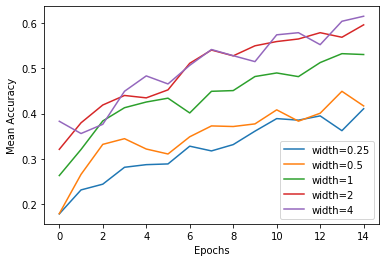

In [15]:
ax = None
for d in analysis4.trial_dataframes.values():
  ax = d.mean_accuracy.plot(ax=ax)
ax.set_xlabel("Epochs")
ax.set_ylabel("Mean Accuracy")
ax.legend(['width=0.25','width=0.5','width=1', 'width=2', 'width=4'])